In [40]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [41]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [43]:
def model_input(state_size):
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return prev_actions, states, actions, next_states, rewards, dones, rates

In [44]:
def Act(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        actions_logits = tf.layers.dense(inputs=nl2, units=action_size, trainable=False)
        return actions_logits

In [45]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [46]:
def model_loss(state_size, action_size, hidden_size, gamma,
               prev_actions, states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s, a')
    prev_actions_labels = tf.one_hot(indices=prev_actions, depth=action_size, dtype=states.dtype)
    actions_logits = Act(states=states, actions=prev_actions_labels, hidden_size=hidden_size, 
                         action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs_logits = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                           action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs_logits = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                           action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs_logits, shape=[-1])
    aQs_logits = tf.reshape(aQs_logits, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, actions=actions_labels, hidden_size=hidden_size, 
                              action_size=action_size, reuse=True)
    next_states_logits, aQs2_logits = Env(actions=next_actions_logits, states=next_states, 
                                          hidden_size=hidden_size, action_size=action_size, 
                                          state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2_logits, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss = tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean(aQs_logits) # minimize Q
    aloss2 += -tf.reduce_mean(aQs_logits) # maximize Q
    return actions_logits, aloss, eloss, aloss2

In [47]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [48]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma=gamma):

        # Data of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, # model input
            next_states=self.next_states, rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [49]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [50]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [51]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [52]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [53]:
state = env.reset()
total_reward = 0
num_step = 0
prev_action = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([prev_action, state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    prev_action = action
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0
        num_step = 0
        prev_action = 0

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [54]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list= [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1
        prev_action = 0

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                feed_dict={model.states: state.reshape([1, -1]), model.prev_actions: np.reshape(prev_action, [1])}
                action_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([prev_action, state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            prev_action = action
            
            # Training batches
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                prev_actions = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[6] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                prev_actions = prev_actions[rates >= np.max(rates)]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            feed_dict = {model.prev_actions: prev_actions,
                         model.states: states, 
                         model.actions: actions,
                         model.next_states: next_states,
                         model.rewards: rewards,
                         model.dones: dones,
                         model.rates: rates}
            aloss, _, eloss, _ = sess.run([model.a_loss, model.a_opt, model.e_loss, model.e_opt], feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print(aloss2, eloss2)
            #print(prev_actions.shape, prev_actions.dtype)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:34.0000 R:34.0000 rate:0.0680 aloss:0.7313 eloss:0.9880 aloss2:1.5704 exploreP:0.9966
Episode:1 meanR:24.5000 R:15.0000 rate:0.0300 aloss:0.7269 eloss:0.9450 aloss2:1.6159 exploreP:0.9952
Episode:2 meanR:20.6667 R:13.0000 rate:0.0260 aloss:0.7183 eloss:1.0662 aloss2:1.5604 exploreP:0.9939
Episode:3 meanR:20.2500 R:19.0000 rate:0.0380 aloss:0.7263 eloss:0.9303 aloss2:1.5825 exploreP:0.9920
Episode:4 meanR:17.8000 R:8.0000 rate:0.0160 aloss:0.7281 eloss:0.9673 aloss2:1.5910 exploreP:0.9912
Episode:5 meanR:17.6667 R:17.0000 rate:0.0340 aloss:0.7264 eloss:0.8857 aloss2:1.6831 exploreP:0.9896
Episode:6 meanR:18.5714 R:24.0000 rate:0.0480 aloss:0.7199 eloss:0.8584 aloss2:1.6436 exploreP:0.9872
Episode:7 meanR:20.5000 R:34.0000 rate:0.0680 aloss:0.7296 eloss:0.8642 aloss2:1.5882 exploreP:0.9839
Episode:8 meanR:21.1111 R:26.0000 rate:0.0520 aloss:0.7309 eloss:0.7564 aloss2:1.6375 exploreP:0.9814
Episode:9 meanR:20.9000 R:19.0000 rate:0.0380 aloss:0.7290 eloss:0.7114 aloss2:1.68

Episode:80 meanR:21.4938 R:23.0000 rate:0.0460 aloss:0.7286 eloss:0.6202 aloss2:2.1048 exploreP:0.8418
Episode:81 meanR:21.4146 R:15.0000 rate:0.0300 aloss:0.7143 eloss:0.6220 aloss2:2.0642 exploreP:0.8406
Episode:82 meanR:21.3976 R:20.0000 rate:0.0400 aloss:0.7224 eloss:0.6299 aloss2:2.0289 exploreP:0.8389
Episode:83 meanR:21.3095 R:14.0000 rate:0.0280 aloss:0.7237 eloss:0.5745 aloss2:2.2227 exploreP:0.8377
Episode:84 meanR:21.4000 R:29.0000 rate:0.0580 aloss:0.7127 eloss:0.5721 aloss2:2.2353 exploreP:0.8353
Episode:85 meanR:21.6860 R:46.0000 rate:0.0920 aloss:0.7232 eloss:0.5918 aloss2:2.1387 exploreP:0.8316
Episode:86 meanR:21.5862 R:13.0000 rate:0.0260 aloss:0.7205 eloss:0.5699 aloss2:2.2048 exploreP:0.8305
Episode:87 meanR:21.5682 R:20.0000 rate:0.0400 aloss:0.7243 eloss:0.5652 aloss2:2.2082 exploreP:0.8289
Episode:88 meanR:21.5955 R:24.0000 rate:0.0480 aloss:0.7185 eloss:0.5781 aloss2:2.1991 exploreP:0.8269
Episode:89 meanR:21.6333 R:25.0000 rate:0.0500 aloss:0.7154 eloss:0.5882 

Episode:159 meanR:18.2700 R:21.0000 rate:0.0420 aloss:0.7166 eloss:-0.3687 aloss2:3.6742 exploreP:0.7303
Episode:160 meanR:18.2600 R:15.0000 rate:0.0300 aloss:0.7189 eloss:-0.7840 aloss2:4.5282 exploreP:0.7292
Episode:161 meanR:18.1900 R:11.0000 rate:0.0220 aloss:0.7085 eloss:-0.5911 aloss2:4.0413 exploreP:0.7284
Episode:162 meanR:18.3300 R:23.0000 rate:0.0460 aloss:0.7107 eloss:-0.5389 aloss2:3.9272 exploreP:0.7267
Episode:163 meanR:18.3000 R:23.0000 rate:0.0460 aloss:0.7087 eloss:-0.5345 aloss2:3.9182 exploreP:0.7251
Episode:164 meanR:18.4300 R:24.0000 rate:0.0480 aloss:0.7129 eloss:-0.7729 aloss2:4.4771 exploreP:0.7234
Episode:165 meanR:18.2800 R:12.0000 rate:0.0240 aloss:0.7178 eloss:-0.6023 aloss2:3.9672 exploreP:0.7225
Episode:166 meanR:18.3700 R:22.0000 rate:0.0440 aloss:0.7094 eloss:-0.6526 aloss2:4.0488 exploreP:0.7210
Episode:167 meanR:18.2700 R:17.0000 rate:0.0340 aloss:0.7158 eloss:-0.7227 aloss2:4.2509 exploreP:0.7197
Episode:168 meanR:18.2800 R:12.0000 rate:0.0240 aloss:0

Episode:237 meanR:42.3100 R:94.0000 rate:0.1880 aloss:0.6992 eloss:-5.6020 aloss2:17.3228 exploreP:0.4999
Episode:238 meanR:42.5000 R:41.0000 rate:0.0820 aloss:0.6944 eloss:-4.6760 aloss2:17.6475 exploreP:0.4978
Episode:239 meanR:42.6700 R:40.0000 rate:0.0800 aloss:0.7089 eloss:-5.5942 aloss2:17.3781 exploreP:0.4959
Episode:240 meanR:43.7100 R:116.0000 rate:0.2320 aloss:0.7064 eloss:-5.4569 aloss2:17.9548 exploreP:0.4903
Episode:241 meanR:44.8600 R:128.0000 rate:0.2560 aloss:0.7141 eloss:-5.4943 aloss2:18.9607 exploreP:0.4842
Episode:242 meanR:45.8100 R:110.0000 rate:0.2200 aloss:0.7238 eloss:-5.8545 aloss2:18.7016 exploreP:0.4790
Episode:243 meanR:46.6400 R:103.0000 rate:0.2060 aloss:0.7292 eloss:-6.0280 aloss2:20.0692 exploreP:0.4742
Episode:244 meanR:47.0700 R:59.0000 rate:0.1180 aloss:0.7344 eloss:-6.1872 aloss2:20.1688 exploreP:0.4715
Episode:245 meanR:47.9600 R:107.0000 rate:0.2140 aloss:0.7121 eloss:-6.2399 aloss2:20.6078 exploreP:0.4666
Episode:246 meanR:48.7400 R:91.0000 rate:

Episode:314 meanR:74.2000 R:33.0000 rate:0.0660 aloss:0.7960 eloss:-10.8251 aloss2:41.4462 exploreP:0.2995
Episode:315 meanR:73.7600 R:19.0000 rate:0.0380 aloss:0.8160 eloss:-12.3520 aloss2:40.8494 exploreP:0.2989
Episode:316 meanR:73.1000 R:27.0000 rate:0.0540 aloss:0.7927 eloss:-12.4735 aloss2:40.7614 exploreP:0.2982
Episode:317 meanR:72.5100 R:44.0000 rate:0.0880 aloss:0.7830 eloss:-11.6212 aloss2:42.0148 exploreP:0.2969
Episode:318 meanR:72.4300 R:16.0000 rate:0.0320 aloss:0.7678 eloss:-11.3474 aloss2:42.6470 exploreP:0.2964
Episode:319 meanR:72.8200 R:61.0000 rate:0.1220 aloss:0.8202 eloss:-11.8198 aloss2:42.5371 exploreP:0.2947
Episode:320 meanR:72.1800 R:72.0000 rate:0.1440 aloss:0.8047 eloss:-10.6855 aloss2:42.9032 exploreP:0.2926
Episode:321 meanR:72.1500 R:68.0000 rate:0.1360 aloss:0.7984 eloss:-9.3234 aloss2:41.8561 exploreP:0.2907
Episode:322 meanR:71.6100 R:40.0000 rate:0.0800 aloss:0.8036 eloss:-12.2277 aloss2:44.3353 exploreP:0.2896
Episode:323 meanR:71.3300 R:63.0000 ra

Episode:391 meanR:41.7100 R:20.0000 rate:0.0400 aloss:0.7573 eloss:-12.2113 aloss2:49.6891 exploreP:0.2269
Episode:392 meanR:41.3500 R:39.0000 rate:0.0780 aloss:0.7444 eloss:-13.6873 aloss2:50.7835 exploreP:0.2261
Episode:393 meanR:41.0900 R:16.0000 rate:0.0320 aloss:0.7438 eloss:-12.3489 aloss2:49.4814 exploreP:0.2257
Episode:394 meanR:41.3800 R:70.0000 rate:0.1400 aloss:0.7316 eloss:-13.2351 aloss2:49.2320 exploreP:0.2242
Episode:395 meanR:41.2800 R:14.0000 rate:0.0280 aloss:0.7426 eloss:-15.0290 aloss2:51.8101 exploreP:0.2239
Episode:396 meanR:41.0500 R:61.0000 rate:0.1220 aloss:0.7696 eloss:-12.2883 aloss2:49.7834 exploreP:0.2226
Episode:397 meanR:40.5300 R:29.0000 rate:0.0580 aloss:0.7137 eloss:-13.0995 aloss2:50.7310 exploreP:0.2220
Episode:398 meanR:39.8600 R:30.0000 rate:0.0600 aloss:0.7165 eloss:-7.5553 aloss2:49.8891 exploreP:0.2214
Episode:399 meanR:39.7300 R:47.0000 rate:0.0940 aloss:0.7534 eloss:-10.1286 aloss2:49.4585 exploreP:0.2204
Episode:400 meanR:39.3400 R:24.0000 ra

Episode:468 meanR:32.8200 R:33.0000 rate:0.0660 aloss:0.7272 eloss:-9.4569 aloss2:51.6478 exploreP:0.1777
Episode:469 meanR:32.8300 R:33.0000 rate:0.0660 aloss:0.7150 eloss:-14.2617 aloss2:53.0956 exploreP:0.1772
Episode:470 meanR:32.9600 R:32.0000 rate:0.0640 aloss:0.7053 eloss:-14.3910 aloss2:54.5721 exploreP:0.1766
Episode:471 meanR:32.8100 R:22.0000 rate:0.0440 aloss:0.7392 eloss:-14.6375 aloss2:54.8753 exploreP:0.1763
Episode:472 meanR:33.3600 R:85.0000 rate:0.1700 aloss:0.7131 eloss:-10.0728 aloss2:52.7739 exploreP:0.1748
Episode:473 meanR:33.3300 R:36.0000 rate:0.0720 aloss:0.7142 eloss:-15.0581 aloss2:54.1570 exploreP:0.1743
Episode:474 meanR:33.5700 R:46.0000 rate:0.0920 aloss:0.7165 eloss:-14.2991 aloss2:54.0439 exploreP:0.1735
Episode:475 meanR:33.6500 R:24.0000 rate:0.0480 aloss:0.7146 eloss:-14.7919 aloss2:52.4962 exploreP:0.1731
Episode:476 meanR:33.7200 R:37.0000 rate:0.0740 aloss:0.7315 eloss:-14.0605 aloss2:52.6224 exploreP:0.1725
Episode:477 meanR:33.6200 R:19.0000 ra

Episode:545 meanR:36.4600 R:35.0000 rate:0.0700 aloss:0.7232 eloss:-15.6859 aloss2:57.0757 exploreP:0.1360
Episode:546 meanR:36.7100 R:91.0000 rate:0.1820 aloss:0.7058 eloss:-14.8672 aloss2:55.9748 exploreP:0.1348
Episode:547 meanR:36.7400 R:28.0000 rate:0.0560 aloss:0.7443 eloss:-15.5306 aloss2:54.2084 exploreP:0.1345
Episode:548 meanR:37.1900 R:93.0000 rate:0.1860 aloss:0.7333 eloss:-13.4588 aloss2:55.6869 exploreP:0.1333
Episode:549 meanR:37.2300 R:25.0000 rate:0.0500 aloss:0.7541 eloss:-16.3124 aloss2:56.7748 exploreP:0.1330
Episode:550 meanR:37.2300 R:26.0000 rate:0.0520 aloss:0.7584 eloss:-13.8656 aloss2:59.1817 exploreP:0.1327
Episode:551 meanR:38.0800 R:119.0000 rate:0.2380 aloss:0.7555 eloss:-14.8271 aloss2:56.4716 exploreP:0.1312
Episode:552 meanR:37.1200 R:27.0000 rate:0.0540 aloss:0.7197 eloss:-14.3363 aloss2:57.1211 exploreP:0.1309
Episode:553 meanR:37.2500 R:36.0000 rate:0.0720 aloss:0.7299 eloss:-14.4393 aloss2:58.0896 exploreP:0.1305
Episode:554 meanR:37.5200 R:90.0000 

Episode:622 meanR:43.2300 R:117.0000 rate:0.2340 aloss:0.7900 eloss:-16.3050 aloss2:60.0170 exploreP:0.0993
Episode:623 meanR:43.3300 R:58.0000 rate:0.1160 aloss:0.7697 eloss:-11.8229 aloss2:61.8817 exploreP:0.0988
Episode:624 meanR:43.6200 R:59.0000 rate:0.1180 aloss:0.7747 eloss:-16.3903 aloss2:59.5606 exploreP:0.0983
Episode:625 meanR:43.6100 R:24.0000 rate:0.0480 aloss:0.8323 eloss:-15.2659 aloss2:59.9976 exploreP:0.0981
Episode:626 meanR:43.7400 R:49.0000 rate:0.0980 aloss:0.7858 eloss:-15.0078 aloss2:59.9558 exploreP:0.0976
Episode:627 meanR:43.3500 R:22.0000 rate:0.0440 aloss:0.8112 eloss:-15.9146 aloss2:60.3292 exploreP:0.0974
Episode:628 meanR:43.0600 R:18.0000 rate:0.0360 aloss:0.8258 eloss:-12.8404 aloss2:60.4757 exploreP:0.0973
Episode:629 meanR:42.9900 R:42.0000 rate:0.0840 aloss:0.7395 eloss:-14.1773 aloss2:60.3976 exploreP:0.0969
Episode:630 meanR:42.7900 R:36.0000 rate:0.0720 aloss:0.7819 eloss:-12.4994 aloss2:57.4270 exploreP:0.0966
Episode:631 meanR:43.2100 R:65.0000 

Episode:699 meanR:37.2700 R:31.0000 rate:0.0620 aloss:0.7625 eloss:-15.9929 aloss2:62.0382 exploreP:0.0773
Episode:700 meanR:37.5600 R:52.0000 rate:0.1040 aloss:0.7834 eloss:-17.0362 aloss2:63.2183 exploreP:0.0770
Episode:701 meanR:37.0200 R:21.0000 rate:0.0420 aloss:0.8348 eloss:-9.9790 aloss2:62.4627 exploreP:0.0768
Episode:702 meanR:37.2000 R:38.0000 rate:0.0760 aloss:0.7615 eloss:-15.0803 aloss2:62.2890 exploreP:0.0766
Episode:703 meanR:37.2900 R:39.0000 rate:0.0780 aloss:0.7635 eloss:-16.5584 aloss2:62.6836 exploreP:0.0763
Episode:704 meanR:37.5200 R:46.0000 rate:0.0920 aloss:0.7414 eloss:-16.1208 aloss2:62.8126 exploreP:0.0760
Episode:705 meanR:37.4900 R:47.0000 rate:0.0940 aloss:0.7916 eloss:-14.0915 aloss2:64.0343 exploreP:0.0757
Episode:706 meanR:37.3600 R:20.0000 rate:0.0400 aloss:0.7348 eloss:-16.1673 aloss2:62.4448 exploreP:0.0756
Episode:707 meanR:36.9100 R:24.0000 rate:0.0480 aloss:0.7582 eloss:-16.4098 aloss2:62.4206 exploreP:0.0754
Episode:708 meanR:37.0500 R:36.0000 ra

Episode:776 meanR:37.8900 R:24.0000 rate:0.0480 aloss:0.7122 eloss:-17.9806 aloss2:63.9097 exploreP:0.0601
Episode:777 meanR:37.4600 R:22.0000 rate:0.0440 aloss:0.7942 eloss:-18.6344 aloss2:64.6499 exploreP:0.0600
Episode:778 meanR:37.5700 R:64.0000 rate:0.1280 aloss:0.7735 eloss:-16.7181 aloss2:65.2505 exploreP:0.0597
Episode:779 meanR:37.7400 R:42.0000 rate:0.0840 aloss:0.8041 eloss:-14.0327 aloss2:64.6450 exploreP:0.0595
Episode:780 meanR:37.7400 R:39.0000 rate:0.0780 aloss:0.7754 eloss:-18.5319 aloss2:64.9403 exploreP:0.0593
Episode:781 meanR:37.4200 R:27.0000 rate:0.0540 aloss:0.8076 eloss:-18.3323 aloss2:66.4046 exploreP:0.0592
Episode:782 meanR:37.7700 R:65.0000 rate:0.1300 aloss:0.7886 eloss:-15.8799 aloss2:64.8882 exploreP:0.0588
Episode:783 meanR:37.8400 R:32.0000 rate:0.0640 aloss:0.7897 eloss:-7.5705 aloss2:66.9145 exploreP:0.0587
Episode:784 meanR:37.9800 R:52.0000 rate:0.1040 aloss:0.7692 eloss:-14.2926 aloss2:63.9746 exploreP:0.0584
Episode:785 meanR:37.8500 R:28.0000 ra

Episode:853 meanR:37.3500 R:33.0000 rate:0.0660 aloss:0.8000 eloss:-14.6101 aloss2:65.0839 exploreP:0.0476
Episode:854 meanR:37.3500 R:35.0000 rate:0.0700 aloss:0.8004 eloss:-15.9327 aloss2:66.7106 exploreP:0.0475
Episode:855 meanR:37.2000 R:24.0000 rate:0.0480 aloss:0.7972 eloss:-18.2239 aloss2:67.9075 exploreP:0.0474
Episode:856 meanR:37.3200 R:41.0000 rate:0.0820 aloss:0.7527 eloss:-18.4636 aloss2:66.8506 exploreP:0.0472
Episode:857 meanR:36.8100 R:37.0000 rate:0.0740 aloss:0.7958 eloss:-17.1797 aloss2:67.7665 exploreP:0.0471
Episode:858 meanR:36.8000 R:29.0000 rate:0.0580 aloss:0.7507 eloss:-17.7528 aloss2:71.3779 exploreP:0.0470
Episode:859 meanR:36.7300 R:25.0000 rate:0.0500 aloss:0.7244 eloss:-18.2375 aloss2:68.1597 exploreP:0.0469
Episode:860 meanR:36.8500 R:66.0000 rate:0.1320 aloss:0.7708 eloss:-18.6943 aloss2:68.0682 exploreP:0.0466
Episode:861 meanR:36.8200 R:22.0000 rate:0.0440 aloss:0.8030 eloss:-14.4619 aloss2:65.8272 exploreP:0.0466
Episode:862 meanR:37.2200 R:63.0000 r

Episode:930 meanR:35.3600 R:46.0000 rate:0.0920 aloss:0.7439 eloss:-13.5943 aloss2:71.7272 exploreP:0.0389
Episode:931 meanR:35.0300 R:28.0000 rate:0.0560 aloss:0.7452 eloss:-18.8831 aloss2:69.7085 exploreP:0.0389
Episode:932 meanR:34.8700 R:26.0000 rate:0.0520 aloss:0.7297 eloss:-18.7796 aloss2:71.8578 exploreP:0.0388
Episode:933 meanR:34.5200 R:30.0000 rate:0.0600 aloss:0.7200 eloss:-17.5870 aloss2:70.8889 exploreP:0.0387
Episode:934 meanR:34.4100 R:21.0000 rate:0.0420 aloss:0.7178 eloss:-14.9277 aloss2:69.2821 exploreP:0.0386
Episode:935 meanR:34.5100 R:36.0000 rate:0.0720 aloss:0.7176 eloss:-19.2102 aloss2:70.8527 exploreP:0.0385
Episode:936 meanR:34.5400 R:26.0000 rate:0.0520 aloss:0.7353 eloss:-12.9338 aloss2:71.4756 exploreP:0.0385
Episode:937 meanR:34.6000 R:35.0000 rate:0.0700 aloss:0.7703 eloss:-16.2133 aloss2:74.8247 exploreP:0.0384
Episode:938 meanR:34.5600 R:25.0000 rate:0.0500 aloss:0.7125 eloss:-14.0887 aloss2:70.5729 exploreP:0.0383
Episode:939 meanR:34.4000 R:24.0000 r

Episode:1007 meanR:35.0200 R:25.0000 rate:0.0500 aloss:0.7584 eloss:-17.4374 aloss2:70.8468 exploreP:0.0320
Episode:1008 meanR:35.3100 R:47.0000 rate:0.0940 aloss:0.7194 eloss:-17.8620 aloss2:74.6468 exploreP:0.0319
Episode:1009 meanR:35.3300 R:23.0000 rate:0.0460 aloss:0.6744 eloss:-21.3106 aloss2:75.7309 exploreP:0.0319
Episode:1010 meanR:35.2900 R:38.0000 rate:0.0760 aloss:0.7405 eloss:-15.7495 aloss2:76.6172 exploreP:0.0318
Episode:1011 meanR:35.2300 R:25.0000 rate:0.0500 aloss:0.7838 eloss:-18.9820 aloss2:74.5250 exploreP:0.0317
Episode:1012 meanR:35.3500 R:33.0000 rate:0.0660 aloss:0.7608 eloss:-18.5323 aloss2:73.3438 exploreP:0.0316
Episode:1013 meanR:35.3500 R:26.0000 rate:0.0520 aloss:0.7422 eloss:-20.7940 aloss2:73.0338 exploreP:0.0316
Episode:1014 meanR:35.2900 R:29.0000 rate:0.0580 aloss:0.7746 eloss:-15.9386 aloss2:72.3912 exploreP:0.0315
Episode:1015 meanR:35.2900 R:21.0000 rate:0.0420 aloss:0.7465 eloss:-20.4272 aloss2:72.2060 exploreP:0.0315
Episode:1016 meanR:34.5300 R

Episode:1083 meanR:35.7000 R:22.0000 rate:0.0440 aloss:0.8264 eloss:-19.8403 aloss2:75.9817 exploreP:0.0267
Episode:1084 meanR:35.6200 R:24.0000 rate:0.0480 aloss:0.7732 eloss:-16.3866 aloss2:76.7249 exploreP:0.0266
Episode:1085 meanR:35.7800 R:38.0000 rate:0.0760 aloss:0.7372 eloss:-20.0063 aloss2:77.7516 exploreP:0.0266
Episode:1086 meanR:35.8100 R:36.0000 rate:0.0720 aloss:0.7921 eloss:-18.2405 aloss2:76.1724 exploreP:0.0265
Episode:1087 meanR:36.3600 R:87.0000 rate:0.1740 aloss:0.7689 eloss:-19.1688 aloss2:75.6103 exploreP:0.0264
Episode:1088 meanR:36.4400 R:30.0000 rate:0.0600 aloss:0.7197 eloss:-16.3976 aloss2:75.6264 exploreP:0.0263
Episode:1089 meanR:36.2700 R:32.0000 rate:0.0640 aloss:0.7063 eloss:-20.1270 aloss2:76.6961 exploreP:0.0263
Episode:1090 meanR:36.2400 R:28.0000 rate:0.0560 aloss:0.8056 eloss:-15.4500 aloss2:74.6591 exploreP:0.0262
Episode:1091 meanR:36.0300 R:23.0000 rate:0.0460 aloss:0.8079 eloss:29.9118 aloss2:76.3169 exploreP:0.0262
Episode:1092 meanR:36.0000 R:

Episode:1159 meanR:34.4800 R:23.0000 rate:0.0460 aloss:0.7657 eloss:-19.0506 aloss2:76.9427 exploreP:0.0229
Episode:1160 meanR:34.1800 R:25.0000 rate:0.0500 aloss:0.8167 eloss:-19.0432 aloss2:74.7636 exploreP:0.0229
Episode:1161 meanR:34.9200 R:112.0000 rate:0.2240 aloss:0.7581 eloss:-18.2385 aloss2:78.0520 exploreP:0.0227
Episode:1162 meanR:34.8900 R:38.0000 rate:0.0760 aloss:0.7933 eloss:-18.0450 aloss2:78.5208 exploreP:0.0227
Episode:1163 meanR:34.9900 R:27.0000 rate:0.0540 aloss:0.8158 eloss:-16.7142 aloss2:77.1306 exploreP:0.0227
Episode:1164 meanR:34.8700 R:15.0000 rate:0.0300 aloss:0.7056 eloss:-21.4439 aloss2:77.0488 exploreP:0.0226
Episode:1165 meanR:34.9100 R:37.0000 rate:0.0740 aloss:0.6865 eloss:-4.8770 aloss2:73.9561 exploreP:0.0226
Episode:1166 meanR:34.7400 R:32.0000 rate:0.0640 aloss:0.8003 eloss:-18.5075 aloss2:73.7055 exploreP:0.0226
Episode:1167 meanR:34.7200 R:34.0000 rate:0.0680 aloss:0.7928 eloss:-21.0223 aloss2:76.0655 exploreP:0.0225
Episode:1168 meanR:34.5100 R

Episode:1235 meanR:34.1700 R:45.0000 rate:0.0900 aloss:0.7705 eloss:-19.4628 aloss2:79.8419 exploreP:0.0199
Episode:1236 meanR:34.3300 R:53.0000 rate:0.1060 aloss:0.7634 eloss:-18.7012 aloss2:78.9131 exploreP:0.0199
Episode:1237 meanR:34.5000 R:43.0000 rate:0.0860 aloss:0.7202 eloss:-21.2075 aloss2:78.9586 exploreP:0.0198
Episode:1238 meanR:34.8000 R:54.0000 rate:0.1080 aloss:0.7105 eloss:-18.6105 aloss2:80.1203 exploreP:0.0198
Episode:1239 meanR:34.8500 R:46.0000 rate:0.0920 aloss:0.7402 eloss:-20.5060 aloss2:79.9486 exploreP:0.0197
Episode:1240 meanR:35.2300 R:81.0000 rate:0.1620 aloss:0.8011 eloss:-17.2285 aloss2:79.9568 exploreP:0.0196
Episode:1241 meanR:35.3500 R:34.0000 rate:0.0680 aloss:0.8007 eloss:-15.1976 aloss2:79.6732 exploreP:0.0196
Episode:1242 meanR:35.7500 R:58.0000 rate:0.1160 aloss:0.7404 eloss:-20.8667 aloss2:79.9446 exploreP:0.0196
Episode:1243 meanR:35.8900 R:41.0000 rate:0.0820 aloss:0.7389 eloss:-14.2276 aloss2:78.8549 exploreP:0.0195
Episode:1244 meanR:36.0500 R

Episode:1311 meanR:36.2100 R:35.0000 rate:0.0700 aloss:0.6950 eloss:-16.7790 aloss2:81.2643 exploreP:0.0175
Episode:1312 meanR:36.2500 R:30.0000 rate:0.0600 aloss:0.7527 eloss:-19.5377 aloss2:79.6122 exploreP:0.0175
Episode:1313 meanR:36.5200 R:62.0000 rate:0.1240 aloss:0.7264 eloss:-18.0391 aloss2:80.6123 exploreP:0.0174
Episode:1314 meanR:36.4800 R:22.0000 rate:0.0440 aloss:0.7034 eloss:-19.9165 aloss2:79.1556 exploreP:0.0174
Episode:1315 meanR:36.3900 R:33.0000 rate:0.0660 aloss:0.6614 eloss:-22.7876 aloss2:83.4245 exploreP:0.0174
Episode:1316 meanR:36.4600 R:37.0000 rate:0.0740 aloss:0.7538 eloss:-12.6177 aloss2:82.2077 exploreP:0.0174
Episode:1317 meanR:36.3000 R:29.0000 rate:0.0580 aloss:0.7272 eloss:-21.3436 aloss2:81.5318 exploreP:0.0174
Episode:1318 meanR:36.2900 R:67.0000 rate:0.1340 aloss:0.7364 eloss:-19.9313 aloss2:81.3054 exploreP:0.0173
Episode:1319 meanR:36.3900 R:35.0000 rate:0.0700 aloss:0.6727 eloss:-22.0523 aloss2:83.8745 exploreP:0.0173
Episode:1320 meanR:36.4700 R

Episode:1387 meanR:35.0600 R:20.0000 rate:0.0400 aloss:0.8959 eloss:-8.7801 aloss2:80.7580 exploreP:0.0157
Episode:1388 meanR:35.2300 R:45.0000 rate:0.0900 aloss:0.7524 eloss:-19.5365 aloss2:80.4038 exploreP:0.0157
Episode:1389 meanR:35.2000 R:39.0000 rate:0.0780 aloss:0.7590 eloss:-21.1974 aloss2:78.8440 exploreP:0.0156
Episode:1390 meanR:35.3800 R:45.0000 rate:0.0900 aloss:0.6646 eloss:-22.4785 aloss2:81.4835 exploreP:0.0156
Episode:1391 meanR:35.3000 R:22.0000 rate:0.0440 aloss:0.7020 eloss:-17.6173 aloss2:83.6876 exploreP:0.0156
Episode:1392 meanR:35.2300 R:31.0000 rate:0.0620 aloss:0.7432 eloss:-21.9928 aloss2:82.4142 exploreP:0.0156
Episode:1393 meanR:35.3000 R:27.0000 rate:0.0540 aloss:0.7921 eloss:0.9161 aloss2:82.8443 exploreP:0.0156
Episode:1394 meanR:35.2800 R:33.0000 rate:0.0660 aloss:0.6904 eloss:-20.4576 aloss2:79.9873 exploreP:0.0156
Episode:1395 meanR:35.3700 R:30.0000 rate:0.0600 aloss:0.7303 eloss:-18.0507 aloss2:79.9825 exploreP:0.0155
Episode:1396 meanR:35.5400 R:43

Episode:1463 meanR:37.0300 R:22.0000 rate:0.0440 aloss:0.7448 eloss:-20.8786 aloss2:78.8605 exploreP:0.0143
Episode:1464 meanR:36.8000 R:30.0000 rate:0.0600 aloss:0.6840 eloss:-15.1944 aloss2:83.7739 exploreP:0.0143
Episode:1465 meanR:36.8500 R:51.0000 rate:0.1020 aloss:0.7221 eloss:-19.3318 aloss2:81.8913 exploreP:0.0142
Episode:1466 meanR:36.6200 R:23.0000 rate:0.0460 aloss:0.7853 eloss:-12.4614 aloss2:85.4743 exploreP:0.0142
Episode:1467 meanR:36.5100 R:20.0000 rate:0.0400 aloss:0.7846 eloss:-22.0785 aloss2:82.6215 exploreP:0.0142
Episode:1468 meanR:36.3100 R:26.0000 rate:0.0520 aloss:0.6990 eloss:-22.6925 aloss2:84.1118 exploreP:0.0142
Episode:1469 meanR:36.1200 R:28.0000 rate:0.0560 aloss:0.7469 eloss:-23.8122 aloss2:79.3636 exploreP:0.0142
Episode:1470 meanR:36.1400 R:34.0000 rate:0.0680 aloss:0.7732 eloss:-19.8125 aloss2:78.6430 exploreP:0.0142
Episode:1471 meanR:36.2500 R:47.0000 rate:0.0940 aloss:0.7241 eloss:-9.1437 aloss2:81.8736 exploreP:0.0142
Episode:1472 meanR:36.2000 R:

Episode:1539 meanR:37.7400 R:97.0000 rate:0.1940 aloss:0.7364 eloss:-20.4033 aloss2:83.4164 exploreP:0.0132
Episode:1540 meanR:37.7100 R:22.0000 rate:0.0440 aloss:0.7228 eloss:-20.2052 aloss2:84.5050 exploreP:0.0132
Episode:1541 meanR:37.9000 R:41.0000 rate:0.0820 aloss:0.6787 eloss:-18.9944 aloss2:84.7086 exploreP:0.0132
Episode:1542 meanR:37.6800 R:26.0000 rate:0.0520 aloss:0.7360 eloss:-21.1088 aloss2:82.8676 exploreP:0.0132
Episode:1543 meanR:37.6000 R:25.0000 rate:0.0500 aloss:0.6329 eloss:-23.0873 aloss2:86.5764 exploreP:0.0132
Episode:1544 meanR:37.1500 R:39.0000 rate:0.0780 aloss:0.6894 eloss:-21.5376 aloss2:85.5010 exploreP:0.0132
Episode:1545 meanR:37.3000 R:48.0000 rate:0.0960 aloss:0.7371 eloss:-12.1673 aloss2:85.6420 exploreP:0.0132
Episode:1546 meanR:37.1600 R:39.0000 rate:0.0780 aloss:0.7593 eloss:-20.7458 aloss2:84.3073 exploreP:0.0131
Episode:1547 meanR:37.1900 R:24.0000 rate:0.0480 aloss:0.7217 eloss:-20.1438 aloss2:85.4684 exploreP:0.0131
Episode:1548 meanR:37.0100 R

Episode:1615 meanR:36.9900 R:25.0000 rate:0.0500 aloss:0.6627 eloss:-20.9896 aloss2:91.1115 exploreP:0.0124
Episode:1616 meanR:36.8600 R:23.0000 rate:0.0460 aloss:0.6508 eloss:-23.0387 aloss2:91.0980 exploreP:0.0124
Episode:1617 meanR:36.6000 R:23.0000 rate:0.0460 aloss:0.6742 eloss:-23.0590 aloss2:90.2389 exploreP:0.0124
Episode:1618 meanR:36.9400 R:60.0000 rate:0.1200 aloss:0.6464 eloss:-23.0558 aloss2:87.6127 exploreP:0.0124
Episode:1619 meanR:37.1500 R:49.0000 rate:0.0980 aloss:0.6781 eloss:-22.9109 aloss2:89.5847 exploreP:0.0124
Episode:1620 meanR:37.2300 R:37.0000 rate:0.0740 aloss:0.7342 eloss:-21.1017 aloss2:89.0465 exploreP:0.0124
Episode:1621 meanR:37.3200 R:34.0000 rate:0.0680 aloss:0.6897 eloss:-21.9581 aloss2:88.8250 exploreP:0.0124
Episode:1622 meanR:37.5600 R:67.0000 rate:0.1340 aloss:0.6994 eloss:-9.9101 aloss2:87.9223 exploreP:0.0124
Episode:1623 meanR:37.8000 R:46.0000 rate:0.0920 aloss:0.7384 eloss:-21.4575 aloss2:88.8698 exploreP:0.0124
Episode:1624 meanR:37.6500 R:

Episode:1691 meanR:35.4900 R:52.0000 rate:0.1040 aloss:0.6511 eloss:-25.0248 aloss2:90.3662 exploreP:0.0119
Episode:1692 meanR:35.1800 R:29.0000 rate:0.0580 aloss:0.6317 eloss:-15.6802 aloss2:86.3315 exploreP:0.0119
Episode:1693 meanR:34.9400 R:32.0000 rate:0.0640 aloss:0.5560 eloss:-23.0009 aloss2:89.2458 exploreP:0.0118
Episode:1694 meanR:34.9400 R:27.0000 rate:0.0540 aloss:0.7319 eloss:-23.7823 aloss2:90.6047 exploreP:0.0118
Episode:1695 meanR:35.0600 R:34.0000 rate:0.0680 aloss:0.7251 eloss:-23.2638 aloss2:88.8624 exploreP:0.0118
Episode:1696 meanR:35.0600 R:27.0000 rate:0.0540 aloss:0.7555 eloss:-4.4986 aloss2:86.4042 exploreP:0.0118
Episode:1697 meanR:35.0100 R:33.0000 rate:0.0660 aloss:0.6616 eloss:-24.6398 aloss2:88.4945 exploreP:0.0118
Episode:1698 meanR:35.2600 R:58.0000 rate:0.1160 aloss:0.6437 eloss:-20.8072 aloss2:90.8481 exploreP:0.0118
Episode:1699 meanR:35.1400 R:23.0000 rate:0.0460 aloss:0.7144 eloss:-21.0256 aloss2:87.3090 exploreP:0.0118
Episode:1700 meanR:35.2900 R:

Episode:1767 meanR:37.9100 R:23.0000 rate:0.0460 aloss:0.7583 eloss:-18.3832 aloss2:87.7068 exploreP:0.0114
Episode:1768 meanR:38.2000 R:53.0000 rate:0.1060 aloss:0.5795 eloss:-25.6322 aloss2:87.4310 exploreP:0.0114
Episode:1769 meanR:38.2400 R:28.0000 rate:0.0560 aloss:0.6809 eloss:5.0526 aloss2:84.7907 exploreP:0.0114
Episode:1770 meanR:38.2300 R:29.0000 rate:0.0580 aloss:0.7566 eloss:-22.7383 aloss2:87.3481 exploreP:0.0114
Episode:1771 meanR:38.2600 R:40.0000 rate:0.0800 aloss:0.6019 eloss:-23.3795 aloss2:88.5295 exploreP:0.0114
Episode:1772 meanR:38.3900 R:44.0000 rate:0.0880 aloss:0.7337 eloss:-21.1675 aloss2:85.8794 exploreP:0.0114
Episode:1773 meanR:38.4000 R:43.0000 rate:0.0860 aloss:0.5790 eloss:-24.0832 aloss2:90.3430 exploreP:0.0114
Episode:1774 meanR:38.2000 R:27.0000 rate:0.0540 aloss:0.6089 eloss:-24.5110 aloss2:90.3459 exploreP:0.0114
Episode:1775 meanR:38.5100 R:58.0000 rate:0.1160 aloss:0.6130 eloss:-24.4969 aloss2:89.1796 exploreP:0.0113
Episode:1776 meanR:38.3700 R:3

Episode:1843 meanR:36.6600 R:27.0000 rate:0.0540 aloss:0.6670 eloss:-22.7779 aloss2:94.6903 exploreP:0.0111
Episode:1844 meanR:36.6100 R:22.0000 rate:0.0440 aloss:0.6981 eloss:-21.8048 aloss2:93.1952 exploreP:0.0111
Episode:1845 meanR:36.3300 R:26.0000 rate:0.0520 aloss:0.7037 eloss:-24.5696 aloss2:90.6657 exploreP:0.0110
Episode:1846 meanR:36.6200 R:72.0000 rate:0.1440 aloss:0.6083 eloss:-22.0825 aloss2:93.1536 exploreP:0.0110
Episode:1847 meanR:36.6000 R:32.0000 rate:0.0640 aloss:0.5768 eloss:-23.0979 aloss2:94.7615 exploreP:0.0110
Episode:1848 meanR:36.2500 R:44.0000 rate:0.0880 aloss:0.6610 eloss:-26.3885 aloss2:92.8496 exploreP:0.0110
Episode:1849 meanR:36.1900 R:25.0000 rate:0.0500 aloss:0.5847 eloss:-19.0317 aloss2:90.1475 exploreP:0.0110
Episode:1850 meanR:36.4500 R:50.0000 rate:0.1000 aloss:0.6617 eloss:-23.1899 aloss2:92.5403 exploreP:0.0110
Episode:1851 meanR:36.9500 R:72.0000 rate:0.1440 aloss:0.6527 eloss:-18.9740 aloss2:93.5604 exploreP:0.0110
Episode:1852 meanR:36.6400 R

Episode:1919 meanR:34.9600 R:24.0000 rate:0.0480 aloss:0.6336 eloss:-23.2851 aloss2:97.8780 exploreP:0.0108
Episode:1920 meanR:35.1400 R:41.0000 rate:0.0820 aloss:0.6419 eloss:-24.8422 aloss2:94.8711 exploreP:0.0108
Episode:1921 meanR:35.2600 R:44.0000 rate:0.0880 aloss:0.6922 eloss:-22.1386 aloss2:96.3120 exploreP:0.0108
Episode:1922 meanR:35.4400 R:40.0000 rate:0.0800 aloss:0.6282 eloss:-20.1950 aloss2:94.4786 exploreP:0.0108
Episode:1923 meanR:35.5400 R:31.0000 rate:0.0620 aloss:0.5632 eloss:-25.7322 aloss2:94.9981 exploreP:0.0108
Episode:1924 meanR:35.6900 R:38.0000 rate:0.0760 aloss:0.5317 eloss:-24.3433 aloss2:93.8578 exploreP:0.0108
Episode:1925 meanR:35.6200 R:21.0000 rate:0.0420 aloss:0.6580 eloss:-26.4434 aloss2:98.4497 exploreP:0.0108
Episode:1926 meanR:35.5400 R:26.0000 rate:0.0520 aloss:0.5866 eloss:13.1854 aloss2:99.1503 exploreP:0.0108
Episode:1927 meanR:36.0100 R:69.0000 rate:0.1380 aloss:0.6750 eloss:-24.6396 aloss2:95.9612 exploreP:0.0108
Episode:1928 meanR:36.0700 R:

Episode:1995 meanR:37.0300 R:52.0000 rate:0.1040 aloss:0.6564 eloss:-23.9792 aloss2:97.0652 exploreP:0.0106
Episode:1996 meanR:37.1300 R:37.0000 rate:0.0740 aloss:0.6042 eloss:-24.7937 aloss2:95.3095 exploreP:0.0106
Episode:1997 meanR:37.1700 R:24.0000 rate:0.0480 aloss:0.5030 eloss:-26.3495 aloss2:96.6049 exploreP:0.0106
Episode:1998 meanR:37.2700 R:45.0000 rate:0.0900 aloss:0.6246 eloss:-24.4722 aloss2:94.8662 exploreP:0.0106
Episode:1999 meanR:37.3000 R:36.0000 rate:0.0720 aloss:0.5600 eloss:-24.1487 aloss2:97.7815 exploreP:0.0106
Episode:2000 meanR:37.2500 R:30.0000 rate:0.0600 aloss:0.4584 eloss:-27.3443 aloss2:97.0523 exploreP:0.0106
Episode:2001 meanR:37.5600 R:57.0000 rate:0.1140 aloss:0.5756 eloss:-4.3913 aloss2:95.0080 exploreP:0.0106
Episode:2002 meanR:37.7700 R:59.0000 rate:0.1180 aloss:0.6786 eloss:-26.7534 aloss2:94.4613 exploreP:0.0106
Episode:2003 meanR:37.6100 R:15.0000 rate:0.0300 aloss:0.5432 eloss:-30.1562 aloss2:91.1787 exploreP:0.0106
Episode:2004 meanR:37.6300 R:

Episode:2071 meanR:36.4800 R:41.0000 rate:0.0820 aloss:0.4935 eloss:-25.5940 aloss2:97.6904 exploreP:0.0105
Episode:2072 meanR:36.0300 R:21.0000 rate:0.0420 aloss:0.6001 eloss:-24.0575 aloss2:100.4998 exploreP:0.0105
Episode:2073 meanR:35.5300 R:42.0000 rate:0.0840 aloss:0.6079 eloss:-26.6753 aloss2:96.1653 exploreP:0.0105
Episode:2074 meanR:35.4100 R:31.0000 rate:0.0620 aloss:0.5843 eloss:-24.6722 aloss2:96.3123 exploreP:0.0105
Episode:2075 meanR:35.4300 R:25.0000 rate:0.0500 aloss:0.6690 eloss:-22.2332 aloss2:89.9716 exploreP:0.0105
Episode:2076 meanR:35.8300 R:68.0000 rate:0.1360 aloss:0.5779 eloss:-24.7939 aloss2:97.6588 exploreP:0.0105
Episode:2077 meanR:35.9300 R:38.0000 rate:0.0760 aloss:0.5881 eloss:-14.3533 aloss2:94.4177 exploreP:0.0104
Episode:2078 meanR:36.2200 R:56.0000 rate:0.1120 aloss:0.4927 eloss:-22.0938 aloss2:96.0589 exploreP:0.0104
Episode:2079 meanR:35.9000 R:26.0000 rate:0.0520 aloss:0.4952 eloss:-20.8565 aloss2:96.2806 exploreP:0.0104
Episode:2080 meanR:36.1100 

Episode:2147 meanR:36.9800 R:28.0000 rate:0.0560 aloss:0.4629 eloss:-27.8619 aloss2:95.4328 exploreP:0.0103
Episode:2148 meanR:36.7500 R:21.0000 rate:0.0420 aloss:0.6556 eloss:-20.2104 aloss2:100.0828 exploreP:0.0103
Episode:2149 meanR:36.9500 R:52.0000 rate:0.1040 aloss:0.5432 eloss:-25.2030 aloss2:98.0603 exploreP:0.0103
Episode:2150 meanR:36.8000 R:22.0000 rate:0.0440 aloss:0.5831 eloss:-27.7695 aloss2:98.9493 exploreP:0.0103
Episode:2151 meanR:37.0300 R:41.0000 rate:0.0820 aloss:0.5577 eloss:-16.2482 aloss2:96.4237 exploreP:0.0103
Episode:2152 meanR:37.1300 R:40.0000 rate:0.0800 aloss:0.4647 eloss:-29.2432 aloss2:100.3714 exploreP:0.0103
Episode:2153 meanR:37.3100 R:54.0000 rate:0.1080 aloss:0.5216 eloss:-27.3269 aloss2:99.4335 exploreP:0.0103
Episode:2154 meanR:37.2300 R:22.0000 rate:0.0440 aloss:0.6884 eloss:-24.0883 aloss2:95.6457 exploreP:0.0103
Episode:2155 meanR:37.1200 R:33.0000 rate:0.0660 aloss:0.5801 eloss:-25.8826 aloss2:100.3025 exploreP:0.0103
Episode:2156 meanR:37.250

Episode:2223 meanR:37.8700 R:55.0000 rate:0.1100 aloss:0.4518 eloss:-19.3323 aloss2:100.5321 exploreP:0.0103
Episode:2224 meanR:38.0200 R:39.0000 rate:0.0780 aloss:0.5032 eloss:-5.3002 aloss2:98.3126 exploreP:0.0103
Episode:2225 meanR:38.0000 R:26.0000 rate:0.0520 aloss:0.4664 eloss:-26.1010 aloss2:101.8777 exploreP:0.0103
Episode:2226 meanR:38.1900 R:66.0000 rate:0.1320 aloss:0.4574 eloss:-27.2413 aloss2:101.2099 exploreP:0.0103
Episode:2227 meanR:38.3300 R:55.0000 rate:0.1100 aloss:0.5466 eloss:-28.7449 aloss2:99.5354 exploreP:0.0103
Episode:2228 meanR:38.3200 R:24.0000 rate:0.0480 aloss:0.4429 eloss:-12.5884 aloss2:99.0114 exploreP:0.0103
Episode:2229 meanR:38.3600 R:69.0000 rate:0.1380 aloss:0.4157 eloss:-24.9553 aloss2:101.5294 exploreP:0.0102
Episode:2230 meanR:38.3600 R:21.0000 rate:0.0420 aloss:0.4553 eloss:-26.9525 aloss2:101.4640 exploreP:0.0102
Episode:2231 meanR:38.3800 R:32.0000 rate:0.0640 aloss:0.6774 eloss:-25.3118 aloss2:102.0261 exploreP:0.0102
Episode:2232 meanR:38.1

Episode:2299 meanR:36.8700 R:59.0000 rate:0.1180 aloss:0.5509 eloss:-22.2819 aloss2:104.9261 exploreP:0.0102
Episode:2300 meanR:37.1300 R:50.0000 rate:0.1000 aloss:0.4615 eloss:-3.6824 aloss2:101.7801 exploreP:0.0102
Episode:2301 meanR:37.2800 R:38.0000 rate:0.0760 aloss:0.6133 eloss:-27.2845 aloss2:102.5741 exploreP:0.0102
Episode:2302 meanR:37.5000 R:45.0000 rate:0.0900 aloss:0.4879 eloss:-22.4824 aloss2:102.9992 exploreP:0.0102
Episode:2303 meanR:37.4700 R:32.0000 rate:0.0640 aloss:0.5280 eloss:-28.4770 aloss2:103.3204 exploreP:0.0102
Episode:2304 meanR:37.2100 R:41.0000 rate:0.0820 aloss:0.6473 eloss:-25.2118 aloss2:100.6889 exploreP:0.0102
Episode:2305 meanR:37.3400 R:51.0000 rate:0.1020 aloss:0.4779 eloss:-28.3306 aloss2:102.3265 exploreP:0.0102
Episode:2306 meanR:37.4800 R:45.0000 rate:0.0900 aloss:0.5522 eloss:-25.8286 aloss2:105.3001 exploreP:0.0102
Episode:2307 meanR:37.4700 R:29.0000 rate:0.0580 aloss:0.5890 eloss:-18.7013 aloss2:99.7835 exploreP:0.0102
Episode:2308 meanR:37

Episode:2375 meanR:35.4900 R:20.0000 rate:0.0400 aloss:0.5330 eloss:-30.7950 aloss2:107.2953 exploreP:0.0102
Episode:2376 meanR:35.6800 R:63.0000 rate:0.1260 aloss:0.4708 eloss:-18.6228 aloss2:105.8432 exploreP:0.0102
Episode:2377 meanR:35.4100 R:27.0000 rate:0.0540 aloss:0.5561 eloss:-28.9390 aloss2:106.9281 exploreP:0.0101
Episode:2378 meanR:35.3800 R:24.0000 rate:0.0480 aloss:0.5960 eloss:-25.2216 aloss2:103.0112 exploreP:0.0101
Episode:2379 meanR:35.5700 R:43.0000 rate:0.0860 aloss:0.5918 eloss:-20.8456 aloss2:107.0741 exploreP:0.0101
Episode:2380 meanR:35.6400 R:36.0000 rate:0.0720 aloss:0.5002 eloss:-25.9434 aloss2:108.5092 exploreP:0.0101
Episode:2381 meanR:35.9200 R:53.0000 rate:0.1060 aloss:0.5809 eloss:-28.8817 aloss2:108.8468 exploreP:0.0101
Episode:2382 meanR:36.0000 R:40.0000 rate:0.0800 aloss:0.4646 eloss:-28.0566 aloss2:107.9057 exploreP:0.0101
Episode:2383 meanR:36.0600 R:31.0000 rate:0.0620 aloss:0.5645 eloss:-25.0562 aloss2:109.8712 exploreP:0.0101
Episode:2384 meanR:

Episode:2451 meanR:38.0300 R:29.0000 rate:0.0580 aloss:0.3976 eloss:-30.3300 aloss2:106.8524 exploreP:0.0101
Episode:2452 meanR:38.2500 R:48.0000 rate:0.0960 aloss:0.4618 eloss:-29.5467 aloss2:106.3746 exploreP:0.0101
Episode:2453 meanR:38.2300 R:37.0000 rate:0.0740 aloss:0.4952 eloss:-29.1212 aloss2:105.7101 exploreP:0.0101
Episode:2454 meanR:38.1300 R:22.0000 rate:0.0440 aloss:0.3779 eloss:-30.5914 aloss2:108.0501 exploreP:0.0101
Episode:2455 meanR:38.2100 R:33.0000 rate:0.0660 aloss:0.3684 eloss:-25.8861 aloss2:108.5662 exploreP:0.0101
Episode:2456 meanR:38.4000 R:42.0000 rate:0.0840 aloss:0.4641 eloss:-24.8488 aloss2:105.3510 exploreP:0.0101
Episode:2457 meanR:38.2500 R:27.0000 rate:0.0540 aloss:0.4791 eloss:-25.6612 aloss2:105.8576 exploreP:0.0101
Episode:2458 meanR:37.8500 R:30.0000 rate:0.0600 aloss:0.4878 eloss:-28.0791 aloss2:105.4928 exploreP:0.0101
Episode:2459 meanR:37.8200 R:25.0000 rate:0.0500 aloss:0.4041 eloss:-30.2909 aloss2:111.5345 exploreP:0.0101
Episode:2460 meanR:

Episode:2527 meanR:36.1800 R:41.0000 rate:0.0820 aloss:0.4630 eloss:-19.9772 aloss2:106.8329 exploreP:0.0101
Episode:2528 meanR:36.8200 R:80.0000 rate:0.1600 aloss:0.4579 eloss:-25.5547 aloss2:107.4885 exploreP:0.0101
Episode:2529 meanR:36.8500 R:26.0000 rate:0.0520 aloss:0.5024 eloss:-31.6842 aloss2:107.3226 exploreP:0.0101
Episode:2530 meanR:37.1000 R:51.0000 rate:0.1020 aloss:0.4687 eloss:-30.0984 aloss2:105.7830 exploreP:0.0101
Episode:2531 meanR:36.9200 R:42.0000 rate:0.0840 aloss:0.4321 eloss:-27.3845 aloss2:109.0603 exploreP:0.0101
Episode:2532 meanR:36.6600 R:24.0000 rate:0.0480 aloss:0.3827 eloss:-28.3954 aloss2:108.9991 exploreP:0.0101
Episode:2533 meanR:36.3900 R:31.0000 rate:0.0620 aloss:0.4055 eloss:-29.6291 aloss2:109.4235 exploreP:0.0101
Episode:2534 meanR:36.2700 R:26.0000 rate:0.0520 aloss:0.3273 eloss:-29.8325 aloss2:107.7636 exploreP:0.0101
Episode:2535 meanR:36.2100 R:23.0000 rate:0.0460 aloss:0.6177 eloss:-28.7476 aloss2:104.8725 exploreP:0.0101
Episode:2536 meanR:

Episode:2603 meanR:35.0100 R:28.0000 rate:0.0560 aloss:0.3667 eloss:-24.0846 aloss2:110.3692 exploreP:0.0101
Episode:2604 meanR:35.0300 R:28.0000 rate:0.0560 aloss:0.6466 eloss:-28.1422 aloss2:114.1706 exploreP:0.0101
Episode:2605 meanR:34.8500 R:21.0000 rate:0.0420 aloss:0.3520 eloss:-26.9889 aloss2:111.6110 exploreP:0.0101
Episode:2606 meanR:35.1500 R:56.0000 rate:0.1120 aloss:0.4448 eloss:-27.5697 aloss2:110.1773 exploreP:0.0101
Episode:2607 meanR:35.1700 R:23.0000 rate:0.0460 aloss:0.4375 eloss:-30.1828 aloss2:108.0465 exploreP:0.0101
Episode:2608 meanR:34.9400 R:28.0000 rate:0.0560 aloss:0.3960 eloss:-32.3291 aloss2:109.7088 exploreP:0.0101
Episode:2609 meanR:35.1300 R:54.0000 rate:0.1080 aloss:0.4665 eloss:-29.0332 aloss2:107.4148 exploreP:0.0101
Episode:2610 meanR:35.2000 R:28.0000 rate:0.0560 aloss:0.4628 eloss:-29.6193 aloss2:111.6006 exploreP:0.0101
Episode:2611 meanR:35.4300 R:48.0000 rate:0.0960 aloss:0.3506 eloss:-32.4012 aloss2:112.4163 exploreP:0.0101
Episode:2612 meanR:

Episode:2679 meanR:35.6100 R:76.0000 rate:0.1520 aloss:0.3513 eloss:-30.4649 aloss2:116.4285 exploreP:0.0101
Episode:2680 meanR:35.5700 R:28.0000 rate:0.0560 aloss:0.3456 eloss:-33.5094 aloss2:115.9861 exploreP:0.0101
Episode:2681 meanR:35.6200 R:26.0000 rate:0.0520 aloss:0.4544 eloss:-31.2551 aloss2:111.3812 exploreP:0.0101
Episode:2682 meanR:35.5600 R:22.0000 rate:0.0440 aloss:0.3887 eloss:-31.4838 aloss2:114.3091 exploreP:0.0100
Episode:2683 meanR:35.5100 R:32.0000 rate:0.0640 aloss:0.2876 eloss:-20.7625 aloss2:109.5513 exploreP:0.0100
Episode:2684 meanR:35.5500 R:36.0000 rate:0.0720 aloss:0.2625 eloss:-24.6624 aloss2:117.2195 exploreP:0.0100
Episode:2685 meanR:35.6200 R:42.0000 rate:0.0840 aloss:0.3370 eloss:-29.1265 aloss2:113.5998 exploreP:0.0100
Episode:2686 meanR:35.5300 R:19.0000 rate:0.0380 aloss:0.3253 eloss:-26.0988 aloss2:108.5507 exploreP:0.0100
Episode:2687 meanR:35.9600 R:73.0000 rate:0.1460 aloss:0.3812 eloss:-28.7130 aloss2:114.3931 exploreP:0.0100
Episode:2688 meanR:

Episode:2755 meanR:34.9800 R:24.0000 rate:0.0480 aloss:0.3082 eloss:-32.0859 aloss2:118.7317 exploreP:0.0100
Episode:2756 meanR:34.8900 R:34.0000 rate:0.0680 aloss:0.3641 eloss:-29.5369 aloss2:121.1328 exploreP:0.0100
Episode:2757 meanR:35.0700 R:54.0000 rate:0.1080 aloss:0.2699 eloss:-29.2007 aloss2:119.4379 exploreP:0.0100
Episode:2758 meanR:35.1000 R:30.0000 rate:0.0600 aloss:0.2239 eloss:-14.5553 aloss2:120.2650 exploreP:0.0100
Episode:2759 meanR:35.0600 R:30.0000 rate:0.0600 aloss:0.3316 eloss:-30.7611 aloss2:121.9208 exploreP:0.0100
Episode:2760 meanR:34.9400 R:22.0000 rate:0.0440 aloss:0.3079 eloss:-31.6439 aloss2:118.5115 exploreP:0.0100
Episode:2761 meanR:35.2100 R:48.0000 rate:0.0960 aloss:0.3387 eloss:-32.5727 aloss2:120.0781 exploreP:0.0100
Episode:2762 meanR:35.3500 R:36.0000 rate:0.0720 aloss:0.3708 eloss:-32.6007 aloss2:115.3576 exploreP:0.0100
Episode:2763 meanR:35.4600 R:56.0000 rate:0.1120 aloss:0.3084 eloss:-32.8945 aloss2:117.7910 exploreP:0.0100
Episode:2764 meanR:

Episode:2831 meanR:36.9700 R:31.0000 rate:0.0620 aloss:0.3129 eloss:-32.6182 aloss2:122.8983 exploreP:0.0100
Episode:2832 meanR:36.8800 R:37.0000 rate:0.0740 aloss:0.2772 eloss:-34.9949 aloss2:121.4718 exploreP:0.0100
Episode:2833 meanR:36.8200 R:29.0000 rate:0.0580 aloss:0.3858 eloss:-31.6478 aloss2:122.5856 exploreP:0.0100
Episode:2834 meanR:37.0600 R:47.0000 rate:0.0940 aloss:0.3031 eloss:-19.7294 aloss2:120.4057 exploreP:0.0100
Episode:2835 meanR:37.1300 R:29.0000 rate:0.0580 aloss:0.2447 eloss:-33.0528 aloss2:123.0022 exploreP:0.0100
Episode:2836 meanR:37.1100 R:24.0000 rate:0.0480 aloss:0.1714 eloss:-7.8425 aloss2:119.7010 exploreP:0.0100
Episode:2837 meanR:37.0300 R:45.0000 rate:0.0900 aloss:0.3679 eloss:-30.6674 aloss2:118.0778 exploreP:0.0100
Episode:2838 meanR:37.1700 R:38.0000 rate:0.0760 aloss:0.2786 eloss:-30.2899 aloss2:121.1789 exploreP:0.0100
Episode:2839 meanR:37.1800 R:21.0000 rate:0.0420 aloss:0.1737 eloss:-34.3513 aloss2:124.3355 exploreP:0.0100
Episode:2840 meanR:3

Episode:2907 meanR:38.4400 R:23.0000 rate:0.0460 aloss:0.2379 eloss:-27.2617 aloss2:125.5495 exploreP:0.0100
Episode:2908 meanR:38.2100 R:30.0000 rate:0.0600 aloss:0.2484 eloss:9.2856 aloss2:125.0894 exploreP:0.0100
Episode:2909 meanR:38.2200 R:29.0000 rate:0.0580 aloss:0.2953 eloss:-25.5987 aloss2:126.9945 exploreP:0.0100
Episode:2910 meanR:38.6900 R:70.0000 rate:0.1400 aloss:0.2622 eloss:-30.0358 aloss2:125.0439 exploreP:0.0100
Episode:2911 meanR:38.5100 R:37.0000 rate:0.0740 aloss:0.1896 eloss:-35.7025 aloss2:124.0348 exploreP:0.0100
Episode:2912 meanR:38.1200 R:34.0000 rate:0.0680 aloss:0.3261 eloss:-27.5692 aloss2:122.8628 exploreP:0.0100
Episode:2913 meanR:37.8700 R:37.0000 rate:0.0740 aloss:0.3559 eloss:-33.6640 aloss2:124.9047 exploreP:0.0100
Episode:2914 meanR:37.7900 R:22.0000 rate:0.0440 aloss:0.2740 eloss:-31.1967 aloss2:122.3813 exploreP:0.0100
Episode:2915 meanR:37.7900 R:32.0000 rate:0.0640 aloss:0.3688 eloss:20.1378 aloss2:118.6970 exploreP:0.0100
Episode:2916 meanR:37.

Episode:2983 meanR:37.4500 R:23.0000 rate:0.0460 aloss:0.1612 eloss:-32.3931 aloss2:126.4214 exploreP:0.0100
Episode:2984 meanR:37.6300 R:51.0000 rate:0.1020 aloss:0.2253 eloss:-27.5001 aloss2:122.9321 exploreP:0.0100
Episode:2985 meanR:37.2900 R:30.0000 rate:0.0600 aloss:0.2391 eloss:-28.7746 aloss2:124.8554 exploreP:0.0100
Episode:2986 meanR:37.2600 R:32.0000 rate:0.0640 aloss:0.1413 eloss:-29.5024 aloss2:123.4843 exploreP:0.0100
Episode:2987 meanR:37.4100 R:39.0000 rate:0.0780 aloss:0.3618 eloss:-24.9653 aloss2:121.3387 exploreP:0.0100
Episode:2988 meanR:37.4800 R:30.0000 rate:0.0600 aloss:0.1837 eloss:-20.6445 aloss2:119.3250 exploreP:0.0100
Episode:2989 meanR:37.9700 R:74.0000 rate:0.1480 aloss:0.2715 eloss:-32.9490 aloss2:120.9451 exploreP:0.0100
Episode:2990 meanR:38.0800 R:34.0000 rate:0.0680 aloss:0.2363 eloss:-29.4677 aloss2:118.4733 exploreP:0.0100
Episode:2991 meanR:37.8600 R:44.0000 rate:0.0880 aloss:0.2253 eloss:-29.3062 aloss2:122.8303 exploreP:0.0100
Episode:2992 meanR:

Episode:3059 meanR:35.1200 R:36.0000 rate:0.0720 aloss:0.1754 eloss:-30.8888 aloss2:124.6438 exploreP:0.0100
Episode:3060 meanR:35.1500 R:27.0000 rate:0.0540 aloss:0.0928 eloss:-29.7683 aloss2:123.3354 exploreP:0.0100
Episode:3061 meanR:35.1400 R:24.0000 rate:0.0480 aloss:0.1521 eloss:-32.6338 aloss2:122.6889 exploreP:0.0100
Episode:3062 meanR:35.3600 R:54.0000 rate:0.1080 aloss:0.1306 eloss:-23.9665 aloss2:121.8036 exploreP:0.0100
Episode:3063 meanR:35.3000 R:23.0000 rate:0.0460 aloss:0.2285 eloss:-28.4984 aloss2:118.7397 exploreP:0.0100
Episode:3064 meanR:35.6500 R:57.0000 rate:0.1140 aloss:0.1741 eloss:-33.7940 aloss2:123.5792 exploreP:0.0100
Episode:3065 meanR:35.6300 R:28.0000 rate:0.0560 aloss:0.2150 eloss:-37.2456 aloss2:122.4657 exploreP:0.0100
Episode:3066 meanR:35.4200 R:30.0000 rate:0.0600 aloss:0.1683 eloss:-32.0658 aloss2:127.4553 exploreP:0.0100
Episode:3067 meanR:35.2900 R:32.0000 rate:0.0640 aloss:0.1544 eloss:-31.2194 aloss2:120.4809 exploreP:0.0100
Episode:3068 meanR:

Episode:3135 meanR:35.4500 R:28.0000 rate:0.0560 aloss:0.2680 eloss:-32.5960 aloss2:125.4574 exploreP:0.0100
Episode:3136 meanR:35.7000 R:47.0000 rate:0.0940 aloss:0.0904 eloss:-26.9508 aloss2:125.4908 exploreP:0.0100
Episode:3137 meanR:35.7300 R:26.0000 rate:0.0520 aloss:0.1063 eloss:-35.5843 aloss2:126.9840 exploreP:0.0100
Episode:3138 meanR:35.8900 R:38.0000 rate:0.0760 aloss:0.1459 eloss:-31.6082 aloss2:127.6313 exploreP:0.0100
Episode:3139 meanR:36.0800 R:43.0000 rate:0.0860 aloss:0.1489 eloss:-33.1200 aloss2:127.1693 exploreP:0.0100
Episode:3140 meanR:36.1600 R:36.0000 rate:0.0720 aloss:0.1381 eloss:-30.1308 aloss2:127.9634 exploreP:0.0100
Episode:3141 meanR:36.2000 R:30.0000 rate:0.0600 aloss:0.1359 eloss:-33.8591 aloss2:126.8405 exploreP:0.0100
Episode:3142 meanR:36.5800 R:71.0000 rate:0.1420 aloss:0.0971 eloss:-33.7743 aloss2:126.7704 exploreP:0.0100
Episode:3143 meanR:36.5700 R:29.0000 rate:0.0580 aloss:0.1313 eloss:-34.2304 aloss2:124.7241 exploreP:0.0100
Episode:3144 meanR:

Episode:3211 meanR:37.2600 R:30.0000 rate:0.0600 aloss:0.0826 eloss:-28.4908 aloss2:128.8169 exploreP:0.0100
Episode:3212 meanR:37.7200 R:70.0000 rate:0.1400 aloss:0.1044 eloss:-31.5858 aloss2:126.6765 exploreP:0.0100
Episode:3213 meanR:37.7700 R:32.0000 rate:0.0640 aloss:0.1022 eloss:-23.3441 aloss2:125.5763 exploreP:0.0100
Episode:3214 meanR:37.8900 R:39.0000 rate:0.0780 aloss:0.1524 eloss:-31.0960 aloss2:128.9549 exploreP:0.0100
Episode:3215 meanR:37.7400 R:26.0000 rate:0.0520 aloss:0.0896 eloss:-29.8216 aloss2:129.0795 exploreP:0.0100
Episode:3216 meanR:37.7100 R:27.0000 rate:0.0540 aloss:0.1631 eloss:-32.9729 aloss2:130.0637 exploreP:0.0100
Episode:3217 meanR:37.4300 R:37.0000 rate:0.0740 aloss:0.2268 eloss:-27.6979 aloss2:130.2552 exploreP:0.0100
Episode:3218 meanR:37.4500 R:29.0000 rate:0.0580 aloss:0.1375 eloss:-29.3299 aloss2:131.2471 exploreP:0.0100
Episode:3219 meanR:37.3400 R:45.0000 rate:0.0900 aloss:0.1047 eloss:-35.4827 aloss2:129.0222 exploreP:0.0100
Episode:3220 meanR:

Episode:3287 meanR:36.7900 R:62.0000 rate:0.1240 aloss:0.0768 eloss:-31.8071 aloss2:132.4511 exploreP:0.0100
Episode:3288 meanR:36.9400 R:43.0000 rate:0.0860 aloss:0.0940 eloss:-32.2054 aloss2:131.7285 exploreP:0.0100
Episode:3289 meanR:36.9600 R:25.0000 rate:0.0500 aloss:0.1933 eloss:-35.6206 aloss2:132.7827 exploreP:0.0100
Episode:3290 meanR:37.1200 R:38.0000 rate:0.0760 aloss:0.0918 eloss:-31.3745 aloss2:129.1828 exploreP:0.0100
Episode:3291 meanR:37.2100 R:33.0000 rate:0.0660 aloss:0.0987 eloss:-30.4000 aloss2:129.6024 exploreP:0.0100
Episode:3292 meanR:37.1300 R:22.0000 rate:0.0440 aloss:0.0465 eloss:-30.7741 aloss2:128.8374 exploreP:0.0100
Episode:3293 meanR:36.4200 R:22.0000 rate:0.0440 aloss:0.0644 eloss:-26.4454 aloss2:129.9560 exploreP:0.0100
Episode:3294 meanR:36.5100 R:42.0000 rate:0.0840 aloss:0.0858 eloss:-9.7312 aloss2:130.5255 exploreP:0.0100
Episode:3295 meanR:36.4400 R:20.0000 rate:0.0400 aloss:0.1148 eloss:-30.7190 aloss2:134.1441 exploreP:0.0100
Episode:3296 meanR:3

Episode:3363 meanR:35.0100 R:35.0000 rate:0.0700 aloss:0.0954 eloss:-33.9308 aloss2:131.6037 exploreP:0.0100
Episode:3364 meanR:35.0300 R:38.0000 rate:0.0760 aloss:0.0890 eloss:-35.9202 aloss2:131.3706 exploreP:0.0100
Episode:3365 meanR:35.0200 R:24.0000 rate:0.0480 aloss:0.1015 eloss:-33.0100 aloss2:131.5275 exploreP:0.0100
Episode:3366 meanR:34.9300 R:28.0000 rate:0.0560 aloss:0.1006 eloss:-32.4615 aloss2:131.9061 exploreP:0.0100
Episode:3367 meanR:35.0500 R:40.0000 rate:0.0800 aloss:0.1293 eloss:-35.9535 aloss2:132.2564 exploreP:0.0100
Episode:3368 meanR:35.0300 R:24.0000 rate:0.0480 aloss:0.2636 eloss:-34.6908 aloss2:129.1317 exploreP:0.0100
Episode:3369 meanR:34.9800 R:24.0000 rate:0.0480 aloss:0.1603 eloss:-30.8852 aloss2:134.6744 exploreP:0.0100
Episode:3370 meanR:34.8000 R:24.0000 rate:0.0480 aloss:0.0743 eloss:-29.0666 aloss2:132.6812 exploreP:0.0100
Episode:3371 meanR:34.6800 R:22.0000 rate:0.0440 aloss:0.1537 eloss:-28.0934 aloss2:132.8015 exploreP:0.0100
Episode:3372 meanR:

Episode:3439 meanR:35.0700 R:40.0000 rate:0.0800 aloss:0.1140 eloss:-35.2581 aloss2:135.1439 exploreP:0.0100
Episode:3440 meanR:35.2100 R:46.0000 rate:0.0920 aloss:0.0733 eloss:-31.3028 aloss2:136.3520 exploreP:0.0100
Episode:3441 meanR:35.3900 R:63.0000 rate:0.1260 aloss:0.1007 eloss:-27.2585 aloss2:132.6679 exploreP:0.0100
Episode:3442 meanR:35.4600 R:66.0000 rate:0.1320 aloss:0.0842 eloss:-28.9855 aloss2:134.8582 exploreP:0.0100
Episode:3443 meanR:35.6500 R:46.0000 rate:0.0920 aloss:0.0931 eloss:-29.2574 aloss2:133.1636 exploreP:0.0100
Episode:3444 meanR:35.2300 R:21.0000 rate:0.0420 aloss:0.0611 eloss:-36.1308 aloss2:136.3289 exploreP:0.0100
Episode:3445 meanR:35.3100 R:38.0000 rate:0.0760 aloss:0.1237 eloss:-35.3887 aloss2:135.5590 exploreP:0.0100
Episode:3446 meanR:35.3100 R:29.0000 rate:0.0580 aloss:0.1300 eloss:-17.3855 aloss2:133.2521 exploreP:0.0100
Episode:3447 meanR:35.5200 R:52.0000 rate:0.1040 aloss:0.0835 eloss:-30.9683 aloss2:132.2331 exploreP:0.0100
Episode:3448 meanR:

Episode:3515 meanR:38.9700 R:30.0000 rate:0.0600 aloss:0.0911 eloss:-31.4681 aloss2:132.4291 exploreP:0.0100
Episode:3516 meanR:38.8900 R:44.0000 rate:0.0880 aloss:0.1929 eloss:-27.7751 aloss2:135.5437 exploreP:0.0100
Episode:3517 meanR:38.9100 R:42.0000 rate:0.0840 aloss:0.0961 eloss:-33.3484 aloss2:130.6740 exploreP:0.0100
Episode:3518 meanR:38.7500 R:33.0000 rate:0.0660 aloss:0.0763 eloss:-34.7622 aloss2:135.1641 exploreP:0.0100
Episode:3519 meanR:38.8600 R:31.0000 rate:0.0620 aloss:0.0715 eloss:-37.8221 aloss2:133.8685 exploreP:0.0100
Episode:3520 meanR:38.9400 R:32.0000 rate:0.0640 aloss:0.0853 eloss:-38.0909 aloss2:133.0787 exploreP:0.0100
Episode:3521 meanR:38.9700 R:26.0000 rate:0.0520 aloss:0.0625 eloss:-32.7471 aloss2:134.1729 exploreP:0.0100
Episode:3522 meanR:38.9300 R:60.0000 rate:0.1200 aloss:0.0501 eloss:-30.8834 aloss2:133.8191 exploreP:0.0100
Episode:3523 meanR:39.1600 R:40.0000 rate:0.0800 aloss:0.0514 eloss:-36.2216 aloss2:134.2740 exploreP:0.0100
Episode:3524 meanR:

Episode:3591 meanR:37.5700 R:41.0000 rate:0.0820 aloss:0.1152 eloss:-36.2126 aloss2:138.7434 exploreP:0.0100
Episode:3592 meanR:37.5400 R:42.0000 rate:0.0840 aloss:0.0794 eloss:-30.0868 aloss2:139.1803 exploreP:0.0100
Episode:3593 meanR:37.7400 R:58.0000 rate:0.1160 aloss:0.0902 eloss:-29.5261 aloss2:136.6127 exploreP:0.0100
Episode:3594 meanR:37.6400 R:29.0000 rate:0.0580 aloss:0.0998 eloss:-37.5320 aloss2:136.1297 exploreP:0.0100
Episode:3595 meanR:37.6400 R:25.0000 rate:0.0500 aloss:0.0833 eloss:-34.7156 aloss2:136.9949 exploreP:0.0100
Episode:3596 meanR:37.3000 R:42.0000 rate:0.0840 aloss:0.0670 eloss:-36.3147 aloss2:135.3873 exploreP:0.0100
Episode:3597 meanR:37.4500 R:44.0000 rate:0.0880 aloss:0.0710 eloss:-33.2317 aloss2:134.2811 exploreP:0.0100
Episode:3598 meanR:37.4600 R:48.0000 rate:0.0960 aloss:0.1636 eloss:-24.2504 aloss2:135.5280 exploreP:0.0100
Episode:3599 meanR:37.3100 R:39.0000 rate:0.0780 aloss:0.0632 eloss:-37.2088 aloss2:137.5804 exploreP:0.0100
Episode:3600 meanR:

Episode:3667 meanR:36.0100 R:26.0000 rate:0.0520 aloss:0.0454 eloss:-36.9540 aloss2:141.2657 exploreP:0.0100
Episode:3668 meanR:35.9300 R:28.0000 rate:0.0560 aloss:0.0523 eloss:-42.2110 aloss2:141.5833 exploreP:0.0100
Episode:3669 meanR:35.8300 R:22.0000 rate:0.0440 aloss:0.0373 eloss:-36.5917 aloss2:143.2746 exploreP:0.0100
Episode:3670 meanR:35.0700 R:36.0000 rate:0.0720 aloss:0.0707 eloss:-36.4233 aloss2:142.0595 exploreP:0.0100
Episode:3671 meanR:34.8700 R:20.0000 rate:0.0400 aloss:0.0812 eloss:-41.4338 aloss2:143.2972 exploreP:0.0100
Episode:3672 meanR:35.0800 R:45.0000 rate:0.0900 aloss:0.0886 eloss:-37.7374 aloss2:142.1047 exploreP:0.0100
Episode:3673 meanR:35.4100 R:60.0000 rate:0.1200 aloss:0.0522 eloss:-39.4693 aloss2:143.2532 exploreP:0.0100
Episode:3674 meanR:35.8700 R:68.0000 rate:0.1360 aloss:0.0835 eloss:-34.3466 aloss2:142.9223 exploreP:0.0100
Episode:3675 meanR:35.8800 R:22.0000 rate:0.0440 aloss:0.0729 eloss:-36.4792 aloss2:139.6059 exploreP:0.0100
Episode:3676 meanR:

Episode:3743 meanR:35.7500 R:22.0000 rate:0.0440 aloss:0.0527 eloss:-38.6026 aloss2:147.0487 exploreP:0.0100
Episode:3744 meanR:35.7300 R:33.0000 rate:0.0660 aloss:0.0376 eloss:-39.6945 aloss2:143.5969 exploreP:0.0100
Episode:3745 meanR:36.1800 R:72.0000 rate:0.1440 aloss:0.0488 eloss:-38.1382 aloss2:147.3911 exploreP:0.0100
Episode:3746 meanR:36.1500 R:23.0000 rate:0.0460 aloss:0.0368 eloss:-41.3148 aloss2:147.0838 exploreP:0.0100
Episode:3747 meanR:35.9400 R:33.0000 rate:0.0660 aloss:0.0683 eloss:-39.7117 aloss2:147.0519 exploreP:0.0100
Episode:3748 meanR:36.2100 R:52.0000 rate:0.1040 aloss:0.0891 eloss:-40.0765 aloss2:148.7398 exploreP:0.0100
Episode:3749 meanR:36.1600 R:34.0000 rate:0.0680 aloss:0.0465 eloss:-36.5345 aloss2:148.3305 exploreP:0.0100
Episode:3750 meanR:36.2200 R:35.0000 rate:0.0700 aloss:0.0583 eloss:-40.9955 aloss2:147.0152 exploreP:0.0100
Episode:3751 meanR:36.1700 R:23.0000 rate:0.0460 aloss:0.0566 eloss:-39.5580 aloss2:150.7562 exploreP:0.0100
Episode:3752 meanR:

Episode:3819 meanR:35.6000 R:36.0000 rate:0.0720 aloss:0.0644 eloss:-32.8812 aloss2:150.3847 exploreP:0.0100
Episode:3820 meanR:35.6000 R:52.0000 rate:0.1040 aloss:0.0585 eloss:-39.9903 aloss2:151.5451 exploreP:0.0100
Episode:3821 meanR:35.7600 R:46.0000 rate:0.0920 aloss:0.0524 eloss:-42.8005 aloss2:150.0922 exploreP:0.0100
Episode:3822 meanR:35.6100 R:23.0000 rate:0.0460 aloss:0.0568 eloss:-39.8238 aloss2:153.9792 exploreP:0.0100
Episode:3823 meanR:35.7600 R:41.0000 rate:0.0820 aloss:0.0435 eloss:-42.9903 aloss2:148.3388 exploreP:0.0100
Episode:3824 meanR:35.7700 R:49.0000 rate:0.0980 aloss:0.0541 eloss:-30.7200 aloss2:149.3108 exploreP:0.0100
Episode:3825 meanR:35.7900 R:23.0000 rate:0.0460 aloss:0.0706 eloss:-45.1116 aloss2:151.7923 exploreP:0.0100
Episode:3826 meanR:35.8000 R:31.0000 rate:0.0620 aloss:0.0421 eloss:-46.1477 aloss2:155.0393 exploreP:0.0100
Episode:3827 meanR:35.6700 R:26.0000 rate:0.0520 aloss:0.0848 eloss:-30.7256 aloss2:148.9807 exploreP:0.0100
Episode:3828 meanR:

Episode:3895 meanR:34.8600 R:36.0000 rate:0.0720 aloss:0.0453 eloss:-42.4415 aloss2:155.7491 exploreP:0.0100
Episode:3896 meanR:34.7500 R:27.0000 rate:0.0540 aloss:0.0467 eloss:-41.9619 aloss2:159.6259 exploreP:0.0100
Episode:3897 meanR:34.6500 R:22.0000 rate:0.0440 aloss:0.0754 eloss:-45.8418 aloss2:159.1509 exploreP:0.0100
Episode:3898 meanR:34.6500 R:23.0000 rate:0.0460 aloss:0.0695 eloss:-37.3984 aloss2:161.4056 exploreP:0.0100
Episode:3899 meanR:34.9400 R:52.0000 rate:0.1040 aloss:0.0550 eloss:-48.2627 aloss2:157.4220 exploreP:0.0100
Episode:3900 meanR:34.7200 R:25.0000 rate:0.0500 aloss:0.0682 eloss:-44.6394 aloss2:160.0536 exploreP:0.0100
Episode:3901 meanR:34.8100 R:52.0000 rate:0.1040 aloss:0.0537 eloss:-42.9220 aloss2:156.1827 exploreP:0.0100
Episode:3902 meanR:34.8400 R:28.0000 rate:0.0560 aloss:0.0243 eloss:-47.3291 aloss2:157.4298 exploreP:0.0100
Episode:3903 meanR:34.5300 R:25.0000 rate:0.0500 aloss:0.0530 eloss:-49.0274 aloss2:155.6185 exploreP:0.0100
Episode:3904 meanR:

Episode:3971 meanR:35.5500 R:37.0000 rate:0.0740 aloss:0.0592 eloss:-46.8669 aloss2:164.1054 exploreP:0.0100
Episode:3972 meanR:35.5000 R:25.0000 rate:0.0500 aloss:0.0865 eloss:-44.9296 aloss2:168.6160 exploreP:0.0100
Episode:3973 meanR:35.5600 R:32.0000 rate:0.0640 aloss:0.0514 eloss:-39.5828 aloss2:162.7500 exploreP:0.0100
Episode:3974 meanR:35.5100 R:25.0000 rate:0.0500 aloss:0.0648 eloss:-44.8286 aloss2:161.6903 exploreP:0.0100
Episode:3975 meanR:35.4800 R:41.0000 rate:0.0820 aloss:0.0595 eloss:-32.9451 aloss2:162.9334 exploreP:0.0100
Episode:3976 meanR:35.4800 R:50.0000 rate:0.1000 aloss:0.0536 eloss:-45.4019 aloss2:165.1751 exploreP:0.0100
Episode:3977 meanR:35.5200 R:33.0000 rate:0.0660 aloss:0.0537 eloss:-43.7320 aloss2:164.8809 exploreP:0.0100
Episode:3978 meanR:35.4800 R:26.0000 rate:0.0520 aloss:0.0636 eloss:-48.5228 aloss2:167.9591 exploreP:0.0100
Episode:3979 meanR:35.3600 R:21.0000 rate:0.0420 aloss:0.0587 eloss:-50.9689 aloss2:167.4252 exploreP:0.0100
Episode:3980 meanR:

Episode:4047 meanR:36.4500 R:48.0000 rate:0.0960 aloss:0.0700 eloss:-48.5535 aloss2:171.7872 exploreP:0.0100
Episode:4048 meanR:36.9500 R:75.0000 rate:0.1500 aloss:0.0579 eloss:-48.8991 aloss2:172.4047 exploreP:0.0100
Episode:4049 meanR:36.9800 R:26.0000 rate:0.0520 aloss:0.0509 eloss:-47.9578 aloss2:170.1495 exploreP:0.0100
Episode:4050 meanR:36.9300 R:23.0000 rate:0.0460 aloss:0.0534 eloss:-52.2602 aloss2:170.9957 exploreP:0.0100
Episode:4051 meanR:36.8800 R:23.0000 rate:0.0460 aloss:0.0614 eloss:-50.6120 aloss2:172.1565 exploreP:0.0100
Episode:4052 meanR:37.2900 R:66.0000 rate:0.1320 aloss:0.0730 eloss:-43.7596 aloss2:171.3323 exploreP:0.0100
Episode:4053 meanR:37.3000 R:24.0000 rate:0.0480 aloss:0.0539 eloss:-46.8347 aloss2:172.5914 exploreP:0.0100
Episode:4054 meanR:37.0800 R:26.0000 rate:0.0520 aloss:0.0697 eloss:-45.1722 aloss2:172.6758 exploreP:0.0100
Episode:4055 meanR:37.3300 R:59.0000 rate:0.1180 aloss:0.0415 eloss:-49.7681 aloss2:172.8174 exploreP:0.0100
Episode:4056 meanR:

Episode:4123 meanR:36.3200 R:35.0000 rate:0.0700 aloss:0.0673 eloss:-39.0543 aloss2:173.5272 exploreP:0.0100
Episode:4124 meanR:36.0500 R:26.0000 rate:0.0520 aloss:0.0500 eloss:-48.7841 aloss2:174.3207 exploreP:0.0100
Episode:4125 meanR:35.9200 R:28.0000 rate:0.0560 aloss:0.0430 eloss:-51.4458 aloss2:175.6745 exploreP:0.0100
Episode:4126 meanR:35.7500 R:31.0000 rate:0.0620 aloss:0.0690 eloss:-56.2074 aloss2:174.1645 exploreP:0.0100
Episode:4127 meanR:35.7300 R:26.0000 rate:0.0520 aloss:0.0696 eloss:-47.7985 aloss2:174.3558 exploreP:0.0100
Episode:4128 meanR:35.6200 R:34.0000 rate:0.0680 aloss:0.0425 eloss:-46.7618 aloss2:173.8096 exploreP:0.0100
Episode:4129 meanR:35.6500 R:28.0000 rate:0.0560 aloss:0.0552 eloss:-40.9658 aloss2:173.4832 exploreP:0.0100
Episode:4130 meanR:35.4300 R:30.0000 rate:0.0600 aloss:0.0776 eloss:-51.9123 aloss2:175.8513 exploreP:0.0100
Episode:4131 meanR:36.0800 R:98.0000 rate:0.1960 aloss:0.0674 eloss:-47.0325 aloss2:171.7641 exploreP:0.0100
Episode:4132 meanR:

Episode:4199 meanR:36.8100 R:28.0000 rate:0.0560 aloss:0.0573 eloss:-50.0249 aloss2:183.7720 exploreP:0.0100
Episode:4200 meanR:36.8400 R:30.0000 rate:0.0600 aloss:0.0605 eloss:-47.8268 aloss2:179.4969 exploreP:0.0100
Episode:4201 meanR:36.7100 R:34.0000 rate:0.0680 aloss:0.0643 eloss:-46.3506 aloss2:181.6347 exploreP:0.0100
Episode:4202 meanR:36.6400 R:22.0000 rate:0.0440 aloss:0.0866 eloss:-51.3998 aloss2:182.3255 exploreP:0.0100
Episode:4203 meanR:36.6700 R:49.0000 rate:0.0980 aloss:0.0615 eloss:-57.1372 aloss2:181.2576 exploreP:0.0100
Episode:4204 meanR:36.4000 R:28.0000 rate:0.0560 aloss:0.0594 eloss:-55.9283 aloss2:182.5107 exploreP:0.0100
Episode:4205 meanR:36.2400 R:36.0000 rate:0.0720 aloss:0.0678 eloss:-55.8805 aloss2:184.5157 exploreP:0.0100
Episode:4206 meanR:36.2800 R:27.0000 rate:0.0540 aloss:0.0544 eloss:-54.4819 aloss2:186.2814 exploreP:0.0100
Episode:4207 meanR:36.9200 R:99.0000 rate:0.1980 aloss:0.0623 eloss:-53.2917 aloss2:184.3950 exploreP:0.0100
Episode:4208 meanR:

Episode:4275 meanR:34.2600 R:20.0000 rate:0.0400 aloss:0.0509 eloss:-48.5793 aloss2:184.1233 exploreP:0.0100
Episode:4276 meanR:34.4000 R:37.0000 rate:0.0740 aloss:0.0513 eloss:-58.4764 aloss2:190.5150 exploreP:0.0100
Episode:4277 meanR:34.1700 R:31.0000 rate:0.0620 aloss:0.0749 eloss:-57.9278 aloss2:193.3982 exploreP:0.0100
Episode:4278 meanR:33.7900 R:29.0000 rate:0.0580 aloss:0.0670 eloss:-58.8053 aloss2:186.3136 exploreP:0.0100
Episode:4279 meanR:33.7900 R:30.0000 rate:0.0600 aloss:0.0886 eloss:-56.1776 aloss2:195.1200 exploreP:0.0100
Episode:4280 meanR:33.9100 R:38.0000 rate:0.0760 aloss:0.0639 eloss:-56.3343 aloss2:194.3905 exploreP:0.0100
Episode:4281 meanR:34.1200 R:91.0000 rate:0.1820 aloss:0.0714 eloss:-33.9080 aloss2:192.8078 exploreP:0.0100
Episode:4282 meanR:33.8400 R:22.0000 rate:0.0440 aloss:0.1065 eloss:-18.8854 aloss2:188.7075 exploreP:0.0100
Episode:4283 meanR:34.2300 R:66.0000 rate:0.1320 aloss:0.0506 eloss:-60.7169 aloss2:192.8822 exploreP:0.0100
Episode:4284 meanR:

Episode:4351 meanR:35.2800 R:34.0000 rate:0.0680 aloss:0.0634 eloss:-57.5455 aloss2:196.9776 exploreP:0.0100
Episode:4352 meanR:35.2500 R:30.0000 rate:0.0600 aloss:0.0637 eloss:-62.9243 aloss2:201.4196 exploreP:0.0100
Episode:4353 meanR:35.0900 R:29.0000 rate:0.0580 aloss:0.0520 eloss:-59.3850 aloss2:202.0060 exploreP:0.0100
Episode:4354 meanR:35.4500 R:56.0000 rate:0.1120 aloss:0.0525 eloss:-62.2375 aloss2:198.2283 exploreP:0.0100
Episode:4355 meanR:35.2700 R:30.0000 rate:0.0600 aloss:0.0769 eloss:-61.6801 aloss2:199.3673 exploreP:0.0100
Episode:4356 meanR:35.4000 R:46.0000 rate:0.0920 aloss:0.0695 eloss:-61.7962 aloss2:203.1313 exploreP:0.0100
Episode:4357 meanR:35.7300 R:55.0000 rate:0.1100 aloss:0.0602 eloss:-55.9493 aloss2:199.6467 exploreP:0.0100
Episode:4358 meanR:35.7300 R:26.0000 rate:0.0520 aloss:0.0530 eloss:-38.3999 aloss2:183.2386 exploreP:0.0100
Episode:4359 meanR:36.0100 R:49.0000 rate:0.0980 aloss:0.0608 eloss:-61.9048 aloss2:200.9974 exploreP:0.0100
Episode:4360 meanR:

Episode:4427 meanR:38.1200 R:44.0000 rate:0.0880 aloss:0.0728 eloss:-60.4809 aloss2:205.7720 exploreP:0.0100
Episode:4428 meanR:38.1000 R:27.0000 rate:0.0540 aloss:0.0551 eloss:-63.9513 aloss2:211.3048 exploreP:0.0100
Episode:4429 meanR:38.4200 R:61.0000 rate:0.1220 aloss:0.0581 eloss:-61.5498 aloss2:207.8737 exploreP:0.0100
Episode:4430 meanR:38.3400 R:27.0000 rate:0.0540 aloss:0.0759 eloss:-50.0892 aloss2:209.3384 exploreP:0.0100
Episode:4431 meanR:38.3000 R:43.0000 rate:0.0860 aloss:0.0577 eloss:-67.3589 aloss2:211.5532 exploreP:0.0100
Episode:4432 meanR:38.0300 R:25.0000 rate:0.0500 aloss:0.0334 eloss:-70.0302 aloss2:208.1486 exploreP:0.0100
Episode:4433 meanR:37.9700 R:26.0000 rate:0.0520 aloss:0.0810 eloss:-66.5265 aloss2:210.3013 exploreP:0.0100
Episode:4434 meanR:38.2300 R:49.0000 rate:0.0980 aloss:0.0606 eloss:-61.5421 aloss2:209.1432 exploreP:0.0100
Episode:4435 meanR:38.2500 R:30.0000 rate:0.0600 aloss:0.0628 eloss:-61.7009 aloss2:213.3702 exploreP:0.0100
Episode:4436 meanR:

Episode:4503 meanR:38.5300 R:26.0000 rate:0.0520 aloss:0.0477 eloss:-53.9630 aloss2:212.4654 exploreP:0.0100
Episode:4504 meanR:38.5700 R:38.0000 rate:0.0760 aloss:0.0565 eloss:-60.2515 aloss2:214.3784 exploreP:0.0100
Episode:4505 meanR:38.6300 R:38.0000 rate:0.0760 aloss:0.0616 eloss:-64.4528 aloss2:211.5554 exploreP:0.0100
Episode:4506 meanR:38.6300 R:27.0000 rate:0.0540 aloss:0.0781 eloss:-52.0945 aloss2:214.8075 exploreP:0.0100
Episode:4507 meanR:38.1600 R:34.0000 rate:0.0680 aloss:0.0425 eloss:-68.9614 aloss2:213.3498 exploreP:0.0100
Episode:4508 meanR:38.1100 R:22.0000 rate:0.0440 aloss:0.0486 eloss:-65.2307 aloss2:203.8123 exploreP:0.0100
Episode:4509 meanR:37.9200 R:35.0000 rate:0.0700 aloss:0.0584 eloss:-69.1534 aloss2:217.6235 exploreP:0.0100
Episode:4510 meanR:37.9600 R:47.0000 rate:0.0940 aloss:0.0573 eloss:-63.2586 aloss2:218.4129 exploreP:0.0100
Episode:4511 meanR:37.8300 R:35.0000 rate:0.0700 aloss:0.0474 eloss:-68.5189 aloss2:218.0103 exploreP:0.0100
Episode:4512 meanR:

Episode:4579 meanR:38.0300 R:42.0000 rate:0.0840 aloss:0.0451 eloss:-73.6916 aloss2:224.8119 exploreP:0.0100
Episode:4580 meanR:38.0100 R:36.0000 rate:0.0720 aloss:0.0629 eloss:-73.2471 aloss2:231.9416 exploreP:0.0100
Episode:4581 meanR:37.8400 R:41.0000 rate:0.0820 aloss:0.0579 eloss:-71.5866 aloss2:226.9375 exploreP:0.0100
Episode:4582 meanR:38.1300 R:74.0000 rate:0.1480 aloss:0.0657 eloss:-64.8188 aloss2:220.6653 exploreP:0.0100
Episode:4583 meanR:38.1500 R:24.0000 rate:0.0480 aloss:0.0671 eloss:-67.2223 aloss2:214.0787 exploreP:0.0100
Episode:4584 meanR:38.1600 R:28.0000 rate:0.0560 aloss:0.0510 eloss:-76.8831 aloss2:221.3955 exploreP:0.0100
Episode:4585 meanR:37.8500 R:25.0000 rate:0.0500 aloss:0.0715 eloss:-71.5398 aloss2:225.9926 exploreP:0.0100
Episode:4586 meanR:37.8400 R:36.0000 rate:0.0720 aloss:0.0506 eloss:-75.7971 aloss2:229.7811 exploreP:0.0100
Episode:4587 meanR:37.9900 R:41.0000 rate:0.0820 aloss:0.0568 eloss:-67.9097 aloss2:223.8847 exploreP:0.0100
Episode:4588 meanR:

Episode:4655 meanR:36.3600 R:22.0000 rate:0.0440 aloss:0.0474 eloss:-81.2159 aloss2:234.1423 exploreP:0.0100
Episode:4656 meanR:36.2400 R:22.0000 rate:0.0440 aloss:0.0439 eloss:-59.7646 aloss2:222.0047 exploreP:0.0100
Episode:4657 meanR:36.2200 R:23.0000 rate:0.0460 aloss:0.0379 eloss:-62.6709 aloss2:234.3383 exploreP:0.0100
Episode:4658 meanR:36.1600 R:27.0000 rate:0.0540 aloss:0.0624 eloss:-62.8625 aloss2:234.0620 exploreP:0.0100
Episode:4659 meanR:36.2400 R:35.0000 rate:0.0700 aloss:0.0385 eloss:-78.9558 aloss2:239.9529 exploreP:0.0100
Episode:4660 meanR:35.8900 R:25.0000 rate:0.0500 aloss:0.0316 eloss:-74.2256 aloss2:237.8633 exploreP:0.0100
Episode:4661 meanR:35.9500 R:30.0000 rate:0.0600 aloss:0.0550 eloss:-73.5998 aloss2:238.6668 exploreP:0.0100
Episode:4662 meanR:35.7100 R:25.0000 rate:0.0500 aloss:0.0499 eloss:-71.8063 aloss2:238.1413 exploreP:0.0100
Episode:4663 meanR:35.9400 R:53.0000 rate:0.1060 aloss:0.0719 eloss:-67.3927 aloss2:233.5473 exploreP:0.0100
Episode:4664 meanR:

Episode:4731 meanR:38.6700 R:67.0000 rate:0.1340 aloss:0.0378 eloss:-70.7351 aloss2:239.8460 exploreP:0.0100
Episode:4732 meanR:38.8000 R:41.0000 rate:0.0820 aloss:0.0476 eloss:-82.9107 aloss2:247.9935 exploreP:0.0100
Episode:4733 meanR:38.8200 R:26.0000 rate:0.0520 aloss:0.0529 eloss:-81.1097 aloss2:238.9560 exploreP:0.0100
Episode:4734 meanR:38.8300 R:27.0000 rate:0.0540 aloss:0.0523 eloss:-48.0489 aloss2:234.4314 exploreP:0.0100
Episode:4735 meanR:38.6500 R:26.0000 rate:0.0520 aloss:0.0499 eloss:-77.2521 aloss2:236.4568 exploreP:0.0100
Episode:4736 meanR:38.5400 R:46.0000 rate:0.0920 aloss:0.0490 eloss:-79.9730 aloss2:247.3620 exploreP:0.0100
Episode:4737 meanR:38.3200 R:32.0000 rate:0.0640 aloss:0.0585 eloss:-57.9271 aloss2:244.4414 exploreP:0.0100
Episode:4738 meanR:38.3800 R:28.0000 rate:0.0560 aloss:0.0464 eloss:-82.3310 aloss2:246.7894 exploreP:0.0100
Episode:4739 meanR:38.3300 R:39.0000 rate:0.0780 aloss:0.0402 eloss:-83.8102 aloss2:248.7320 exploreP:0.0100
Episode:4740 meanR:

Episode:4807 meanR:35.4100 R:50.0000 rate:0.1000 aloss:0.0487 eloss:-82.7862 aloss2:250.5468 exploreP:0.0100
Episode:4808 meanR:35.4800 R:32.0000 rate:0.0640 aloss:0.0374 eloss:-81.2578 aloss2:258.9164 exploreP:0.0100
Episode:4809 meanR:35.6000 R:31.0000 rate:0.0620 aloss:0.0324 eloss:-88.6660 aloss2:255.8177 exploreP:0.0100
Episode:4810 meanR:35.5000 R:33.0000 rate:0.0660 aloss:0.0415 eloss:-86.6115 aloss2:258.4636 exploreP:0.0100
Episode:4811 meanR:35.4400 R:52.0000 rate:0.1040 aloss:0.0346 eloss:-90.0544 aloss2:258.6372 exploreP:0.0100
Episode:4812 meanR:35.1800 R:20.0000 rate:0.0400 aloss:0.0354 eloss:-91.6263 aloss2:259.6707 exploreP:0.0100
Episode:4813 meanR:35.1400 R:24.0000 rate:0.0480 aloss:0.0381 eloss:-82.9478 aloss2:251.4954 exploreP:0.0100
Episode:4814 meanR:34.7600 R:25.0000 rate:0.0500 aloss:0.0322 eloss:-85.6574 aloss2:263.0102 exploreP:0.0100
Episode:4815 meanR:34.8400 R:36.0000 rate:0.0720 aloss:0.0423 eloss:-83.9133 aloss2:260.3430 exploreP:0.0100
Episode:4816 meanR:

Episode:4883 meanR:37.1800 R:28.0000 rate:0.0560 aloss:0.0509 eloss:-89.4325 aloss2:270.2993 exploreP:0.0100
Episode:4884 meanR:37.3700 R:43.0000 rate:0.0860 aloss:0.0617 eloss:-84.4272 aloss2:274.4786 exploreP:0.0100
Episode:4885 meanR:37.3600 R:42.0000 rate:0.0840 aloss:0.0523 eloss:-87.9974 aloss2:267.7369 exploreP:0.0100
Episode:4886 meanR:37.3300 R:32.0000 rate:0.0640 aloss:0.0456 eloss:-88.4085 aloss2:265.9489 exploreP:0.0100
Episode:4887 meanR:37.3000 R:25.0000 rate:0.0500 aloss:0.0474 eloss:-93.3438 aloss2:268.2566 exploreP:0.0100
Episode:4888 meanR:37.3700 R:30.0000 rate:0.0600 aloss:0.0383 eloss:-90.0619 aloss2:273.1807 exploreP:0.0100
Episode:4889 meanR:37.4400 R:37.0000 rate:0.0740 aloss:0.0394 eloss:-97.6411 aloss2:271.5944 exploreP:0.0100
Episode:4890 meanR:37.3300 R:32.0000 rate:0.0640 aloss:0.0455 eloss:-96.1713 aloss2:272.3450 exploreP:0.0100
Episode:4891 meanR:37.9700 R:86.0000 rate:0.1720 aloss:0.0426 eloss:-93.1941 aloss2:277.0483 exploreP:0.0100
Episode:4892 meanR:

Episode:4959 meanR:37.9500 R:25.0000 rate:0.0500 aloss:0.0630 eloss:-92.7977 aloss2:284.1584 exploreP:0.0100
Episode:4960 meanR:37.9500 R:22.0000 rate:0.0440 aloss:0.0706 eloss:-86.4272 aloss2:283.4705 exploreP:0.0100
Episode:4961 meanR:38.2100 R:53.0000 rate:0.1060 aloss:0.0904 eloss:-56.1958 aloss2:269.8829 exploreP:0.0100
Episode:4962 meanR:38.1300 R:22.0000 rate:0.0440 aloss:0.0442 eloss:-94.4268 aloss2:278.0719 exploreP:0.0100
Episode:4963 meanR:38.1000 R:21.0000 rate:0.0420 aloss:0.0377 eloss:-101.5821 aloss2:283.4386 exploreP:0.0100
Episode:4964 meanR:38.0800 R:29.0000 rate:0.0580 aloss:0.0363 eloss:-103.5744 aloss2:289.0462 exploreP:0.0100
Episode:4965 meanR:37.8300 R:28.0000 rate:0.0560 aloss:0.0449 eloss:-97.3806 aloss2:291.0228 exploreP:0.0100
Episode:4966 meanR:37.8300 R:30.0000 rate:0.0600 aloss:0.0476 eloss:-95.6872 aloss2:278.3292 exploreP:0.0100
Episode:4967 meanR:37.8600 R:26.0000 rate:0.0520 aloss:0.0407 eloss:-96.8342 aloss2:284.9255 exploreP:0.0100
Episode:4968 mean

Episode:5035 meanR:35.8100 R:62.0000 rate:0.1240 aloss:0.0553 eloss:-98.8995 aloss2:295.7414 exploreP:0.0100
Episode:5036 meanR:35.7600 R:27.0000 rate:0.0540 aloss:0.0514 eloss:-100.8648 aloss2:294.7198 exploreP:0.0100
Episode:5037 meanR:35.9300 R:43.0000 rate:0.0860 aloss:0.0591 eloss:-86.5648 aloss2:293.4540 exploreP:0.0100
Episode:5038 meanR:35.9000 R:36.0000 rate:0.0720 aloss:0.0408 eloss:-96.0633 aloss2:298.5391 exploreP:0.0100
Episode:5039 meanR:35.7200 R:24.0000 rate:0.0480 aloss:0.0831 eloss:-89.0464 aloss2:308.9016 exploreP:0.0100
Episode:5040 meanR:36.2000 R:72.0000 rate:0.1440 aloss:0.0500 eloss:-97.2661 aloss2:291.5155 exploreP:0.0100
Episode:5041 meanR:35.8800 R:23.0000 rate:0.0460 aloss:0.0422 eloss:-99.6651 aloss2:303.0321 exploreP:0.0100
Episode:5042 meanR:35.9100 R:51.0000 rate:0.1020 aloss:0.0714 eloss:-92.6408 aloss2:294.6257 exploreP:0.0100
Episode:5043 meanR:35.8900 R:29.0000 rate:0.0580 aloss:0.0765 eloss:-90.9909 aloss2:291.8239 exploreP:0.0100
Episode:5044 meanR

Episode:5110 meanR:37.8000 R:31.0000 rate:0.0620 aloss:0.0599 eloss:-107.5198 aloss2:308.4223 exploreP:0.0100
Episode:5111 meanR:37.9000 R:38.0000 rate:0.0760 aloss:0.0593 eloss:-92.1472 aloss2:307.5719 exploreP:0.0100
Episode:5112 meanR:37.9500 R:28.0000 rate:0.0560 aloss:0.0451 eloss:-104.6330 aloss2:313.3214 exploreP:0.0100
Episode:5113 meanR:38.0300 R:42.0000 rate:0.0840 aloss:0.0480 eloss:-102.3420 aloss2:308.5602 exploreP:0.0100
Episode:5114 meanR:38.0800 R:26.0000 rate:0.0520 aloss:0.0266 eloss:-108.3218 aloss2:307.9231 exploreP:0.0100
Episode:5115 meanR:38.0600 R:23.0000 rate:0.0460 aloss:0.0580 eloss:-104.1236 aloss2:320.7589 exploreP:0.0100
Episode:5116 meanR:38.3800 R:85.0000 rate:0.1700 aloss:0.0571 eloss:-101.5616 aloss2:313.0668 exploreP:0.0100
Episode:5117 meanR:38.2700 R:21.0000 rate:0.0420 aloss:0.0623 eloss:-101.5132 aloss2:316.4643 exploreP:0.0100
Episode:5118 meanR:38.3200 R:27.0000 rate:0.0540 aloss:0.0332 eloss:-110.0323 aloss2:317.8146 exploreP:0.0100
Episode:511

Episode:5185 meanR:38.6400 R:28.0000 rate:0.0560 aloss:0.0489 eloss:-111.8718 aloss2:330.5917 exploreP:0.0100
Episode:5186 meanR:38.5300 R:43.0000 rate:0.0860 aloss:0.0495 eloss:-93.1847 aloss2:314.2388 exploreP:0.0100
Episode:5187 meanR:38.5300 R:25.0000 rate:0.0500 aloss:0.0320 eloss:-78.6462 aloss2:315.0486 exploreP:0.0100
Episode:5188 meanR:38.5600 R:23.0000 rate:0.0460 aloss:0.0608 eloss:-85.7483 aloss2:333.8044 exploreP:0.0100
Episode:5189 meanR:38.4800 R:23.0000 rate:0.0460 aloss:0.0659 eloss:-103.8748 aloss2:329.7813 exploreP:0.0100
Episode:5190 meanR:38.4100 R:20.0000 rate:0.0400 aloss:0.0593 eloss:-109.4782 aloss2:325.4096 exploreP:0.0100
Episode:5191 meanR:38.4900 R:36.0000 rate:0.0720 aloss:0.0579 eloss:-112.0328 aloss2:336.3364 exploreP:0.0100
Episode:5192 meanR:38.4000 R:32.0000 rate:0.0640 aloss:0.0560 eloss:-104.8993 aloss2:325.3432 exploreP:0.0100
Episode:5193 meanR:38.2700 R:27.0000 rate:0.0540 aloss:0.0634 eloss:-116.3285 aloss2:332.4636 exploreP:0.0100
Episode:5194 

Episode:5260 meanR:39.3100 R:26.0000 rate:0.0520 aloss:0.0432 eloss:-117.3018 aloss2:345.1523 exploreP:0.0100
Episode:5261 meanR:39.3000 R:31.0000 rate:0.0620 aloss:0.0379 eloss:-120.0807 aloss2:351.7974 exploreP:0.0100
Episode:5262 meanR:39.3400 R:48.0000 rate:0.0960 aloss:0.0528 eloss:-118.9392 aloss2:348.4833 exploreP:0.0100
Episode:5263 meanR:39.3200 R:22.0000 rate:0.0440 aloss:0.0782 eloss:-112.7749 aloss2:332.9815 exploreP:0.0100
Episode:5264 meanR:39.2500 R:40.0000 rate:0.0800 aloss:0.0594 eloss:-104.0468 aloss2:337.6130 exploreP:0.0100
Episode:5265 meanR:39.2400 R:85.0000 rate:0.1700 aloss:0.0564 eloss:-104.7854 aloss2:340.3269 exploreP:0.0100
Episode:5266 meanR:38.7400 R:49.0000 rate:0.0980 aloss:0.0485 eloss:-118.9259 aloss2:345.7428 exploreP:0.0100
Episode:5267 meanR:38.5300 R:26.0000 rate:0.0520 aloss:0.0574 eloss:-107.2063 aloss2:340.5197 exploreP:0.0100
Episode:5268 meanR:39.0100 R:82.0000 rate:0.1640 aloss:0.0525 eloss:-110.2234 aloss2:342.7421 exploreP:0.0100
Episode:52

Episode:5335 meanR:39.0900 R:46.0000 rate:0.0920 aloss:0.0603 eloss:-111.8215 aloss2:341.9067 exploreP:0.0100
Episode:5336 meanR:38.3800 R:23.0000 rate:0.0460 aloss:0.0631 eloss:-89.2383 aloss2:348.9989 exploreP:0.0100
Episode:5337 meanR:38.2500 R:28.0000 rate:0.0560 aloss:0.0494 eloss:-123.2147 aloss2:360.0051 exploreP:0.0100
Episode:5338 meanR:38.3000 R:29.0000 rate:0.0580 aloss:0.0517 eloss:-111.9826 aloss2:357.2357 exploreP:0.0100
Episode:5339 meanR:38.2300 R:23.0000 rate:0.0460 aloss:0.0526 eloss:-119.4345 aloss2:352.7985 exploreP:0.0100
Episode:5340 meanR:38.3400 R:38.0000 rate:0.0760 aloss:0.0583 eloss:-120.2830 aloss2:347.5807 exploreP:0.0100
Episode:5341 meanR:38.3600 R:22.0000 rate:0.0440 aloss:0.0599 eloss:-98.4946 aloss2:328.2587 exploreP:0.0100
Episode:5342 meanR:38.0400 R:30.0000 rate:0.0600 aloss:0.0586 eloss:-120.8001 aloss2:355.6102 exploreP:0.0100
Episode:5343 meanR:37.9300 R:24.0000 rate:0.0480 aloss:0.0402 eloss:-112.8623 aloss2:355.8912 exploreP:0.0100
Episode:5344

Episode:5410 meanR:35.0400 R:30.0000 rate:0.0600 aloss:0.0551 eloss:-126.2173 aloss2:378.0087 exploreP:0.0100
Episode:5411 meanR:34.9100 R:44.0000 rate:0.0880 aloss:0.0414 eloss:-123.3657 aloss2:373.4381 exploreP:0.0100
Episode:5412 meanR:35.1800 R:101.0000 rate:0.2020 aloss:0.0594 eloss:-111.8504 aloss2:360.6556 exploreP:0.0100
Episode:5413 meanR:34.9700 R:27.0000 rate:0.0540 aloss:0.0654 eloss:-116.7285 aloss2:353.6156 exploreP:0.0100
Episode:5414 meanR:35.0900 R:33.0000 rate:0.0660 aloss:0.0596 eloss:-122.0771 aloss2:372.4104 exploreP:0.0100
Episode:5415 meanR:34.8800 R:38.0000 rate:0.0760 aloss:0.0468 eloss:-120.8175 aloss2:376.5119 exploreP:0.0100
Episode:5416 meanR:34.9100 R:28.0000 rate:0.0560 aloss:0.0480 eloss:-120.9500 aloss2:368.0875 exploreP:0.0100
Episode:5417 meanR:35.1800 R:50.0000 rate:0.1000 aloss:0.0367 eloss:-124.6385 aloss2:377.8099 exploreP:0.0100
Episode:5418 meanR:35.0000 R:26.0000 rate:0.0520 aloss:0.0439 eloss:-129.6760 aloss2:377.0201 exploreP:0.0100
Episode:5

Episode:5485 meanR:37.8700 R:30.0000 rate:0.0600 aloss:0.0495 eloss:-127.8371 aloss2:390.3062 exploreP:0.0100
Episode:5486 meanR:37.8000 R:29.0000 rate:0.0580 aloss:0.0597 eloss:-129.4281 aloss2:399.7031 exploreP:0.0100
Episode:5487 meanR:38.0300 R:46.0000 rate:0.0920 aloss:0.0692 eloss:-121.1122 aloss2:384.1091 exploreP:0.0100
Episode:5488 meanR:37.9200 R:33.0000 rate:0.0660 aloss:0.0737 eloss:-124.2006 aloss2:387.0464 exploreP:0.0100
Episode:5489 meanR:37.9000 R:21.0000 rate:0.0420 aloss:0.0555 eloss:-118.0347 aloss2:393.0079 exploreP:0.0100
Episode:5490 meanR:37.5200 R:28.0000 rate:0.0560 aloss:0.0511 eloss:-128.4482 aloss2:385.9996 exploreP:0.0100
Episode:5491 meanR:38.2000 R:95.0000 rate:0.1900 aloss:0.0501 eloss:-125.6631 aloss2:382.6628 exploreP:0.0100
Episode:5492 meanR:38.0000 R:28.0000 rate:0.0560 aloss:0.0536 eloss:-120.5347 aloss2:384.9138 exploreP:0.0100
Episode:5493 meanR:38.0800 R:52.0000 rate:0.1040 aloss:0.0443 eloss:-118.7991 aloss2:398.2053 exploreP:0.0100
Episode:54

Episode:5560 meanR:36.3800 R:55.0000 rate:0.1100 aloss:0.0473 eloss:-130.5717 aloss2:406.4128 exploreP:0.0100
Episode:5561 meanR:36.3200 R:35.0000 rate:0.0700 aloss:0.0609 eloss:-105.8326 aloss2:381.5374 exploreP:0.0100
Episode:5562 meanR:36.3300 R:31.0000 rate:0.0620 aloss:0.0645 eloss:-129.0293 aloss2:405.4411 exploreP:0.0100
Episode:5563 meanR:36.2600 R:38.0000 rate:0.0760 aloss:0.0999 eloss:-69.9807 aloss2:398.2449 exploreP:0.0100
Episode:5564 meanR:36.3300 R:37.0000 rate:0.0740 aloss:0.0510 eloss:-137.8495 aloss2:407.2899 exploreP:0.0100
Episode:5565 meanR:36.5900 R:49.0000 rate:0.0980 aloss:0.0682 eloss:-133.6103 aloss2:399.5634 exploreP:0.0100
Episode:5566 meanR:36.7400 R:39.0000 rate:0.0780 aloss:0.0658 eloss:-126.0457 aloss2:407.5992 exploreP:0.0100
Episode:5567 meanR:36.7100 R:25.0000 rate:0.0500 aloss:0.0686 eloss:-131.5352 aloss2:397.9572 exploreP:0.0100
Episode:5568 meanR:37.0500 R:60.0000 rate:0.1200 aloss:0.0455 eloss:-132.4167 aloss2:401.4877 exploreP:0.0100
Episode:556

Episode:5635 meanR:36.4300 R:40.0000 rate:0.0800 aloss:0.0653 eloss:-132.3412 aloss2:432.8940 exploreP:0.0100
Episode:5636 meanR:36.4800 R:32.0000 rate:0.0640 aloss:0.0596 eloss:-129.8841 aloss2:417.6296 exploreP:0.0100
Episode:5637 meanR:36.4500 R:21.0000 rate:0.0420 aloss:0.0737 eloss:-125.6801 aloss2:408.8909 exploreP:0.0100
Episode:5638 meanR:36.4000 R:22.0000 rate:0.0440 aloss:0.0667 eloss:-127.6084 aloss2:420.2402 exploreP:0.0100
Episode:5639 meanR:36.3200 R:27.0000 rate:0.0540 aloss:0.0463 eloss:-126.6153 aloss2:420.8563 exploreP:0.0100
Episode:5640 meanR:36.3500 R:32.0000 rate:0.0640 aloss:0.0300 eloss:-142.8229 aloss2:427.4163 exploreP:0.0100
Episode:5641 meanR:36.6900 R:60.0000 rate:0.1200 aloss:0.0563 eloss:-131.0209 aloss2:421.8671 exploreP:0.0100
Episode:5642 meanR:36.6100 R:25.0000 rate:0.0500 aloss:0.0561 eloss:-142.4495 aloss2:432.6809 exploreP:0.0100
Episode:5643 meanR:36.6700 R:57.0000 rate:0.1140 aloss:0.0615 eloss:-120.6202 aloss2:422.0251 exploreP:0.0100
Episode:56

Episode:5710 meanR:38.4800 R:19.0000 rate:0.0380 aloss:0.0468 eloss:-146.0869 aloss2:444.5416 exploreP:0.0100
Episode:5711 meanR:38.6400 R:66.0000 rate:0.1320 aloss:0.0464 eloss:-133.4299 aloss2:437.1786 exploreP:0.0100
Episode:5712 meanR:38.7800 R:44.0000 rate:0.0880 aloss:0.0609 eloss:-135.7071 aloss2:421.1583 exploreP:0.0100
Episode:5713 meanR:38.8600 R:38.0000 rate:0.0760 aloss:0.0517 eloss:-141.5258 aloss2:450.6334 exploreP:0.0100
Episode:5714 meanR:38.9700 R:33.0000 rate:0.0660 aloss:0.0422 eloss:-147.8843 aloss2:451.5380 exploreP:0.0100
Episode:5715 meanR:38.9000 R:19.0000 rate:0.0380 aloss:0.0590 eloss:-142.1598 aloss2:448.7921 exploreP:0.0100
Episode:5716 meanR:38.9400 R:28.0000 rate:0.0560 aloss:0.0479 eloss:-149.6745 aloss2:446.5491 exploreP:0.0100
Episode:5717 meanR:38.9200 R:24.0000 rate:0.0480 aloss:0.0516 eloss:-147.4422 aloss2:445.7284 exploreP:0.0100
Episode:5718 meanR:39.1200 R:59.0000 rate:0.1180 aloss:0.0450 eloss:-138.4825 aloss2:447.0902 exploreP:0.0100
Episode:57

Episode:5785 meanR:38.3700 R:48.0000 rate:0.0960 aloss:0.0509 eloss:-134.1961 aloss2:453.2729 exploreP:0.0100
Episode:5786 meanR:38.5100 R:40.0000 rate:0.0800 aloss:0.0466 eloss:-145.6220 aloss2:468.9044 exploreP:0.0100
Episode:5787 meanR:38.5300 R:37.0000 rate:0.0740 aloss:0.0528 eloss:-143.9176 aloss2:455.1327 exploreP:0.0100
Episode:5788 meanR:38.3700 R:36.0000 rate:0.0720 aloss:0.0342 eloss:-147.9154 aloss2:452.4997 exploreP:0.0100
Episode:5789 meanR:38.5200 R:47.0000 rate:0.0940 aloss:0.0573 eloss:-144.6549 aloss2:469.9544 exploreP:0.0100
Episode:5790 meanR:38.6200 R:36.0000 rate:0.0720 aloss:0.0402 eloss:-147.4605 aloss2:458.0231 exploreP:0.0100
Episode:5791 meanR:38.5600 R:30.0000 rate:0.0600 aloss:0.0373 eloss:-139.2594 aloss2:446.7003 exploreP:0.0100
Episode:5792 meanR:38.4900 R:24.0000 rate:0.0480 aloss:0.0455 eloss:-132.8180 aloss2:457.3347 exploreP:0.0100
Episode:5793 meanR:38.2900 R:43.0000 rate:0.0860 aloss:0.0926 eloss:-138.5564 aloss2:457.3930 exploreP:0.0100
Episode:57

Episode:5860 meanR:38.5600 R:52.0000 rate:0.1040 aloss:0.0391 eloss:-152.3018 aloss2:474.3478 exploreP:0.0100
Episode:5861 meanR:38.8000 R:85.0000 rate:0.1700 aloss:0.0576 eloss:-140.1600 aloss2:477.1079 exploreP:0.0100
Episode:5862 meanR:38.8400 R:48.0000 rate:0.0960 aloss:0.0944 eloss:-11.2543 aloss2:460.8946 exploreP:0.0100
Episode:5863 meanR:38.7700 R:73.0000 rate:0.1460 aloss:0.0341 eloss:-157.2764 aloss2:483.8533 exploreP:0.0100
Episode:5864 meanR:38.6900 R:24.0000 rate:0.0480 aloss:0.0330 eloss:-160.4624 aloss2:478.4157 exploreP:0.0100
Episode:5865 meanR:38.3000 R:22.0000 rate:0.0440 aloss:0.1019 eloss:-82.5378 aloss2:475.7408 exploreP:0.0100
Episode:5866 meanR:38.4800 R:47.0000 rate:0.0940 aloss:0.0442 eloss:-144.4367 aloss2:476.7203 exploreP:0.0100
Episode:5867 meanR:38.6400 R:45.0000 rate:0.0900 aloss:0.0560 eloss:-143.6675 aloss2:477.9133 exploreP:0.0100
Episode:5868 meanR:38.9000 R:53.0000 rate:0.1060 aloss:0.0577 eloss:-147.8626 aloss2:477.1555 exploreP:0.0100
Episode:5869

Episode:5935 meanR:37.7800 R:27.0000 rate:0.0540 aloss:0.0490 eloss:-149.6764 aloss2:488.0323 exploreP:0.0100
Episode:5936 meanR:37.6600 R:44.0000 rate:0.0880 aloss:0.0683 eloss:-142.1342 aloss2:473.9895 exploreP:0.0100
Episode:5937 meanR:37.4200 R:49.0000 rate:0.0980 aloss:0.0386 eloss:-157.8269 aloss2:484.4579 exploreP:0.0100
Episode:5938 meanR:37.1400 R:25.0000 rate:0.0500 aloss:0.0368 eloss:-155.5970 aloss2:477.8567 exploreP:0.0100
Episode:5939 meanR:37.1400 R:31.0000 rate:0.0620 aloss:0.0594 eloss:-143.6098 aloss2:472.8362 exploreP:0.0100
Episode:5940 meanR:36.7700 R:22.0000 rate:0.0440 aloss:0.0634 eloss:-103.1772 aloss2:451.4879 exploreP:0.0100
Episode:5941 meanR:36.7500 R:26.0000 rate:0.0520 aloss:0.0492 eloss:-127.4455 aloss2:475.0219 exploreP:0.0100
Episode:5942 meanR:36.5900 R:34.0000 rate:0.0680 aloss:0.0472 eloss:-142.7999 aloss2:474.4091 exploreP:0.0100
Episode:5943 meanR:36.6500 R:24.0000 rate:0.0480 aloss:0.0529 eloss:-132.1585 aloss2:472.2538 exploreP:0.0100
Episode:59

Episode:6010 meanR:35.9700 R:31.0000 rate:0.0620 aloss:0.0558 eloss:-151.2089 aloss2:500.9760 exploreP:0.0100
Episode:6011 meanR:35.8700 R:17.0000 rate:0.0340 aloss:0.0658 eloss:-157.6275 aloss2:488.1253 exploreP:0.0100
Episode:6012 meanR:35.8700 R:24.0000 rate:0.0480 aloss:0.0470 eloss:-150.7211 aloss2:491.9609 exploreP:0.0100
Episode:6013 meanR:36.4500 R:82.0000 rate:0.1640 aloss:0.0623 eloss:-148.3348 aloss2:485.7852 exploreP:0.0100
Episode:6014 meanR:36.2700 R:31.0000 rate:0.0620 aloss:0.0537 eloss:-156.0732 aloss2:500.0762 exploreP:0.0100
Episode:6015 meanR:36.7700 R:74.0000 rate:0.1480 aloss:0.0494 eloss:-160.8313 aloss2:498.5650 exploreP:0.0100
Episode:6016 meanR:36.8500 R:58.0000 rate:0.1160 aloss:0.0578 eloss:-157.3990 aloss2:501.8110 exploreP:0.0100
Episode:6017 meanR:36.5900 R:31.0000 rate:0.0620 aloss:0.0417 eloss:-147.2240 aloss2:486.1873 exploreP:0.0100
Episode:6018 meanR:36.6400 R:30.0000 rate:0.0600 aloss:0.0685 eloss:-156.5471 aloss2:491.0546 exploreP:0.0100
Episode:60

Episode:6085 meanR:36.7400 R:49.0000 rate:0.0980 aloss:0.0482 eloss:-161.6033 aloss2:518.1392 exploreP:0.0100
Episode:6086 meanR:36.4400 R:30.0000 rate:0.0600 aloss:0.0285 eloss:-158.0223 aloss2:509.6585 exploreP:0.0100
Episode:6087 meanR:36.4100 R:36.0000 rate:0.0720 aloss:0.0465 eloss:-127.1905 aloss2:515.1587 exploreP:0.0100
Episode:6088 meanR:36.1800 R:40.0000 rate:0.0800 aloss:0.0407 eloss:-169.8304 aloss2:518.1840 exploreP:0.0100
Episode:6089 meanR:36.2500 R:51.0000 rate:0.1020 aloss:0.0582 eloss:-161.7160 aloss2:526.6285 exploreP:0.0100
Episode:6090 meanR:36.2800 R:30.0000 rate:0.0600 aloss:0.0484 eloss:-157.0786 aloss2:529.9442 exploreP:0.0100
Episode:6091 meanR:36.1300 R:24.0000 rate:0.0480 aloss:0.0638 eloss:-144.5713 aloss2:507.6822 exploreP:0.0100
Episode:6092 meanR:36.1100 R:48.0000 rate:0.0960 aloss:0.0538 eloss:-154.5502 aloss2:511.7926 exploreP:0.0100
Episode:6093 meanR:36.0200 R:23.0000 rate:0.0460 aloss:0.0390 eloss:-163.7974 aloss2:511.5558 exploreP:0.0100
Episode:60

Episode:6160 meanR:37.3300 R:27.0000 rate:0.0540 aloss:0.0859 eloss:-157.0704 aloss2:533.0934 exploreP:0.0100
Episode:6161 meanR:37.5400 R:56.0000 rate:0.1120 aloss:0.0673 eloss:-143.9122 aloss2:532.8433 exploreP:0.0100
Episode:6162 meanR:37.5800 R:36.0000 rate:0.0720 aloss:0.0349 eloss:-169.8729 aloss2:544.2864 exploreP:0.0100
Episode:6163 meanR:37.4900 R:36.0000 rate:0.0720 aloss:0.0623 eloss:-152.2964 aloss2:526.8557 exploreP:0.0100
Episode:6164 meanR:37.4900 R:29.0000 rate:0.0580 aloss:0.0665 eloss:-168.9483 aloss2:521.3143 exploreP:0.0100
Episode:6165 meanR:37.4400 R:20.0000 rate:0.0400 aloss:0.0621 eloss:-159.4351 aloss2:530.2852 exploreP:0.0100
Episode:6166 meanR:37.3300 R:25.0000 rate:0.0500 aloss:0.0533 eloss:-161.6781 aloss2:532.9335 exploreP:0.0100
Episode:6167 meanR:37.0700 R:19.0000 rate:0.0380 aloss:0.0422 eloss:-170.1954 aloss2:535.7678 exploreP:0.0100
Episode:6168 meanR:37.1100 R:48.0000 rate:0.0960 aloss:0.0565 eloss:-152.8762 aloss2:533.1125 exploreP:0.0100
Episode:61

Episode:6235 meanR:37.2500 R:24.0000 rate:0.0480 aloss:0.0427 eloss:-171.2454 aloss2:550.4690 exploreP:0.0100
Episode:6236 meanR:37.1500 R:19.0000 rate:0.0380 aloss:0.0372 eloss:-163.2518 aloss2:546.2409 exploreP:0.0100
Episode:6237 meanR:37.1400 R:32.0000 rate:0.0640 aloss:0.0614 eloss:-135.6069 aloss2:530.5294 exploreP:0.0100
Episode:6238 meanR:37.2200 R:60.0000 rate:0.1200 aloss:0.0519 eloss:-151.8124 aloss2:539.0191 exploreP:0.0100
Episode:6239 meanR:37.2300 R:29.0000 rate:0.0580 aloss:0.0479 eloss:-167.1270 aloss2:551.7679 exploreP:0.0100
Episode:6240 meanR:37.1500 R:26.0000 rate:0.0520 aloss:0.0478 eloss:-152.6627 aloss2:531.4688 exploreP:0.0100
Episode:6241 meanR:37.0000 R:28.0000 rate:0.0560 aloss:0.0708 eloss:-151.7984 aloss2:547.5295 exploreP:0.0100
Episode:6242 meanR:36.9200 R:22.0000 rate:0.0440 aloss:0.0471 eloss:-92.2896 aloss2:493.7097 exploreP:0.0100
Episode:6243 meanR:36.9900 R:35.0000 rate:0.0700 aloss:0.0465 eloss:-164.3460 aloss2:547.9702 exploreP:0.0100
Episode:624

Episode:6310 meanR:35.1500 R:49.0000 rate:0.0980 aloss:0.0580 eloss:-169.7842 aloss2:558.8079 exploreP:0.0100
Episode:6311 meanR:35.1800 R:30.0000 rate:0.0600 aloss:0.0484 eloss:-160.6445 aloss2:541.2656 exploreP:0.0100
Episode:6312 meanR:35.1000 R:22.0000 rate:0.0440 aloss:0.0676 eloss:-146.7907 aloss2:541.3098 exploreP:0.0100
Episode:6313 meanR:35.1200 R:37.0000 rate:0.0740 aloss:0.0436 eloss:-162.9464 aloss2:552.2858 exploreP:0.0100
Episode:6314 meanR:35.1900 R:29.0000 rate:0.0580 aloss:0.0744 eloss:-149.2517 aloss2:532.8654 exploreP:0.0100
Episode:6315 meanR:35.3600 R:43.0000 rate:0.0860 aloss:0.0572 eloss:-155.1981 aloss2:546.5961 exploreP:0.0100
Episode:6316 meanR:35.4100 R:33.0000 rate:0.0660 aloss:0.0636 eloss:-144.8196 aloss2:530.7850 exploreP:0.0100
Episode:6317 meanR:35.4700 R:33.0000 rate:0.0660 aloss:0.0478 eloss:-166.3194 aloss2:571.5153 exploreP:0.0100
Episode:6318 meanR:35.7400 R:67.0000 rate:0.1340 aloss:0.0595 eloss:-159.3876 aloss2:556.1196 exploreP:0.0100
Episode:63

Episode:6385 meanR:35.1000 R:39.0000 rate:0.0780 aloss:0.0629 eloss:-156.9795 aloss2:556.6913 exploreP:0.0100
Episode:6386 meanR:35.0200 R:27.0000 rate:0.0540 aloss:0.0642 eloss:-174.8501 aloss2:568.9402 exploreP:0.0100
Episode:6387 meanR:35.0700 R:26.0000 rate:0.0520 aloss:0.0752 eloss:-141.1339 aloss2:568.6259 exploreP:0.0100
Episode:6388 meanR:34.8800 R:30.0000 rate:0.0600 aloss:0.0473 eloss:-89.3593 aloss2:559.2199 exploreP:0.0100
Episode:6389 meanR:34.8600 R:32.0000 rate:0.0640 aloss:0.0634 eloss:-152.3634 aloss2:549.6139 exploreP:0.0100
Episode:6390 meanR:34.9900 R:41.0000 rate:0.0820 aloss:0.0548 eloss:-165.6615 aloss2:558.8486 exploreP:0.0100
Episode:6391 meanR:35.1000 R:36.0000 rate:0.0720 aloss:0.0485 eloss:-166.6547 aloss2:572.8030 exploreP:0.0100
Episode:6392 meanR:35.6200 R:94.0000 rate:0.1880 aloss:0.0582 eloss:-149.3181 aloss2:556.2015 exploreP:0.0100
Episode:6393 meanR:35.6300 R:25.0000 rate:0.0500 aloss:0.0408 eloss:-178.7597 aloss2:572.2839 exploreP:0.0100
Episode:639

Episode:6460 meanR:36.7300 R:40.0000 rate:0.0800 aloss:0.0643 eloss:-86.5465 aloss2:568.6005 exploreP:0.0100
Episode:6461 meanR:36.9100 R:47.0000 rate:0.0940 aloss:0.0657 eloss:48.0445 aloss2:568.2506 exploreP:0.0100
Episode:6462 meanR:37.0400 R:37.0000 rate:0.0740 aloss:0.0519 eloss:-173.8811 aloss2:569.6254 exploreP:0.0100
Episode:6463 meanR:36.9400 R:35.0000 rate:0.0700 aloss:0.0451 eloss:-168.4584 aloss2:555.5786 exploreP:0.0100
Episode:6464 meanR:36.8900 R:23.0000 rate:0.0460 aloss:0.0708 eloss:-161.2610 aloss2:550.0676 exploreP:0.0100
Episode:6465 meanR:36.9400 R:29.0000 rate:0.0580 aloss:0.0857 eloss:-150.5426 aloss2:543.4825 exploreP:0.0100
Episode:6466 meanR:36.9400 R:22.0000 rate:0.0440 aloss:0.0928 eloss:-149.3839 aloss2:551.0826 exploreP:0.0100
Episode:6467 meanR:37.0400 R:51.0000 rate:0.1020 aloss:0.0627 eloss:-167.8311 aloss2:567.8715 exploreP:0.0100
Episode:6468 meanR:37.0300 R:33.0000 rate:0.0660 aloss:0.0581 eloss:-171.8512 aloss2:562.1599 exploreP:0.0100
Episode:6469 

Episode:6535 meanR:36.6700 R:47.0000 rate:0.0940 aloss:0.0540 eloss:-168.0183 aloss2:577.8560 exploreP:0.0100
Episode:6536 meanR:36.5600 R:25.0000 rate:0.0500 aloss:0.0653 eloss:-171.9720 aloss2:573.7977 exploreP:0.0100
Episode:6537 meanR:36.6300 R:32.0000 rate:0.0640 aloss:0.0480 eloss:-178.0935 aloss2:580.1376 exploreP:0.0100
Episode:6538 meanR:36.6500 R:24.0000 rate:0.0480 aloss:0.0551 eloss:-168.4691 aloss2:578.8791 exploreP:0.0100
Episode:6539 meanR:36.5300 R:36.0000 rate:0.0720 aloss:0.0637 eloss:-74.0370 aloss2:557.2258 exploreP:0.0100
Episode:6540 meanR:36.5000 R:25.0000 rate:0.0500 aloss:0.0574 eloss:-175.4137 aloss2:575.3535 exploreP:0.0100
Episode:6541 meanR:36.8900 R:62.0000 rate:0.1240 aloss:0.0488 eloss:-68.6753 aloss2:565.0195 exploreP:0.0100
Episode:6542 meanR:37.1300 R:48.0000 rate:0.0960 aloss:0.0693 eloss:-87.0133 aloss2:541.0859 exploreP:0.0100
Episode:6543 meanR:37.0700 R:32.0000 rate:0.0640 aloss:0.0574 eloss:-80.1859 aloss2:571.7940 exploreP:0.0100
Episode:6544 m

Episode:6610 meanR:37.1000 R:43.0000 rate:0.0860 aloss:0.0428 eloss:-181.2251 aloss2:588.7547 exploreP:0.0100
Episode:6611 meanR:37.2700 R:39.0000 rate:0.0780 aloss:0.0472 eloss:-171.0626 aloss2:577.1818 exploreP:0.0100
Episode:6612 meanR:37.2600 R:22.0000 rate:0.0440 aloss:0.0652 eloss:-30.2974 aloss2:572.1101 exploreP:0.0100
Episode:6613 meanR:37.7900 R:73.0000 rate:0.1460 aloss:0.0626 eloss:-163.1264 aloss2:565.6821 exploreP:0.0100
Episode:6614 meanR:37.8600 R:38.0000 rate:0.0760 aloss:0.0536 eloss:-168.6498 aloss2:582.6812 exploreP:0.0100
Episode:6615 meanR:37.8600 R:24.0000 rate:0.0480 aloss:0.0635 eloss:-143.7750 aloss2:522.2834 exploreP:0.0100
Episode:6616 meanR:37.7900 R:36.0000 rate:0.0720 aloss:0.0806 eloss:-64.5105 aloss2:545.4898 exploreP:0.0100
Episode:6617 meanR:37.7800 R:29.0000 rate:0.0580 aloss:0.0387 eloss:-177.5627 aloss2:576.3127 exploreP:0.0100
Episode:6618 meanR:37.8700 R:26.0000 rate:0.0520 aloss:0.0625 eloss:-53.4405 aloss2:558.8013 exploreP:0.0100
Episode:6619 

Episode:6685 meanR:37.5500 R:24.0000 rate:0.0480 aloss:0.0433 eloss:-172.1608 aloss2:565.2146 exploreP:0.0100
Episode:6686 meanR:37.8300 R:57.0000 rate:0.1140 aloss:0.0455 eloss:-174.1110 aloss2:578.1143 exploreP:0.0100
Episode:6687 meanR:37.8400 R:63.0000 rate:0.1260 aloss:0.0585 eloss:-157.3121 aloss2:570.3134 exploreP:0.0100
Episode:6688 meanR:38.0500 R:61.0000 rate:0.1220 aloss:0.0486 eloss:-167.9447 aloss2:569.1844 exploreP:0.0100
Episode:6689 meanR:37.9900 R:24.0000 rate:0.0480 aloss:0.0531 eloss:-151.6639 aloss2:546.5316 exploreP:0.0100
Episode:6690 meanR:37.5600 R:22.0000 rate:0.0440 aloss:0.0559 eloss:-148.8849 aloss2:547.2349 exploreP:0.0100
Episode:6691 meanR:38.3600 R:110.0000 rate:0.2200 aloss:0.0601 eloss:-133.3085 aloss2:577.9069 exploreP:0.0100
Episode:6692 meanR:38.2000 R:32.0000 rate:0.0640 aloss:0.0470 eloss:-171.8206 aloss2:576.7358 exploreP:0.0100
Episode:6693 meanR:37.6300 R:19.0000 rate:0.0380 aloss:0.0512 eloss:-174.7868 aloss2:587.5765 exploreP:0.0100
Episode:6

Episode:6760 meanR:38.7700 R:59.0000 rate:0.1180 aloss:0.0763 eloss:-103.0725 aloss2:562.2756 exploreP:0.0100
Episode:6761 meanR:38.9400 R:43.0000 rate:0.0860 aloss:0.0677 eloss:-156.6987 aloss2:565.9779 exploreP:0.0100
Episode:6762 meanR:39.0800 R:54.0000 rate:0.1080 aloss:0.0483 eloss:-169.1556 aloss2:581.6434 exploreP:0.0100
Episode:6763 meanR:39.0800 R:40.0000 rate:0.0800 aloss:0.0594 eloss:-154.3922 aloss2:573.5208 exploreP:0.0100
Episode:6764 meanR:38.9000 R:32.0000 rate:0.0640 aloss:0.0475 eloss:-167.2821 aloss2:585.6161 exploreP:0.0100
Episode:6765 meanR:38.8800 R:28.0000 rate:0.0560 aloss:0.0336 eloss:-166.8293 aloss2:580.4039 exploreP:0.0100
Episode:6766 meanR:38.6500 R:40.0000 rate:0.0800 aloss:0.0743 eloss:-157.4987 aloss2:573.6848 exploreP:0.0100
Episode:6767 meanR:38.6200 R:22.0000 rate:0.0440 aloss:0.0319 eloss:-167.3965 aloss2:582.9277 exploreP:0.0100
Episode:6768 meanR:38.4500 R:21.0000 rate:0.0420 aloss:0.0572 eloss:-154.7187 aloss2:564.0555 exploreP:0.0100
Episode:67

Episode:6835 meanR:34.6600 R:35.0000 rate:0.0700 aloss:0.0533 eloss:-108.1014 aloss2:590.1326 exploreP:0.0100
Episode:6836 meanR:34.6900 R:36.0000 rate:0.0720 aloss:0.0584 eloss:-29.2653 aloss2:589.0878 exploreP:0.0100
Episode:6837 meanR:34.9300 R:75.0000 rate:0.1500 aloss:0.0576 eloss:-107.9622 aloss2:575.8153 exploreP:0.0100
Episode:6838 meanR:35.1400 R:45.0000 rate:0.0900 aloss:0.0490 eloss:-106.3709 aloss2:566.1665 exploreP:0.0100
Episode:6839 meanR:34.9600 R:30.0000 rate:0.0600 aloss:0.0569 eloss:-157.5022 aloss2:570.6401 exploreP:0.0100
Episode:6840 meanR:35.1800 R:58.0000 rate:0.1160 aloss:0.0495 eloss:-173.3441 aloss2:582.5634 exploreP:0.0100
Episode:6841 meanR:35.2600 R:34.0000 rate:0.0680 aloss:0.0600 eloss:-170.1731 aloss2:580.8052 exploreP:0.0100
Episode:6842 meanR:35.0800 R:19.0000 rate:0.0380 aloss:0.0237 eloss:-177.3592 aloss2:586.1293 exploreP:0.0100
Episode:6843 meanR:34.9200 R:22.0000 rate:0.0440 aloss:0.0482 eloss:-180.3610 aloss2:605.1417 exploreP:0.0100
Episode:684

Episode:6910 meanR:37.2000 R:34.0000 rate:0.0680 aloss:0.0481 eloss:-175.9545 aloss2:599.2679 exploreP:0.0100
Episode:6911 meanR:37.1800 R:22.0000 rate:0.0440 aloss:0.0726 eloss:-150.8283 aloss2:585.5464 exploreP:0.0100
Episode:6912 meanR:37.6800 R:76.0000 rate:0.1520 aloss:0.0497 eloss:-133.9389 aloss2:591.0790 exploreP:0.0100
Episode:6913 meanR:37.7600 R:40.0000 rate:0.0800 aloss:0.0436 eloss:-114.9322 aloss2:602.2693 exploreP:0.0100
Episode:6914 meanR:37.6900 R:17.0000 rate:0.0340 aloss:0.0402 eloss:-34.8802 aloss2:584.1166 exploreP:0.0100
Episode:6915 meanR:37.6400 R:37.0000 rate:0.0740 aloss:0.0504 eloss:-174.6008 aloss2:597.4871 exploreP:0.0100
Episode:6916 meanR:37.3700 R:36.0000 rate:0.0720 aloss:0.0470 eloss:-185.2680 aloss2:599.0309 exploreP:0.0100
Episode:6917 meanR:37.3600 R:30.0000 rate:0.0600 aloss:0.0482 eloss:-182.9982 aloss2:585.8791 exploreP:0.0100
Episode:6918 meanR:37.3400 R:27.0000 rate:0.0540 aloss:0.0392 eloss:-185.4956 aloss2:596.6768 exploreP:0.0100
Episode:691

Episode:6985 meanR:37.1900 R:32.0000 rate:0.0640 aloss:0.0340 eloss:-186.9104 aloss2:611.9763 exploreP:0.0100
Episode:6986 meanR:37.6500 R:76.0000 rate:0.1520 aloss:0.0451 eloss:-142.2154 aloss2:587.3941 exploreP:0.0100
Episode:6987 meanR:37.6700 R:22.0000 rate:0.0440 aloss:0.0551 eloss:-156.6415 aloss2:589.7061 exploreP:0.0100
Episode:6988 meanR:37.6600 R:36.0000 rate:0.0720 aloss:0.0502 eloss:-177.1932 aloss2:604.5342 exploreP:0.0100
Episode:6989 meanR:36.6800 R:33.0000 rate:0.0660 aloss:0.0564 eloss:-79.1838 aloss2:574.8840 exploreP:0.0100
Episode:6990 meanR:36.6300 R:37.0000 rate:0.0740 aloss:0.0470 eloss:-42.7849 aloss2:608.3458 exploreP:0.0100
Episode:6991 meanR:36.0500 R:21.0000 rate:0.0420 aloss:0.0462 eloss:-156.7126 aloss2:593.9621 exploreP:0.0100
Episode:6992 meanR:36.0200 R:36.0000 rate:0.0720 aloss:0.0559 eloss:-169.4105 aloss2:587.8214 exploreP:0.0100
Episode:6993 meanR:36.2100 R:63.0000 rate:0.1260 aloss:0.0577 eloss:-157.9000 aloss2:601.0192 exploreP:0.0100
Episode:6994

Episode:7060 meanR:36.3100 R:25.0000 rate:0.0500 aloss:0.0596 eloss:-85.0628 aloss2:524.7998 exploreP:0.0100
Episode:7061 meanR:36.8600 R:76.0000 rate:0.1520 aloss:0.0408 eloss:-178.8200 aloss2:611.3935 exploreP:0.0100
Episode:7062 meanR:36.8800 R:27.0000 rate:0.0540 aloss:0.0403 eloss:-193.1701 aloss2:614.7092 exploreP:0.0100
Episode:7063 meanR:36.8300 R:24.0000 rate:0.0480 aloss:0.0415 eloss:-179.9520 aloss2:615.4149 exploreP:0.0100
Episode:7064 meanR:36.7700 R:24.0000 rate:0.0480 aloss:0.0311 eloss:-187.2236 aloss2:624.1689 exploreP:0.0100
Episode:7065 meanR:36.6200 R:30.0000 rate:0.0600 aloss:0.0493 eloss:-178.4668 aloss2:610.9100 exploreP:0.0100
Episode:7066 meanR:36.3800 R:24.0000 rate:0.0480 aloss:0.0285 eloss:-175.8665 aloss2:606.0122 exploreP:0.0100
Episode:7067 meanR:36.1500 R:29.0000 rate:0.0580 aloss:0.0437 eloss:-166.7786 aloss2:614.0741 exploreP:0.0100
Episode:7068 meanR:36.2700 R:40.0000 rate:0.0800 aloss:0.0341 eloss:-176.4347 aloss2:606.0684 exploreP:0.0100
Episode:706

Episode:7135 meanR:34.8200 R:68.0000 rate:0.1360 aloss:0.0430 eloss:-140.3218 aloss2:622.9088 exploreP:0.0100
Episode:7136 meanR:34.8900 R:24.0000 rate:0.0480 aloss:0.0241 eloss:-98.4523 aloss2:621.4429 exploreP:0.0100
Episode:7137 meanR:34.8800 R:49.0000 rate:0.0980 aloss:0.0297 eloss:-148.1534 aloss2:631.6542 exploreP:0.0100
Episode:7138 meanR:34.6700 R:24.0000 rate:0.0480 aloss:0.0715 eloss:30.0776 aloss2:608.5251 exploreP:0.0100
Episode:7139 meanR:34.8100 R:51.0000 rate:0.1020 aloss:0.0355 eloss:-191.1636 aloss2:618.9170 exploreP:0.0100
Episode:7140 meanR:34.8800 R:39.0000 rate:0.0780 aloss:0.0521 eloss:-177.5987 aloss2:625.5425 exploreP:0.0100
Episode:7141 meanR:35.1200 R:44.0000 rate:0.0880 aloss:0.0344 eloss:-179.1254 aloss2:617.7664 exploreP:0.0100
Episode:7142 meanR:35.2300 R:39.0000 rate:0.0780 aloss:0.0528 eloss:-166.0938 aloss2:596.5448 exploreP:0.0100
Episode:7143 meanR:35.0700 R:35.0000 rate:0.0700 aloss:0.0409 eloss:-177.7468 aloss2:626.4084 exploreP:0.0100
Episode:7144 

Episode:7210 meanR:36.6200 R:39.0000 rate:0.0780 aloss:0.0398 eloss:-162.5292 aloss2:622.3051 exploreP:0.0100
Episode:7211 meanR:36.8000 R:39.0000 rate:0.0780 aloss:0.0370 eloss:-176.0078 aloss2:635.5833 exploreP:0.0100
Episode:7212 meanR:36.6600 R:22.0000 rate:0.0440 aloss:0.0174 eloss:-206.8580 aloss2:651.4799 exploreP:0.0100
Episode:7213 meanR:36.6700 R:37.0000 rate:0.0740 aloss:0.0480 eloss:-114.9932 aloss2:629.9242 exploreP:0.0100
Episode:7214 meanR:36.5300 R:32.0000 rate:0.0640 aloss:0.0701 eloss:-95.3106 aloss2:624.9802 exploreP:0.0100
Episode:7215 meanR:36.6500 R:39.0000 rate:0.0780 aloss:0.1067 eloss:-116.5589 aloss2:624.9238 exploreP:0.0100
Episode:7216 meanR:36.6500 R:24.0000 rate:0.0480 aloss:0.0404 eloss:-101.0826 aloss2:614.8581 exploreP:0.0100
Episode:7217 meanR:36.9700 R:77.0000 rate:0.1540 aloss:0.0407 eloss:-128.0537 aloss2:616.2546 exploreP:0.0100
Episode:7218 meanR:37.3500 R:98.0000 rate:0.1960 aloss:0.0360 eloss:-180.2370 aloss2:620.9612 exploreP:0.0100
Episode:721

Episode:7285 meanR:36.8500 R:42.0000 rate:0.0840 aloss:0.0438 eloss:-129.2096 aloss2:599.9327 exploreP:0.0100
Episode:7286 meanR:37.2500 R:68.0000 rate:0.1360 aloss:0.0471 eloss:-119.1045 aloss2:607.2436 exploreP:0.0100
Episode:7287 meanR:37.1400 R:34.0000 rate:0.0680 aloss:0.0502 eloss:-183.6923 aloss2:611.8569 exploreP:0.0100
Episode:7288 meanR:37.1600 R:35.0000 rate:0.0700 aloss:0.0395 eloss:-188.2802 aloss2:626.4371 exploreP:0.0100
Episode:7289 meanR:37.1500 R:48.0000 rate:0.0960 aloss:0.0412 eloss:-150.2004 aloss2:609.9695 exploreP:0.0100
Episode:7290 meanR:37.2200 R:29.0000 rate:0.0580 aloss:0.0314 eloss:-180.4471 aloss2:626.2443 exploreP:0.0100
Episode:7291 meanR:37.8600 R:86.0000 rate:0.1720 aloss:0.0575 eloss:-122.5636 aloss2:616.5860 exploreP:0.0100
Episode:7292 meanR:38.0400 R:42.0000 rate:0.0840 aloss:0.0502 eloss:-96.2727 aloss2:609.6541 exploreP:0.0100
Episode:7293 meanR:38.0000 R:31.0000 rate:0.0620 aloss:0.0403 eloss:-62.4554 aloss2:585.9393 exploreP:0.0100
Episode:7294

Episode:7360 meanR:38.8400 R:49.0000 rate:0.0980 aloss:0.0304 eloss:-181.3891 aloss2:621.3051 exploreP:0.0100
Episode:7361 meanR:38.8100 R:27.0000 rate:0.0540 aloss:0.0308 eloss:-191.5229 aloss2:626.1296 exploreP:0.0100
Episode:7362 meanR:38.5100 R:40.0000 rate:0.0800 aloss:0.0448 eloss:-40.7767 aloss2:598.0397 exploreP:0.0100
Episode:7363 meanR:38.5700 R:53.0000 rate:0.1060 aloss:0.0412 eloss:-97.0808 aloss2:588.4465 exploreP:0.0100
Episode:7364 meanR:38.4700 R:36.0000 rate:0.0720 aloss:0.0440 eloss:-163.5447 aloss2:611.9468 exploreP:0.0100
Episode:7365 meanR:38.0900 R:23.0000 rate:0.0460 aloss:0.0307 eloss:-184.3674 aloss2:617.7074 exploreP:0.0100
Episode:7366 meanR:38.3500 R:61.0000 rate:0.1220 aloss:0.0360 eloss:-123.8643 aloss2:596.6628 exploreP:0.0100
Episode:7367 meanR:38.3600 R:44.0000 rate:0.0880 aloss:0.0528 eloss:-141.2058 aloss2:623.2546 exploreP:0.0100
Episode:7368 meanR:38.4900 R:34.0000 rate:0.0680 aloss:0.0409 eloss:-189.3510 aloss2:617.2222 exploreP:0.0100
Episode:7369

Episode:7435 meanR:37.9900 R:34.0000 rate:0.0680 aloss:0.0429 eloss:-96.7122 aloss2:594.2302 exploreP:0.0100
Episode:7436 meanR:37.8300 R:45.0000 rate:0.0900 aloss:0.0429 eloss:-130.4445 aloss2:578.4506 exploreP:0.0100
Episode:7437 meanR:37.7700 R:24.0000 rate:0.0480 aloss:0.0254 eloss:-184.1690 aloss2:624.2867 exploreP:0.0100
Episode:7438 meanR:37.8200 R:56.0000 rate:0.1120 aloss:0.0298 eloss:-178.1794 aloss2:616.1841 exploreP:0.0100
Episode:7439 meanR:37.7900 R:38.0000 rate:0.0760 aloss:0.0527 eloss:-160.4532 aloss2:594.3182 exploreP:0.0100
Episode:7440 meanR:37.9400 R:48.0000 rate:0.0960 aloss:0.0329 eloss:-184.0033 aloss2:619.6545 exploreP:0.0100
Episode:7441 meanR:38.0800 R:41.0000 rate:0.0820 aloss:0.0316 eloss:-128.0875 aloss2:616.3415 exploreP:0.0100
Episode:7442 meanR:37.8900 R:25.0000 rate:0.0500 aloss:0.0260 eloss:-145.2908 aloss2:623.2258 exploreP:0.0100
Episode:7443 meanR:37.8800 R:52.0000 rate:0.1040 aloss:0.0310 eloss:-181.7974 aloss2:625.0726 exploreP:0.0100
Episode:744

Episode:7510 meanR:37.5900 R:49.0000 rate:0.0980 aloss:0.0391 eloss:-164.9809 aloss2:621.0135 exploreP:0.0100
Episode:7511 meanR:37.6800 R:46.0000 rate:0.0920 aloss:0.0397 eloss:-122.0894 aloss2:602.7814 exploreP:0.0100
Episode:7512 meanR:37.7400 R:68.0000 rate:0.1360 aloss:0.0226 eloss:-182.2950 aloss2:625.6136 exploreP:0.0100
Episode:7513 meanR:37.3100 R:25.0000 rate:0.0500 aloss:0.0382 eloss:-156.7669 aloss2:628.0172 exploreP:0.0100
Episode:7514 meanR:37.7400 R:80.0000 rate:0.1600 aloss:0.0303 eloss:-166.8276 aloss2:615.7707 exploreP:0.0100
Episode:7515 meanR:37.8200 R:38.0000 rate:0.0760 aloss:0.0248 eloss:-186.9264 aloss2:631.0594 exploreP:0.0100
Episode:7516 meanR:37.7600 R:27.0000 rate:0.0540 aloss:0.0410 eloss:-119.7184 aloss2:603.8104 exploreP:0.0100
Episode:7517 meanR:37.8200 R:41.0000 rate:0.0820 aloss:0.0255 eloss:-183.2664 aloss2:622.8317 exploreP:0.0100
Episode:7518 meanR:37.4500 R:30.0000 rate:0.0600 aloss:0.0241 eloss:-186.3227 aloss2:622.9034 exploreP:0.0100
Episode:75

Episode:7585 meanR:36.9500 R:23.0000 rate:0.0460 aloss:0.0479 eloss:-106.6667 aloss2:593.4202 exploreP:0.0100
Episode:7586 meanR:36.8000 R:21.0000 rate:0.0420 aloss:0.0390 eloss:-135.9612 aloss2:616.5402 exploreP:0.0100
Episode:7587 meanR:36.7300 R:21.0000 rate:0.0420 aloss:0.0399 eloss:-150.6673 aloss2:587.4044 exploreP:0.0100
Episode:7588 meanR:36.8000 R:31.0000 rate:0.0620 aloss:0.0260 eloss:-183.5109 aloss2:626.1157 exploreP:0.0100
Episode:7589 meanR:36.8400 R:35.0000 rate:0.0700 aloss:0.0347 eloss:-148.5708 aloss2:629.3446 exploreP:0.0100
Episode:7590 meanR:36.7700 R:27.0000 rate:0.0540 aloss:0.0316 eloss:-186.4518 aloss2:635.1767 exploreP:0.0100
Episode:7591 meanR:36.8700 R:33.0000 rate:0.0660 aloss:0.0275 eloss:-147.2696 aloss2:618.8591 exploreP:0.0100
Episode:7592 meanR:36.4000 R:28.0000 rate:0.0560 aloss:0.0466 eloss:113.8642 aloss2:617.9756 exploreP:0.0100
Episode:7593 meanR:36.3700 R:31.0000 rate:0.0620 aloss:0.0352 eloss:-174.6655 aloss2:629.8649 exploreP:0.0100
Episode:759

Episode:7660 meanR:37.3500 R:43.0000 rate:0.0860 aloss:0.0329 eloss:-120.6446 aloss2:610.9304 exploreP:0.0100
Episode:7661 meanR:37.5300 R:46.0000 rate:0.0920 aloss:0.0309 eloss:-156.3402 aloss2:626.2830 exploreP:0.0100
Episode:7662 meanR:37.6300 R:45.0000 rate:0.0900 aloss:0.0378 eloss:-127.1701 aloss2:612.2953 exploreP:0.0100
Episode:7663 meanR:37.5500 R:32.0000 rate:0.0640 aloss:0.0327 eloss:-161.2279 aloss2:634.1335 exploreP:0.0100
Episode:7664 meanR:37.4300 R:44.0000 rate:0.0880 aloss:0.0294 eloss:-149.2069 aloss2:613.6192 exploreP:0.0100
Episode:7665 meanR:36.9700 R:24.0000 rate:0.0480 aloss:0.0455 eloss:-148.3663 aloss2:637.8259 exploreP:0.0100
Episode:7666 meanR:36.9600 R:29.0000 rate:0.0580 aloss:0.0299 eloss:-181.5028 aloss2:626.6403 exploreP:0.0100
Episode:7667 meanR:36.9800 R:24.0000 rate:0.0480 aloss:0.0521 eloss:-179.0938 aloss2:623.3555 exploreP:0.0100
Episode:7668 meanR:36.8600 R:54.0000 rate:0.1080 aloss:0.0403 eloss:-128.0043 aloss2:617.6666 exploreP:0.0100
Episode:76

Episode:7735 meanR:35.3500 R:51.0000 rate:0.1020 aloss:0.0265 eloss:-143.6289 aloss2:607.9426 exploreP:0.0100
Episode:7736 meanR:35.3500 R:24.0000 rate:0.0480 aloss:0.0224 eloss:-177.2540 aloss2:630.9171 exploreP:0.0100
Episode:7737 meanR:35.2800 R:24.0000 rate:0.0480 aloss:0.0303 eloss:-183.0928 aloss2:619.0129 exploreP:0.0100
Episode:7738 meanR:35.2600 R:33.0000 rate:0.0660 aloss:0.0366 eloss:-166.1340 aloss2:627.4836 exploreP:0.0100
Episode:7739 meanR:35.5000 R:53.0000 rate:0.1060 aloss:0.0325 eloss:-169.5576 aloss2:630.0278 exploreP:0.0100
Episode:7740 meanR:35.4800 R:43.0000 rate:0.0860 aloss:0.0381 eloss:-157.1853 aloss2:631.0737 exploreP:0.0100
Episode:7741 meanR:35.5900 R:38.0000 rate:0.0760 aloss:0.0454 eloss:-163.1049 aloss2:633.2353 exploreP:0.0100
Episode:7742 meanR:35.5800 R:23.0000 rate:0.0460 aloss:0.0492 eloss:-86.4699 aloss2:555.9154 exploreP:0.0100
Episode:7743 meanR:35.6100 R:27.0000 rate:0.0540 aloss:0.0289 eloss:-139.9794 aloss2:627.6738 exploreP:0.0100
Episode:774

Episode:7810 meanR:36.0100 R:27.0000 rate:0.0540 aloss:0.0418 eloss:-161.8211 aloss2:624.5911 exploreP:0.0100
Episode:7811 meanR:35.8500 R:22.0000 rate:0.0440 aloss:0.0383 eloss:-160.7409 aloss2:627.9389 exploreP:0.0100
Episode:7812 meanR:35.9400 R:32.0000 rate:0.0640 aloss:0.0376 eloss:-133.6489 aloss2:629.1265 exploreP:0.0100
Episode:7813 meanR:36.0100 R:31.0000 rate:0.0620 aloss:0.0291 eloss:-193.9108 aloss2:651.6393 exploreP:0.0100
Episode:7814 meanR:36.0000 R:27.0000 rate:0.0540 aloss:0.0278 eloss:-141.8947 aloss2:608.8421 exploreP:0.0100
Episode:7815 meanR:36.3200 R:51.0000 rate:0.1020 aloss:0.0320 eloss:-182.7192 aloss2:632.3621 exploreP:0.0100
Episode:7816 meanR:36.5300 R:63.0000 rate:0.1260 aloss:0.0305 eloss:-75.3415 aloss2:626.7060 exploreP:0.0100
Episode:7817 meanR:36.4400 R:23.0000 rate:0.0460 aloss:0.0396 eloss:-142.5612 aloss2:627.2217 exploreP:0.0100
Episode:7818 meanR:36.3400 R:44.0000 rate:0.0880 aloss:0.0308 eloss:-165.5677 aloss2:635.0294 exploreP:0.0100
Episode:781

Episode:7885 meanR:36.4700 R:17.0000 rate:0.0340 aloss:0.0287 eloss:-157.3680 aloss2:637.6793 exploreP:0.0100
Episode:7886 meanR:36.5400 R:31.0000 rate:0.0620 aloss:0.0329 eloss:-131.3583 aloss2:616.1365 exploreP:0.0100
Episode:7887 meanR:36.5000 R:25.0000 rate:0.0500 aloss:0.0273 eloss:-177.1151 aloss2:652.3253 exploreP:0.0100
Episode:7888 meanR:36.4600 R:26.0000 rate:0.0520 aloss:0.0379 eloss:-162.2877 aloss2:620.1097 exploreP:0.0100
Episode:7889 meanR:36.3500 R:25.0000 rate:0.0500 aloss:0.0407 eloss:-117.3101 aloss2:620.1890 exploreP:0.0100
Episode:7890 meanR:36.4400 R:31.0000 rate:0.0620 aloss:0.0541 eloss:-119.6395 aloss2:622.2561 exploreP:0.0100
Episode:7891 meanR:36.5500 R:54.0000 rate:0.1080 aloss:0.0427 eloss:-118.7891 aloss2:607.1951 exploreP:0.0100
Episode:7892 meanR:36.2100 R:26.0000 rate:0.0520 aloss:0.0432 eloss:-136.4456 aloss2:609.2387 exploreP:0.0100
Episode:7893 meanR:36.1700 R:20.0000 rate:0.0400 aloss:0.0373 eloss:-132.9161 aloss2:626.6514 exploreP:0.0100
Episode:78

Episode:7960 meanR:36.0700 R:59.0000 rate:0.1180 aloss:0.0424 eloss:-154.2797 aloss2:630.8270 exploreP:0.0100
Episode:7961 meanR:36.3000 R:45.0000 rate:0.0900 aloss:0.0301 eloss:-161.5548 aloss2:627.3854 exploreP:0.0100
Episode:7962 meanR:36.1600 R:37.0000 rate:0.0740 aloss:0.0329 eloss:-168.0681 aloss2:632.7858 exploreP:0.0100
Episode:7963 meanR:36.0100 R:32.0000 rate:0.0640 aloss:0.0495 eloss:-98.8810 aloss2:580.7988 exploreP:0.0100
Episode:7964 meanR:35.5000 R:30.0000 rate:0.0600 aloss:0.0369 eloss:-159.4647 aloss2:637.3195 exploreP:0.0100
Episode:7965 meanR:35.7000 R:45.0000 rate:0.0900 aloss:0.0313 eloss:-179.7678 aloss2:643.3818 exploreP:0.0100
Episode:7966 meanR:35.8700 R:38.0000 rate:0.0760 aloss:0.0412 eloss:-162.3192 aloss2:636.0009 exploreP:0.0100
Episode:7967 meanR:35.3000 R:29.0000 rate:0.0580 aloss:0.0335 eloss:-174.4023 aloss2:644.8610 exploreP:0.0100
Episode:7968 meanR:35.2000 R:32.0000 rate:0.0640 aloss:0.0488 eloss:-156.7725 aloss2:631.4686 exploreP:0.0100
Episode:796

Episode:8035 meanR:36.0800 R:29.0000 rate:0.0580 aloss:0.0243 eloss:-64.0195 aloss2:611.6490 exploreP:0.0100
Episode:8036 meanR:35.9800 R:25.0000 rate:0.0500 aloss:0.0260 eloss:-164.2229 aloss2:623.4074 exploreP:0.0100
Episode:8037 meanR:35.9300 R:21.0000 rate:0.0420 aloss:0.0308 eloss:-140.2617 aloss2:632.6288 exploreP:0.0100
Episode:8038 meanR:35.9100 R:27.0000 rate:0.0540 aloss:0.0295 eloss:-167.2656 aloss2:631.2888 exploreP:0.0100
Episode:8039 meanR:35.8400 R:54.0000 rate:0.1080 aloss:0.0290 eloss:-163.8220 aloss2:635.9398 exploreP:0.0100
Episode:8040 meanR:35.8400 R:29.0000 rate:0.0580 aloss:0.0358 eloss:-196.0459 aloss2:649.7960 exploreP:0.0100
Episode:8041 meanR:35.8600 R:26.0000 rate:0.0520 aloss:0.0317 eloss:-171.2870 aloss2:642.6168 exploreP:0.0100
Episode:8042 meanR:35.5800 R:22.0000 rate:0.0440 aloss:0.0357 eloss:-172.5080 aloss2:644.0689 exploreP:0.0100
Episode:8043 meanR:35.2600 R:44.0000 rate:0.0880 aloss:0.0169 eloss:-171.9686 aloss2:637.3810 exploreP:0.0100
Episode:804

Episode:8110 meanR:38.1400 R:43.0000 rate:0.0860 aloss:0.0384 eloss:-156.4554 aloss2:615.7001 exploreP:0.0100
Episode:8111 meanR:38.1200 R:26.0000 rate:0.0520 aloss:0.0233 eloss:-189.7946 aloss2:650.9192 exploreP:0.0100
Episode:8112 meanR:38.2400 R:57.0000 rate:0.1140 aloss:0.0282 eloss:-120.3948 aloss2:631.4405 exploreP:0.0100
Episode:8113 meanR:38.3100 R:36.0000 rate:0.0720 aloss:0.0312 eloss:-170.4794 aloss2:642.4481 exploreP:0.0100
Episode:8114 meanR:38.3600 R:30.0000 rate:0.0600 aloss:0.0336 eloss:-144.4863 aloss2:612.7231 exploreP:0.0100
Episode:8115 meanR:38.3500 R:22.0000 rate:0.0440 aloss:0.0284 eloss:-165.4360 aloss2:627.3346 exploreP:0.0100
Episode:8116 meanR:38.2200 R:32.0000 rate:0.0640 aloss:0.0501 eloss:-52.3708 aloss2:581.1517 exploreP:0.0100
Episode:8117 meanR:38.3000 R:33.0000 rate:0.0660 aloss:0.0340 eloss:-176.5736 aloss2:629.1198 exploreP:0.0100
Episode:8118 meanR:38.1300 R:23.0000 rate:0.0460 aloss:0.0169 eloss:-194.6665 aloss2:669.0891 exploreP:0.0100
Episode:811

Episode:8185 meanR:38.1700 R:71.0000 rate:0.1420 aloss:0.0341 eloss:-166.5486 aloss2:634.8392 exploreP:0.0100
Episode:8186 meanR:38.1200 R:26.0000 rate:0.0520 aloss:0.0320 eloss:-177.2999 aloss2:638.4237 exploreP:0.0100
Episode:8187 meanR:38.1700 R:40.0000 rate:0.0800 aloss:0.0314 eloss:-176.7039 aloss2:637.9991 exploreP:0.0100
Episode:8188 meanR:38.1500 R:23.0000 rate:0.0460 aloss:0.0397 eloss:-180.4090 aloss2:637.6193 exploreP:0.0100
Episode:8189 meanR:38.0100 R:28.0000 rate:0.0560 aloss:0.0336 eloss:-158.3625 aloss2:622.7247 exploreP:0.0100
Episode:8190 meanR:38.0700 R:37.0000 rate:0.0740 aloss:0.0469 eloss:-128.1599 aloss2:599.3879 exploreP:0.0100
Episode:8191 meanR:37.2400 R:27.0000 rate:0.0540 aloss:0.0170 eloss:-191.0598 aloss2:659.1668 exploreP:0.0100
Episode:8192 meanR:37.0500 R:24.0000 rate:0.0480 aloss:0.0322 eloss:-183.8334 aloss2:649.9182 exploreP:0.0100
Episode:8193 meanR:37.0300 R:25.0000 rate:0.0500 aloss:0.0308 eloss:-168.1879 aloss2:637.8062 exploreP:0.0100
Episode:81

Episode:8260 meanR:36.4800 R:30.0000 rate:0.0600 aloss:0.0357 eloss:-160.9095 aloss2:628.6381 exploreP:0.0100
Episode:8261 meanR:36.7500 R:50.0000 rate:0.1000 aloss:0.0351 eloss:-180.5981 aloss2:653.0676 exploreP:0.0100
Episode:8262 meanR:36.8000 R:57.0000 rate:0.1140 aloss:0.0373 eloss:-185.7722 aloss2:652.5782 exploreP:0.0100
Episode:8263 meanR:36.9000 R:37.0000 rate:0.0740 aloss:0.0510 eloss:-142.0841 aloss2:633.0202 exploreP:0.0100
Episode:8264 meanR:37.1200 R:64.0000 rate:0.1280 aloss:0.0236 eloss:-180.4212 aloss2:650.3535 exploreP:0.0100
Episode:8265 meanR:36.7400 R:26.0000 rate:0.0520 aloss:0.0252 eloss:-199.4066 aloss2:666.6237 exploreP:0.0100
Episode:8266 meanR:36.6800 R:26.0000 rate:0.0520 aloss:0.0386 eloss:-169.4074 aloss2:641.8125 exploreP:0.0100
Episode:8267 meanR:36.7500 R:46.0000 rate:0.0920 aloss:0.0311 eloss:-167.1150 aloss2:635.5324 exploreP:0.0100
Episode:8268 meanR:36.6300 R:42.0000 rate:0.0840 aloss:0.0375 eloss:-158.4785 aloss2:625.5351 exploreP:0.0100
Episode:82

Episode:8335 meanR:37.5000 R:29.0000 rate:0.0580 aloss:0.0421 eloss:-162.8737 aloss2:640.2401 exploreP:0.0100
Episode:8336 meanR:37.3100 R:28.0000 rate:0.0560 aloss:0.0303 eloss:-171.6489 aloss2:630.4505 exploreP:0.0100
Episode:8337 meanR:37.1100 R:19.0000 rate:0.0380 aloss:0.0439 eloss:-117.3840 aloss2:597.1819 exploreP:0.0100
Episode:8338 meanR:36.9700 R:23.0000 rate:0.0460 aloss:0.0363 eloss:-199.2804 aloss2:642.6118 exploreP:0.0100
Episode:8339 meanR:36.9500 R:30.0000 rate:0.0600 aloss:0.0366 eloss:-144.2386 aloss2:623.7182 exploreP:0.0100
Episode:8340 meanR:36.6500 R:23.0000 rate:0.0460 aloss:0.0312 eloss:-185.9410 aloss2:646.5158 exploreP:0.0100
Episode:8341 meanR:36.4100 R:27.0000 rate:0.0540 aloss:0.0232 eloss:-193.2711 aloss2:657.4971 exploreP:0.0100
Episode:8342 meanR:35.5100 R:30.0000 rate:0.0600 aloss:0.0271 eloss:-196.4616 aloss2:667.7839 exploreP:0.0100
Episode:8343 meanR:35.3800 R:24.0000 rate:0.0480 aloss:0.0218 eloss:-156.4863 aloss2:650.3618 exploreP:0.0100
Episode:83

Episode:8410 meanR:34.7000 R:22.0000 rate:0.0440 aloss:0.0478 eloss:-160.7634 aloss2:615.1735 exploreP:0.0100
Episode:8411 meanR:35.1400 R:68.0000 rate:0.1360 aloss:0.0344 eloss:-182.3841 aloss2:649.5767 exploreP:0.0100
Episode:8412 meanR:35.1300 R:24.0000 rate:0.0480 aloss:0.0360 eloss:-134.9144 aloss2:597.6851 exploreP:0.0100
Episode:8413 meanR:35.1200 R:24.0000 rate:0.0480 aloss:0.0262 eloss:-167.7907 aloss2:628.1148 exploreP:0.0100
Episode:8414 meanR:35.1900 R:42.0000 rate:0.0840 aloss:0.0264 eloss:-192.8106 aloss2:666.6852 exploreP:0.0100
Episode:8415 meanR:34.9000 R:23.0000 rate:0.0460 aloss:0.0227 eloss:-191.9011 aloss2:668.0659 exploreP:0.0100
Episode:8416 meanR:34.5800 R:26.0000 rate:0.0520 aloss:0.0194 eloss:-205.3366 aloss2:674.3278 exploreP:0.0100
Episode:8417 meanR:34.8800 R:71.0000 rate:0.1420 aloss:0.0398 eloss:-183.3178 aloss2:652.0961 exploreP:0.0100
Episode:8418 meanR:34.8100 R:27.0000 rate:0.0540 aloss:0.0228 eloss:-203.4623 aloss2:683.5538 exploreP:0.0100
Episode:84

Episode:8485 meanR:35.5900 R:37.0000 rate:0.0740 aloss:0.0503 eloss:-166.1669 aloss2:641.2744 exploreP:0.0100
Episode:8486 meanR:35.9000 R:71.0000 rate:0.1420 aloss:0.0356 eloss:-172.9834 aloss2:652.5734 exploreP:0.0100
Episode:8487 meanR:36.0000 R:43.0000 rate:0.0860 aloss:0.0415 eloss:-174.0945 aloss2:628.7736 exploreP:0.0100
Episode:8488 meanR:36.0600 R:27.0000 rate:0.0540 aloss:0.0353 eloss:-191.4487 aloss2:679.0237 exploreP:0.0100
Episode:8489 meanR:36.1400 R:42.0000 rate:0.0840 aloss:0.0476 eloss:-174.6438 aloss2:649.5359 exploreP:0.0100
Episode:8490 meanR:36.2900 R:37.0000 rate:0.0740 aloss:0.0260 eloss:-196.6395 aloss2:674.0968 exploreP:0.0100
Episode:8491 meanR:36.0100 R:26.0000 rate:0.0520 aloss:0.0243 eloss:-180.0257 aloss2:652.9391 exploreP:0.0100
Episode:8492 meanR:36.3000 R:54.0000 rate:0.1080 aloss:0.0410 eloss:-183.9447 aloss2:652.9255 exploreP:0.0100
Episode:8493 meanR:36.5300 R:46.0000 rate:0.0920 aloss:0.0328 eloss:-191.5465 aloss2:674.2831 exploreP:0.0100
Episode:84

Episode:8560 meanR:37.5100 R:47.0000 rate:0.0940 aloss:0.0270 eloss:-184.5207 aloss2:681.0152 exploreP:0.0100
Episode:8561 meanR:37.7300 R:50.0000 rate:0.1000 aloss:0.0332 eloss:-163.4393 aloss2:652.9458 exploreP:0.0100
Episode:8562 meanR:37.7600 R:32.0000 rate:0.0640 aloss:0.0410 eloss:-178.4753 aloss2:658.0745 exploreP:0.0100
Episode:8563 meanR:37.6500 R:32.0000 rate:0.0640 aloss:0.0409 eloss:-196.4704 aloss2:691.7912 exploreP:0.0100
Episode:8564 meanR:37.7000 R:35.0000 rate:0.0700 aloss:0.0421 eloss:-175.3928 aloss2:651.5454 exploreP:0.0100
Episode:8565 meanR:37.7400 R:30.0000 rate:0.0600 aloss:0.0304 eloss:-160.2045 aloss2:638.3810 exploreP:0.0100
Episode:8566 meanR:37.7100 R:28.0000 rate:0.0560 aloss:0.0369 eloss:-171.3690 aloss2:657.5233 exploreP:0.0100
Episode:8567 meanR:37.8800 R:41.0000 rate:0.0820 aloss:0.0489 eloss:-150.2764 aloss2:623.5201 exploreP:0.0100
Episode:8568 meanR:37.8900 R:57.0000 rate:0.1140 aloss:0.0256 eloss:-189.3746 aloss2:660.8943 exploreP:0.0100
Episode:85

Episode:8635 meanR:38.1800 R:73.0000 rate:0.1460 aloss:0.0417 eloss:-171.9988 aloss2:661.2761 exploreP:0.0100
Episode:8636 meanR:37.7500 R:26.0000 rate:0.0520 aloss:0.0383 eloss:-206.3146 aloss2:680.7048 exploreP:0.0100
Episode:8637 meanR:37.8300 R:36.0000 rate:0.0720 aloss:0.0322 eloss:-191.9523 aloss2:677.4492 exploreP:0.0100
Episode:8638 meanR:38.0100 R:66.0000 rate:0.1320 aloss:0.0216 eloss:-181.6294 aloss2:679.9955 exploreP:0.0100
Episode:8639 meanR:37.4700 R:25.0000 rate:0.0500 aloss:0.0381 eloss:-206.6666 aloss2:690.6864 exploreP:0.0100
Episode:8640 meanR:37.2100 R:31.0000 rate:0.0620 aloss:0.0186 eloss:-187.1071 aloss2:680.3535 exploreP:0.0100
Episode:8641 meanR:37.1100 R:25.0000 rate:0.0500 aloss:0.0309 eloss:-197.7617 aloss2:695.5407 exploreP:0.0100
Episode:8642 meanR:37.3200 R:51.0000 rate:0.1020 aloss:0.0328 eloss:-193.4927 aloss2:682.8198 exploreP:0.0100
Episode:8643 meanR:37.3400 R:24.0000 rate:0.0480 aloss:0.0489 eloss:-154.3475 aloss2:650.3937 exploreP:0.0100
Episode:86

Episode:8710 meanR:36.7300 R:57.0000 rate:0.1140 aloss:0.0355 eloss:-190.4597 aloss2:697.2994 exploreP:0.0100
Episode:8711 meanR:36.6800 R:34.0000 rate:0.0680 aloss:0.0462 eloss:-175.7569 aloss2:666.5872 exploreP:0.0100
Episode:8712 meanR:36.6800 R:32.0000 rate:0.0640 aloss:0.0270 eloss:-191.1834 aloss2:688.5983 exploreP:0.0100
Episode:8713 meanR:36.6000 R:41.0000 rate:0.0820 aloss:0.0507 eloss:-192.7995 aloss2:688.5713 exploreP:0.0100
Episode:8714 meanR:36.7100 R:38.0000 rate:0.0760 aloss:0.0263 eloss:-193.0739 aloss2:700.3712 exploreP:0.0100
Episode:8715 meanR:37.1300 R:66.0000 rate:0.1320 aloss:0.0370 eloss:-196.4569 aloss2:701.6381 exploreP:0.0100
Episode:8716 meanR:37.1500 R:41.0000 rate:0.0820 aloss:0.0397 eloss:-187.0333 aloss2:711.9362 exploreP:0.0100
Episode:8717 meanR:37.2300 R:33.0000 rate:0.0660 aloss:0.0546 eloss:-190.2255 aloss2:680.0322 exploreP:0.0100
Episode:8718 meanR:37.0600 R:30.0000 rate:0.0600 aloss:0.0318 eloss:-186.3508 aloss2:695.9910 exploreP:0.0100
Episode:87

Episode:8785 meanR:35.3100 R:24.0000 rate:0.0480 aloss:0.0315 eloss:-200.2384 aloss2:712.8025 exploreP:0.0100
Episode:8786 meanR:35.3800 R:29.0000 rate:0.0580 aloss:0.0343 eloss:-176.3397 aloss2:681.7003 exploreP:0.0100
Episode:8787 meanR:35.5600 R:42.0000 rate:0.0840 aloss:0.0305 eloss:-204.4077 aloss2:719.0657 exploreP:0.0100
Episode:8788 meanR:35.9100 R:59.0000 rate:0.1180 aloss:0.0456 eloss:-183.9303 aloss2:680.4624 exploreP:0.0100
Episode:8789 meanR:35.9600 R:25.0000 rate:0.0500 aloss:0.0392 eloss:-195.9191 aloss2:688.2180 exploreP:0.0100
Episode:8790 meanR:35.8700 R:38.0000 rate:0.0760 aloss:0.0327 eloss:-197.1468 aloss2:720.3055 exploreP:0.0100
Episode:8791 meanR:36.1400 R:69.0000 rate:0.1380 aloss:0.0442 eloss:-177.3815 aloss2:697.7675 exploreP:0.0100
Episode:8792 meanR:36.1100 R:22.0000 rate:0.0440 aloss:0.0197 eloss:-186.6331 aloss2:709.0429 exploreP:0.0100
Episode:8793 meanR:35.9200 R:24.0000 rate:0.0480 aloss:0.0419 eloss:-186.9731 aloss2:716.0224 exploreP:0.0100
Episode:87

Episode:8860 meanR:34.4500 R:37.0000 rate:0.0740 aloss:0.0295 eloss:-191.5920 aloss2:711.0995 exploreP:0.0100
Episode:8861 meanR:34.9200 R:89.0000 rate:0.1780 aloss:0.0386 eloss:-173.4498 aloss2:713.0879 exploreP:0.0100
Episode:8862 meanR:35.1000 R:40.0000 rate:0.0800 aloss:0.0514 eloss:-182.4477 aloss2:682.2822 exploreP:0.0100
Episode:8863 meanR:35.2700 R:43.0000 rate:0.0860 aloss:0.0465 eloss:-170.1552 aloss2:698.8644 exploreP:0.0100
Episode:8864 meanR:34.9700 R:30.0000 rate:0.0600 aloss:0.0282 eloss:-171.9480 aloss2:688.4437 exploreP:0.0100
Episode:8865 meanR:34.9800 R:23.0000 rate:0.0460 aloss:0.0556 eloss:-171.1639 aloss2:673.7667 exploreP:0.0100
Episode:8866 meanR:34.9800 R:27.0000 rate:0.0540 aloss:0.0483 eloss:-193.6594 aloss2:699.6213 exploreP:0.0100
Episode:8867 meanR:34.9900 R:32.0000 rate:0.0640 aloss:0.0517 eloss:-185.2740 aloss2:688.3495 exploreP:0.0100
Episode:8868 meanR:35.6000 R:110.0000 rate:0.2200 aloss:0.0554 eloss:-177.2041 aloss2:690.2213 exploreP:0.0100
Episode:8

Episode:8935 meanR:37.2700 R:34.0000 rate:0.0680 aloss:0.0399 eloss:-174.5357 aloss2:699.8600 exploreP:0.0100
Episode:8936 meanR:37.2400 R:38.0000 rate:0.0760 aloss:0.0421 eloss:-166.6194 aloss2:682.8959 exploreP:0.0100
Episode:8937 meanR:37.2600 R:31.0000 rate:0.0620 aloss:0.0396 eloss:-184.3883 aloss2:703.3144 exploreP:0.0100
Episode:8938 meanR:37.2700 R:25.0000 rate:0.0500 aloss:0.0239 eloss:-197.2401 aloss2:756.1495 exploreP:0.0100
Episode:8939 meanR:37.2400 R:24.0000 rate:0.0480 aloss:0.0357 eloss:-174.7742 aloss2:710.9417 exploreP:0.0100
Episode:8940 meanR:37.2000 R:33.0000 rate:0.0660 aloss:0.0492 eloss:-128.5241 aloss2:668.6166 exploreP:0.0100
Episode:8941 meanR:37.1300 R:24.0000 rate:0.0480 aloss:0.0253 eloss:-194.7786 aloss2:730.3578 exploreP:0.0100
Episode:8942 meanR:37.1900 R:68.0000 rate:0.1360 aloss:0.0453 eloss:-182.5949 aloss2:705.6350 exploreP:0.0100
Episode:8943 meanR:37.2200 R:54.0000 rate:0.1080 aloss:0.0512 eloss:-179.7762 aloss2:706.7797 exploreP:0.0100
Episode:89

Episode:9010 meanR:42.4200 R:34.0000 rate:0.0680 aloss:0.0347 eloss:-192.0847 aloss2:720.4808 exploreP:0.0100
Episode:9011 meanR:42.1400 R:21.0000 rate:0.0420 aloss:0.0570 eloss:-178.9110 aloss2:705.7268 exploreP:0.0100
Episode:9012 meanR:41.9900 R:18.0000 rate:0.0360 aloss:0.0489 eloss:-168.2444 aloss2:713.2089 exploreP:0.0100
Episode:9013 meanR:41.9500 R:28.0000 rate:0.0560 aloss:0.0405 eloss:-197.4818 aloss2:737.0156 exploreP:0.0100
Episode:9014 meanR:42.0800 R:38.0000 rate:0.0760 aloss:0.0404 eloss:-175.4255 aloss2:726.0226 exploreP:0.0100
Episode:9015 meanR:41.7700 R:24.0000 rate:0.0480 aloss:0.0391 eloss:-180.0631 aloss2:741.2515 exploreP:0.0100
Episode:9016 meanR:41.7900 R:30.0000 rate:0.0600 aloss:0.0564 eloss:-187.8969 aloss2:690.8192 exploreP:0.0100
Episode:9017 meanR:41.7500 R:30.0000 rate:0.0600 aloss:0.0539 eloss:-178.0344 aloss2:700.0055 exploreP:0.0100
Episode:9018 meanR:41.7500 R:71.0000 rate:0.1420 aloss:0.0533 eloss:-163.7999 aloss2:702.2476 exploreP:0.0100
Episode:90

Episode:9085 meanR:41.6800 R:28.0000 rate:0.0560 aloss:0.0735 eloss:-159.9609 aloss2:666.8609 exploreP:0.0100
Episode:9086 meanR:41.6200 R:38.0000 rate:0.0760 aloss:0.0433 eloss:-183.0566 aloss2:715.4136 exploreP:0.0100
Episode:9087 meanR:41.4300 R:46.0000 rate:0.0920 aloss:0.0367 eloss:-199.6174 aloss2:729.0129 exploreP:0.0100
Episode:9088 meanR:41.5900 R:48.0000 rate:0.0960 aloss:0.0374 eloss:-202.5264 aloss2:746.8067 exploreP:0.0100
Episode:9089 meanR:41.5800 R:27.0000 rate:0.0540 aloss:0.0365 eloss:-174.2311 aloss2:741.8558 exploreP:0.0100
Episode:9090 meanR:41.6800 R:31.0000 rate:0.0620 aloss:0.0278 eloss:-168.4336 aloss2:727.4872 exploreP:0.0100
Episode:9091 meanR:41.6400 R:34.0000 rate:0.0680 aloss:0.0459 eloss:-186.7818 aloss2:718.6110 exploreP:0.0100
Episode:9092 meanR:41.6600 R:34.0000 rate:0.0680 aloss:0.0413 eloss:-159.4375 aloss2:703.2570 exploreP:0.0100
Episode:9093 meanR:41.7700 R:51.0000 rate:0.1020 aloss:0.0431 eloss:-199.0191 aloss2:726.1715 exploreP:0.0100
Episode:90

Episode:9160 meanR:37.1300 R:28.0000 rate:0.0560 aloss:0.0418 eloss:-175.6903 aloss2:728.6407 exploreP:0.0100
Episode:9161 meanR:37.0400 R:20.0000 rate:0.0400 aloss:0.0546 eloss:-176.8511 aloss2:683.4191 exploreP:0.0100
Episode:9162 meanR:37.3400 R:51.0000 rate:0.1020 aloss:0.0524 eloss:-175.2085 aloss2:717.1974 exploreP:0.0100
Episode:9163 meanR:37.5500 R:45.0000 rate:0.0900 aloss:0.0362 eloss:-196.6022 aloss2:762.6797 exploreP:0.0100
Episode:9164 meanR:37.4700 R:31.0000 rate:0.0620 aloss:0.0293 eloss:-208.3351 aloss2:757.5760 exploreP:0.0100
Episode:9165 meanR:37.6600 R:43.0000 rate:0.0860 aloss:0.0353 eloss:-195.6192 aloss2:737.7511 exploreP:0.0100
Episode:9166 meanR:37.6400 R:30.0000 rate:0.0600 aloss:0.0375 eloss:-204.8097 aloss2:749.8939 exploreP:0.0100
Episode:9167 meanR:37.5600 R:39.0000 rate:0.0780 aloss:0.0429 eloss:-203.8955 aloss2:741.1006 exploreP:0.0100
Episode:9168 meanR:37.5000 R:38.0000 rate:0.0760 aloss:0.0288 eloss:-160.8682 aloss2:717.7421 exploreP:0.0100
Episode:91

Episode:9235 meanR:40.2600 R:80.0000 rate:0.1600 aloss:0.0487 eloss:-167.2458 aloss2:712.5421 exploreP:0.0100
Episode:9236 meanR:40.2700 R:27.0000 rate:0.0540 aloss:0.0348 eloss:-192.5451 aloss2:738.8129 exploreP:0.0100
Episode:9237 meanR:40.1700 R:36.0000 rate:0.0720 aloss:0.0423 eloss:-167.4050 aloss2:712.0399 exploreP:0.0100
Episode:9238 meanR:40.1100 R:26.0000 rate:0.0520 aloss:0.0443 eloss:-191.4553 aloss2:734.3017 exploreP:0.0100
Episode:9239 meanR:40.3000 R:48.0000 rate:0.0960 aloss:0.0339 eloss:-206.8251 aloss2:744.0317 exploreP:0.0100
Episode:9240 meanR:40.3000 R:22.0000 rate:0.0440 aloss:0.0453 eloss:-197.6928 aloss2:717.5069 exploreP:0.0100
Episode:9241 meanR:40.3100 R:47.0000 rate:0.0940 aloss:0.0370 eloss:-205.1062 aloss2:745.6100 exploreP:0.0100
Episode:9242 meanR:40.3200 R:45.0000 rate:0.0900 aloss:0.0444 eloss:-180.0538 aloss2:733.1229 exploreP:0.0100
Episode:9243 meanR:40.6900 R:70.0000 rate:0.1400 aloss:0.0487 eloss:-169.4555 aloss2:712.8390 exploreP:0.0100
Episode:92

Episode:9310 meanR:37.8100 R:34.0000 rate:0.0680 aloss:0.0381 eloss:-197.6573 aloss2:747.2320 exploreP:0.0100
Episode:9311 meanR:37.1600 R:38.0000 rate:0.0760 aloss:0.0491 eloss:-169.1795 aloss2:733.3668 exploreP:0.0100
Episode:9312 meanR:37.1200 R:28.0000 rate:0.0560 aloss:0.0272 eloss:-199.1449 aloss2:760.1328 exploreP:0.0100
Episode:9313 meanR:37.1500 R:29.0000 rate:0.0580 aloss:0.0404 eloss:-195.8571 aloss2:766.4995 exploreP:0.0100
Episode:9314 meanR:36.8500 R:29.0000 rate:0.0580 aloss:0.0288 eloss:-215.0753 aloss2:762.6538 exploreP:0.0100
Episode:9315 meanR:36.8500 R:36.0000 rate:0.0720 aloss:0.0375 eloss:-205.3476 aloss2:763.3431 exploreP:0.0100
Episode:9316 meanR:37.1500 R:70.0000 rate:0.1400 aloss:0.0481 eloss:-186.6788 aloss2:729.2077 exploreP:0.0100
Episode:9317 meanR:37.0500 R:24.0000 rate:0.0480 aloss:0.0423 eloss:-199.2505 aloss2:748.1152 exploreP:0.0100
Episode:9318 meanR:37.1700 R:34.0000 rate:0.0680 aloss:0.0356 eloss:-192.9928 aloss2:736.9667 exploreP:0.0100
Episode:93

Episode:9385 meanR:34.7000 R:33.0000 rate:0.0660 aloss:0.0388 eloss:-167.6145 aloss2:740.3600 exploreP:0.0100
Episode:9386 meanR:35.1600 R:72.0000 rate:0.1440 aloss:0.0457 eloss:-164.0843 aloss2:730.2927 exploreP:0.0100
Episode:9387 meanR:35.1200 R:28.0000 rate:0.0560 aloss:0.0377 eloss:-172.7121 aloss2:747.0093 exploreP:0.0100
Episode:9388 meanR:35.0100 R:31.0000 rate:0.0620 aloss:0.0444 eloss:-201.2702 aloss2:747.1179 exploreP:0.0100
Episode:9389 meanR:35.1000 R:31.0000 rate:0.0620 aloss:0.0323 eloss:-199.5119 aloss2:765.4861 exploreP:0.0100
Episode:9390 meanR:35.3000 R:45.0000 rate:0.0900 aloss:0.0401 eloss:-196.8835 aloss2:769.7599 exploreP:0.0100
Episode:9391 meanR:35.3100 R:21.0000 rate:0.0420 aloss:0.0246 eloss:-184.6414 aloss2:752.0557 exploreP:0.0100
Episode:9392 meanR:35.2500 R:38.0000 rate:0.0760 aloss:0.0573 eloss:-184.4334 aloss2:723.0807 exploreP:0.0100
Episode:9393 meanR:35.3700 R:36.0000 rate:0.0720 aloss:0.0675 eloss:-151.5634 aloss2:700.1165 exploreP:0.0100
Episode:93

Episode:9460 meanR:36.6200 R:31.0000 rate:0.0620 aloss:0.0545 eloss:-177.3235 aloss2:743.6702 exploreP:0.0100
Episode:9461 meanR:37.0200 R:58.0000 rate:0.1160 aloss:0.0349 eloss:-167.1987 aloss2:754.0005 exploreP:0.0100
Episode:9462 meanR:36.7800 R:24.0000 rate:0.0480 aloss:0.0475 eloss:-130.1655 aloss2:719.1943 exploreP:0.0100
Episode:9463 meanR:36.7100 R:23.0000 rate:0.0460 aloss:0.0622 eloss:-139.3337 aloss2:694.6213 exploreP:0.0100
Episode:9464 meanR:36.9300 R:45.0000 rate:0.0900 aloss:0.0396 eloss:-138.0639 aloss2:717.9520 exploreP:0.0100
Episode:9465 meanR:36.9100 R:22.0000 rate:0.0440 aloss:0.0388 eloss:-192.3449 aloss2:754.7573 exploreP:0.0100
Episode:9466 meanR:36.9200 R:26.0000 rate:0.0520 aloss:0.0651 eloss:-127.2267 aloss2:680.1472 exploreP:0.0100
Episode:9467 meanR:37.0100 R:32.0000 rate:0.0640 aloss:0.0474 eloss:-175.2574 aloss2:739.6957 exploreP:0.0100
Episode:9468 meanR:37.1300 R:36.0000 rate:0.0720 aloss:0.0539 eloss:-174.4335 aloss2:723.6213 exploreP:0.0100
Episode:94

Episode:9535 meanR:38.8400 R:22.0000 rate:0.0440 aloss:0.0517 eloss:-114.6059 aloss2:685.2967 exploreP:0.0100
Episode:9536 meanR:38.9500 R:34.0000 rate:0.0680 aloss:0.0446 eloss:-198.9147 aloss2:732.8288 exploreP:0.0100
Episode:9537 meanR:38.7200 R:28.0000 rate:0.0560 aloss:0.0574 eloss:-181.1629 aloss2:725.9702 exploreP:0.0100
Episode:9538 meanR:38.5800 R:35.0000 rate:0.0700 aloss:0.0394 eloss:-193.9068 aloss2:741.4053 exploreP:0.0100
Episode:9539 meanR:38.4400 R:30.0000 rate:0.0600 aloss:0.0376 eloss:-217.9217 aloss2:766.3926 exploreP:0.0100
Episode:9540 meanR:38.1700 R:68.0000 rate:0.1360 aloss:0.0532 eloss:-193.7188 aloss2:727.2281 exploreP:0.0100
Episode:9541 meanR:38.0300 R:24.0000 rate:0.0480 aloss:0.0661 eloss:-182.8779 aloss2:729.9531 exploreP:0.0100
Episode:9542 meanR:38.3200 R:66.0000 rate:0.1320 aloss:0.0455 eloss:-184.5689 aloss2:749.8619 exploreP:0.0100
Episode:9543 meanR:38.3700 R:32.0000 rate:0.0640 aloss:0.0520 eloss:-146.9279 aloss2:718.7944 exploreP:0.0100
Episode:95

Episode:9610 meanR:39.0800 R:27.0000 rate:0.0540 aloss:0.0524 eloss:-177.8166 aloss2:721.4468 exploreP:0.0100
Episode:9611 meanR:39.3400 R:73.0000 rate:0.1460 aloss:0.0486 eloss:-190.4451 aloss2:749.9208 exploreP:0.0100
Episode:9612 meanR:39.6800 R:59.0000 rate:0.1180 aloss:0.0462 eloss:-194.9039 aloss2:758.5399 exploreP:0.0100
Episode:9613 meanR:39.7900 R:29.0000 rate:0.0580 aloss:0.0489 eloss:-189.3057 aloss2:748.6028 exploreP:0.0100
Episode:9614 meanR:40.1700 R:88.0000 rate:0.1760 aloss:0.0383 eloss:-199.5499 aloss2:774.4483 exploreP:0.0100
Episode:9615 meanR:40.4600 R:51.0000 rate:0.1020 aloss:0.0390 eloss:-162.0668 aloss2:762.7092 exploreP:0.0100
Episode:9616 meanR:40.5900 R:40.0000 rate:0.0800 aloss:0.0489 eloss:-163.7113 aloss2:744.3928 exploreP:0.0100
Episode:9617 meanR:40.6600 R:31.0000 rate:0.0620 aloss:0.0566 eloss:-155.2409 aloss2:706.6508 exploreP:0.0100
Episode:9618 meanR:40.4900 R:23.0000 rate:0.0460 aloss:0.0404 eloss:-166.9829 aloss2:747.0114 exploreP:0.0100
Episode:96

Episode:9685 meanR:38.9600 R:41.0000 rate:0.0820 aloss:0.0249 eloss:-211.9248 aloss2:810.1787 exploreP:0.0100
Episode:9686 meanR:39.0400 R:41.0000 rate:0.0820 aloss:0.0427 eloss:-166.6839 aloss2:748.2883 exploreP:0.0100
Episode:9687 meanR:39.2800 R:49.0000 rate:0.0980 aloss:0.0453 eloss:-159.1543 aloss2:744.4988 exploreP:0.0100
Episode:9688 meanR:39.3200 R:25.0000 rate:0.0500 aloss:0.0373 eloss:-194.6979 aloss2:777.4082 exploreP:0.0100
Episode:9689 meanR:39.4800 R:42.0000 rate:0.0840 aloss:0.0520 eloss:-158.5669 aloss2:763.9111 exploreP:0.0100
Episode:9690 meanR:40.0600 R:121.0000 rate:0.2420 aloss:0.0386 eloss:-198.0150 aloss2:778.6818 exploreP:0.0100
Episode:9691 meanR:40.0900 R:27.0000 rate:0.0540 aloss:0.0444 eloss:-186.6250 aloss2:748.9308 exploreP:0.0100
Episode:9692 meanR:39.6600 R:27.0000 rate:0.0540 aloss:0.0697 eloss:-176.2041 aloss2:721.9246 exploreP:0.0100
Episode:9693 meanR:39.6500 R:42.0000 rate:0.0840 aloss:0.0313 eloss:-195.1683 aloss2:799.0396 exploreP:0.0100
Episode:9

Episode:9760 meanR:41.1800 R:26.0000 rate:0.0520 aloss:0.0567 eloss:-183.0171 aloss2:748.7480 exploreP:0.0100
Episode:9761 meanR:41.2100 R:26.0000 rate:0.0520 aloss:0.0484 eloss:-185.9322 aloss2:738.0839 exploreP:0.0100
Episode:9762 meanR:41.4700 R:48.0000 rate:0.0960 aloss:0.0294 eloss:-203.8745 aloss2:786.7983 exploreP:0.0100
Episode:9763 meanR:41.6200 R:39.0000 rate:0.0780 aloss:0.0346 eloss:-216.2036 aloss2:800.7369 exploreP:0.0100
Episode:9764 meanR:41.3900 R:54.0000 rate:0.1080 aloss:0.0373 eloss:-212.2450 aloss2:784.9579 exploreP:0.0100
Episode:9765 meanR:41.6000 R:48.0000 rate:0.0960 aloss:0.0472 eloss:-193.1172 aloss2:770.5949 exploreP:0.0100
Episode:9766 meanR:41.4000 R:27.0000 rate:0.0540 aloss:0.0698 eloss:-140.3665 aloss2:672.7004 exploreP:0.0100
Episode:9767 meanR:41.3300 R:23.0000 rate:0.0460 aloss:0.0582 eloss:-118.0134 aloss2:688.6021 exploreP:0.0100
Episode:9768 meanR:41.3300 R:23.0000 rate:0.0460 aloss:0.0352 eloss:-225.0601 aloss2:789.9642 exploreP:0.0100
Episode:97

Episode:9835 meanR:38.1600 R:38.0000 rate:0.0760 aloss:0.0446 eloss:-209.0223 aloss2:779.1426 exploreP:0.0100
Episode:9836 meanR:38.0600 R:27.0000 rate:0.0540 aloss:0.0552 eloss:-180.7919 aloss2:745.4778 exploreP:0.0100
Episode:9837 meanR:37.5900 R:26.0000 rate:0.0520 aloss:0.0508 eloss:-195.0894 aloss2:734.5732 exploreP:0.0100
Episode:9838 meanR:37.5800 R:30.0000 rate:0.0600 aloss:0.0434 eloss:-198.1411 aloss2:786.3228 exploreP:0.0100
Episode:9839 meanR:37.4300 R:58.0000 rate:0.1160 aloss:0.0529 eloss:-164.7352 aloss2:734.5782 exploreP:0.0100
Episode:9840 meanR:37.6400 R:43.0000 rate:0.0860 aloss:0.0380 eloss:-199.6565 aloss2:777.9948 exploreP:0.0100
Episode:9841 meanR:37.5400 R:27.0000 rate:0.0540 aloss:0.0322 eloss:-152.9745 aloss2:770.5610 exploreP:0.0100
Episode:9842 meanR:37.5600 R:28.0000 rate:0.0560 aloss:0.0421 eloss:-174.8006 aloss2:771.5528 exploreP:0.0100
Episode:9843 meanR:37.4400 R:50.0000 rate:0.1000 aloss:0.0311 eloss:-171.7787 aloss2:767.4500 exploreP:0.0100
Episode:98

Episode:9910 meanR:35.3000 R:34.0000 rate:0.0680 aloss:0.0529 eloss:-153.2289 aloss2:731.6689 exploreP:0.0100
Episode:9911 meanR:35.3000 R:23.0000 rate:0.0460 aloss:0.0448 eloss:-160.2495 aloss2:738.2374 exploreP:0.0100
Episode:9912 meanR:35.7700 R:90.0000 rate:0.1800 aloss:0.0470 eloss:-184.0545 aloss2:757.9678 exploreP:0.0100
Episode:9913 meanR:35.8700 R:34.0000 rate:0.0680 aloss:0.0482 eloss:-193.0411 aloss2:788.5506 exploreP:0.0100
Episode:9914 meanR:36.1200 R:48.0000 rate:0.0960 aloss:0.0418 eloss:-190.9303 aloss2:796.2832 exploreP:0.0100
Episode:9915 meanR:35.9000 R:38.0000 rate:0.0760 aloss:0.0425 eloss:-185.1487 aloss2:784.9669 exploreP:0.0100
Episode:9916 meanR:35.7100 R:25.0000 rate:0.0500 aloss:0.0497 eloss:-193.1877 aloss2:783.6489 exploreP:0.0100
Episode:9917 meanR:35.8800 R:57.0000 rate:0.1140 aloss:0.0614 eloss:-172.0848 aloss2:739.4918 exploreP:0.0100
Episode:9918 meanR:35.7600 R:28.0000 rate:0.0560 aloss:0.0392 eloss:-150.8773 aloss2:791.9079 exploreP:0.0100
Episode:99

Episode:9985 meanR:35.9000 R:46.0000 rate:0.0920 aloss:0.0315 eloss:-197.4478 aloss2:799.7930 exploreP:0.0100
Episode:9986 meanR:36.1100 R:52.0000 rate:0.1040 aloss:0.0456 eloss:-193.6402 aloss2:785.3752 exploreP:0.0100
Episode:9987 meanR:36.3400 R:44.0000 rate:0.0880 aloss:0.0396 eloss:-163.8574 aloss2:780.3970 exploreP:0.0100
Episode:9988 meanR:36.4500 R:43.0000 rate:0.0860 aloss:0.0426 eloss:-191.5516 aloss2:788.6226 exploreP:0.0100
Episode:9989 meanR:36.3400 R:32.0000 rate:0.0640 aloss:0.0389 eloss:-184.7518 aloss2:765.7303 exploreP:0.0100
Episode:9990 meanR:36.5900 R:50.0000 rate:0.1000 aloss:0.0563 eloss:-131.2620 aloss2:726.1561 exploreP:0.0100
Episode:9991 meanR:36.5800 R:29.0000 rate:0.0580 aloss:0.0765 eloss:-128.0818 aloss2:710.5840 exploreP:0.0100
Episode:9992 meanR:36.6900 R:34.0000 rate:0.0680 aloss:0.0532 eloss:-167.1329 aloss2:745.1898 exploreP:0.0100
Episode:9993 meanR:36.7500 R:29.0000 rate:0.0580 aloss:0.0459 eloss:-187.2099 aloss2:767.4899 exploreP:0.0100
Episode:99

Episode:10059 meanR:37.0400 R:56.0000 rate:0.1120 aloss:0.0399 eloss:-167.0351 aloss2:767.9389 exploreP:0.0100
Episode:10060 meanR:36.8900 R:21.0000 rate:0.0420 aloss:0.0445 eloss:-180.6270 aloss2:777.7489 exploreP:0.0100
Episode:10061 meanR:37.0100 R:36.0000 rate:0.0720 aloss:0.0403 eloss:-142.5581 aloss2:756.4720 exploreP:0.0100
Episode:10062 meanR:36.9000 R:22.0000 rate:0.0440 aloss:0.0304 eloss:-190.2481 aloss2:776.7348 exploreP:0.0100
Episode:10063 meanR:36.7100 R:40.0000 rate:0.0800 aloss:0.0350 eloss:-169.1134 aloss2:761.9427 exploreP:0.0100
Episode:10064 meanR:36.8500 R:35.0000 rate:0.0700 aloss:0.0281 eloss:-213.5619 aloss2:812.1282 exploreP:0.0100
Episode:10065 meanR:36.9100 R:35.0000 rate:0.0700 aloss:0.0348 eloss:-168.2428 aloss2:775.2644 exploreP:0.0100
Episode:10066 meanR:36.5900 R:33.0000 rate:0.0660 aloss:0.0256 eloss:-217.6990 aloss2:796.7869 exploreP:0.0100
Episode:10067 meanR:36.7300 R:45.0000 rate:0.0900 aloss:0.0548 eloss:-151.7112 aloss2:747.8300 exploreP:0.0100
E

Episode:10133 meanR:36.9900 R:63.0000 rate:0.1260 aloss:0.0397 eloss:-196.8076 aloss2:775.3740 exploreP:0.0100
Episode:10134 meanR:37.1600 R:64.0000 rate:0.1280 aloss:0.0419 eloss:-204.2159 aloss2:772.9440 exploreP:0.0100
Episode:10135 meanR:36.8800 R:23.0000 rate:0.0460 aloss:0.0720 eloss:-160.5332 aloss2:707.2241 exploreP:0.0100
Episode:10136 meanR:36.7200 R:22.0000 rate:0.0440 aloss:0.0373 eloss:-209.0190 aloss2:803.3902 exploreP:0.0100
Episode:10137 meanR:36.6100 R:34.0000 rate:0.0680 aloss:0.0490 eloss:-185.6593 aloss2:759.7244 exploreP:0.0100
Episode:10138 meanR:36.2000 R:21.0000 rate:0.0420 aloss:0.0435 eloss:-196.4118 aloss2:786.0157 exploreP:0.0100
Episode:10139 meanR:36.3100 R:34.0000 rate:0.0680 aloss:0.0397 eloss:-195.3021 aloss2:783.9230 exploreP:0.0100
Episode:10140 meanR:36.2000 R:31.0000 rate:0.0620 aloss:0.0293 eloss:-161.1433 aloss2:773.0418 exploreP:0.0100
Episode:10141 meanR:36.1400 R:26.0000 rate:0.0520 aloss:0.0510 eloss:-153.7690 aloss2:736.1190 exploreP:0.0100
E

Episode:10207 meanR:37.0900 R:51.0000 rate:0.1020 aloss:0.0501 eloss:-181.3384 aloss2:786.4029 exploreP:0.0100
Episode:10208 meanR:37.1400 R:42.0000 rate:0.0840 aloss:0.0507 eloss:-177.5373 aloss2:771.4733 exploreP:0.0100
Episode:10209 meanR:37.4500 R:54.0000 rate:0.1080 aloss:0.0493 eloss:-159.5689 aloss2:785.0943 exploreP:0.0100
Episode:10210 meanR:37.1700 R:22.0000 rate:0.0440 aloss:0.0462 eloss:-169.3484 aloss2:762.8990 exploreP:0.0100
Episode:10211 meanR:37.1100 R:28.0000 rate:0.0560 aloss:0.0464 eloss:-181.4442 aloss2:782.6686 exploreP:0.0100
Episode:10212 meanR:37.0500 R:25.0000 rate:0.0500 aloss:0.0363 eloss:-202.4360 aloss2:769.2991 exploreP:0.0100
Episode:10213 meanR:37.0500 R:23.0000 rate:0.0460 aloss:0.0294 eloss:-240.5305 aloss2:820.3871 exploreP:0.0100
Episode:10214 meanR:37.0900 R:26.0000 rate:0.0520 aloss:0.0415 eloss:-171.0423 aloss2:742.6044 exploreP:0.0100
Episode:10215 meanR:37.1200 R:34.0000 rate:0.0680 aloss:0.0373 eloss:-177.9248 aloss2:776.1138 exploreP:0.0100
E

Episode:10281 meanR:36.3300 R:43.0000 rate:0.0860 aloss:0.0454 eloss:-203.5639 aloss2:780.2626 exploreP:0.0100
Episode:10282 meanR:35.9100 R:22.0000 rate:0.0440 aloss:0.0350 eloss:-202.4286 aloss2:828.7885 exploreP:0.0100
Episode:10283 meanR:35.7900 R:39.0000 rate:0.0780 aloss:0.0470 eloss:-221.3913 aloss2:811.9517 exploreP:0.0100
Episode:10284 meanR:35.7800 R:26.0000 rate:0.0520 aloss:0.0327 eloss:-203.8300 aloss2:806.3784 exploreP:0.0100
Episode:10285 meanR:35.8100 R:36.0000 rate:0.0720 aloss:0.0423 eloss:-173.7172 aloss2:754.9052 exploreP:0.0100
Episode:10286 meanR:35.8800 R:39.0000 rate:0.0780 aloss:0.0347 eloss:-165.3056 aloss2:774.8874 exploreP:0.0100
Episode:10287 meanR:35.9300 R:29.0000 rate:0.0580 aloss:0.0752 eloss:-149.8982 aloss2:707.1044 exploreP:0.0100
Episode:10288 meanR:36.0900 R:42.0000 rate:0.0840 aloss:0.0488 eloss:-195.8609 aloss2:774.6981 exploreP:0.0100
Episode:10289 meanR:36.0600 R:23.0000 rate:0.0460 aloss:0.0452 eloss:-209.8271 aloss2:782.8812 exploreP:0.0100
E

Episode:10355 meanR:37.3000 R:53.0000 rate:0.1060 aloss:0.0444 eloss:-207.3783 aloss2:813.5253 exploreP:0.0100
Episode:10356 meanR:37.1900 R:29.0000 rate:0.0580 aloss:0.0265 eloss:-199.8639 aloss2:802.5903 exploreP:0.0100
Episode:10357 meanR:37.5500 R:62.0000 rate:0.1240 aloss:0.0345 eloss:-217.3571 aloss2:811.7897 exploreP:0.0100
Episode:10358 meanR:37.4800 R:21.0000 rate:0.0420 aloss:0.0543 eloss:-201.7146 aloss2:781.7007 exploreP:0.0100
Episode:10359 meanR:37.5000 R:23.0000 rate:0.0460 aloss:0.0844 eloss:-185.4515 aloss2:730.1126 exploreP:0.0100
Episode:10360 meanR:37.5600 R:28.0000 rate:0.0560 aloss:0.0376 eloss:-233.3578 aloss2:820.3461 exploreP:0.0100
Episode:10361 meanR:37.7800 R:46.0000 rate:0.0920 aloss:0.0460 eloss:-222.2187 aloss2:800.2263 exploreP:0.0100
Episode:10362 meanR:38.1000 R:53.0000 rate:0.1060 aloss:0.0395 eloss:-237.9312 aloss2:835.1235 exploreP:0.0100
Episode:10363 meanR:37.5600 R:30.0000 rate:0.0600 aloss:0.0371 eloss:-221.4987 aloss2:813.9863 exploreP:0.0100
E

Episode:10429 meanR:38.5900 R:73.0000 rate:0.1460 aloss:0.0465 eloss:-200.5158 aloss2:791.1974 exploreP:0.0100
Episode:10430 meanR:38.3700 R:26.0000 rate:0.0520 aloss:0.0537 eloss:-192.6939 aloss2:781.6314 exploreP:0.0100
Episode:10431 meanR:38.4500 R:30.0000 rate:0.0600 aloss:0.0377 eloss:-210.3582 aloss2:808.9272 exploreP:0.0100
Episode:10432 meanR:38.3000 R:22.0000 rate:0.0440 aloss:0.0318 eloss:-186.8770 aloss2:803.0769 exploreP:0.0100
Episode:10433 meanR:38.3000 R:41.0000 rate:0.0820 aloss:0.0642 eloss:-175.4443 aloss2:747.5222 exploreP:0.0100
Episode:10434 meanR:38.1900 R:36.0000 rate:0.0720 aloss:0.0524 eloss:-143.0098 aloss2:749.5286 exploreP:0.0100
Episode:10435 meanR:38.1400 R:42.0000 rate:0.0840 aloss:0.0501 eloss:-206.6886 aloss2:778.7343 exploreP:0.0100
Episode:10436 meanR:38.1800 R:31.0000 rate:0.0620 aloss:0.0326 eloss:-232.3910 aloss2:822.0701 exploreP:0.0100
Episode:10437 meanR:37.8500 R:28.0000 rate:0.0560 aloss:0.0282 eloss:-228.1545 aloss2:806.2072 exploreP:0.0100
E

Episode:10503 meanR:36.3800 R:27.0000 rate:0.0540 aloss:0.0789 eloss:-128.5642 aloss2:705.9594 exploreP:0.0100
Episode:10504 meanR:36.3000 R:29.0000 rate:0.0580 aloss:0.0560 eloss:-146.8830 aloss2:738.5586 exploreP:0.0100
Episode:10505 meanR:36.3700 R:30.0000 rate:0.0600 aloss:0.0598 eloss:-175.6817 aloss2:787.9907 exploreP:0.0100
Episode:10506 meanR:36.3700 R:32.0000 rate:0.0640 aloss:0.0597 eloss:-184.4991 aloss2:771.3623 exploreP:0.0100
Episode:10507 meanR:36.5300 R:41.0000 rate:0.0820 aloss:0.0568 eloss:-148.8939 aloss2:756.8087 exploreP:0.0100
Episode:10508 meanR:36.3700 R:24.0000 rate:0.0480 aloss:0.0424 eloss:-210.9552 aloss2:805.5040 exploreP:0.0100
Episode:10509 meanR:36.3200 R:46.0000 rate:0.0920 aloss:0.0602 eloss:-155.6796 aloss2:751.4598 exploreP:0.0100
Episode:10510 meanR:36.3000 R:23.0000 rate:0.0460 aloss:0.0521 eloss:-184.2434 aloss2:761.1279 exploreP:0.0100
Episode:10511 meanR:36.2300 R:19.0000 rate:0.0380 aloss:0.0386 eloss:-226.3103 aloss2:812.5541 exploreP:0.0100
E

Episode:10577 meanR:36.3300 R:36.0000 rate:0.0720 aloss:0.0459 eloss:-140.4594 aloss2:763.7250 exploreP:0.0100
Episode:10578 meanR:36.3000 R:27.0000 rate:0.0540 aloss:0.0377 eloss:-210.8802 aloss2:807.5269 exploreP:0.0100
Episode:10579 meanR:36.2700 R:43.0000 rate:0.0860 aloss:0.0564 eloss:-170.8626 aloss2:772.5026 exploreP:0.0100
Episode:10580 meanR:36.4000 R:35.0000 rate:0.0700 aloss:0.0270 eloss:-175.1886 aloss2:815.4265 exploreP:0.0100
Episode:10581 meanR:36.4600 R:31.0000 rate:0.0620 aloss:0.0383 eloss:-219.9278 aloss2:822.0457 exploreP:0.0100
Episode:10582 meanR:36.3200 R:22.0000 rate:0.0440 aloss:0.0669 eloss:-163.7861 aloss2:752.3355 exploreP:0.0100
Episode:10583 meanR:36.2200 R:24.0000 rate:0.0480 aloss:0.0328 eloss:-217.5145 aloss2:812.1002 exploreP:0.0100
Episode:10584 meanR:36.2200 R:44.0000 rate:0.0880 aloss:0.0364 eloss:-191.1983 aloss2:790.1342 exploreP:0.0100
Episode:10585 meanR:36.2200 R:35.0000 rate:0.0700 aloss:0.0351 eloss:-170.3245 aloss2:776.3636 exploreP:0.0100
E

Episode:10651 meanR:33.6200 R:35.0000 rate:0.0700 aloss:0.0406 eloss:-202.4368 aloss2:790.0212 exploreP:0.0100
Episode:10652 meanR:33.8300 R:45.0000 rate:0.0900 aloss:0.0428 eloss:-223.1692 aloss2:829.6313 exploreP:0.0100
Episode:10653 meanR:33.8600 R:25.0000 rate:0.0500 aloss:0.0373 eloss:-223.0056 aloss2:804.3541 exploreP:0.0100
Episode:10654 meanR:33.7900 R:23.0000 rate:0.0460 aloss:0.0440 eloss:-219.3819 aloss2:833.5644 exploreP:0.0100
Episode:10655 meanR:33.9600 R:52.0000 rate:0.1040 aloss:0.0303 eloss:-221.2681 aloss2:826.8308 exploreP:0.0100
Episode:10656 meanR:33.8800 R:35.0000 rate:0.0700 aloss:0.0271 eloss:-222.0687 aloss2:847.3442 exploreP:0.0100
Episode:10657 meanR:33.8600 R:28.0000 rate:0.0560 aloss:0.0285 eloss:-220.3773 aloss2:850.7864 exploreP:0.0100
Episode:10658 meanR:33.6900 R:32.0000 rate:0.0640 aloss:0.0322 eloss:-189.4352 aloss2:824.6116 exploreP:0.0100
Episode:10659 meanR:33.5700 R:25.0000 rate:0.0500 aloss:0.0431 eloss:-168.7029 aloss2:813.2234 exploreP:0.0100
E

Episode:10725 meanR:36.9500 R:58.0000 rate:0.1160 aloss:0.0700 eloss:-192.8970 aloss2:772.2337 exploreP:0.0100
Episode:10726 meanR:37.8900 R:126.0000 rate:0.2520 aloss:0.0456 eloss:-189.4521 aloss2:797.8824 exploreP:0.0100
Episode:10727 meanR:37.9200 R:26.0000 rate:0.0520 aloss:0.0488 eloss:-130.7466 aloss2:754.5479 exploreP:0.0100
Episode:10728 meanR:38.0200 R:34.0000 rate:0.0680 aloss:0.0318 eloss:-215.5043 aloss2:839.7272 exploreP:0.0100
Episode:10729 meanR:38.0400 R:29.0000 rate:0.0580 aloss:0.0344 eloss:-165.1466 aloss2:785.1764 exploreP:0.0100
Episode:10730 meanR:38.0600 R:28.0000 rate:0.0560 aloss:0.0401 eloss:-199.2892 aloss2:813.9834 exploreP:0.0100
Episode:10731 meanR:37.9400 R:45.0000 rate:0.0900 aloss:0.0479 eloss:-177.9631 aloss2:796.7948 exploreP:0.0100
Episode:10732 meanR:38.2400 R:52.0000 rate:0.1040 aloss:0.0345 eloss:-204.6461 aloss2:824.6359 exploreP:0.0100
Episode:10733 meanR:38.4000 R:45.0000 rate:0.0900 aloss:0.0618 eloss:-165.8466 aloss2:778.2097 exploreP:0.0100


Episode:10799 meanR:40.7100 R:48.0000 rate:0.0960 aloss:0.0503 eloss:-179.2322 aloss2:786.1818 exploreP:0.0100
Episode:10800 meanR:40.7100 R:27.0000 rate:0.0540 aloss:0.0581 eloss:-155.7870 aloss2:754.5728 exploreP:0.0100
Episode:10801 meanR:40.6400 R:21.0000 rate:0.0420 aloss:0.0668 eloss:-169.6247 aloss2:797.7239 exploreP:0.0100
Episode:10802 meanR:40.6700 R:31.0000 rate:0.0620 aloss:0.0504 eloss:-202.6951 aloss2:805.3644 exploreP:0.0100
Episode:10803 meanR:40.8100 R:49.0000 rate:0.0980 aloss:0.0457 eloss:-218.5008 aloss2:811.2675 exploreP:0.0100
Episode:10804 meanR:40.7800 R:25.0000 rate:0.0500 aloss:0.0287 eloss:-198.5952 aloss2:827.9427 exploreP:0.0100
Episode:10805 meanR:40.4200 R:25.0000 rate:0.0500 aloss:0.0312 eloss:-224.7017 aloss2:839.7629 exploreP:0.0100
Episode:10806 meanR:40.6400 R:45.0000 rate:0.0900 aloss:0.0332 eloss:-216.7070 aloss2:824.6534 exploreP:0.0100
Episode:10807 meanR:40.6400 R:29.0000 rate:0.0580 aloss:0.0548 eloss:-194.8063 aloss2:791.2317 exploreP:0.0100
E

Episode:10873 meanR:39.5100 R:56.0000 rate:0.1120 aloss:0.0507 eloss:-189.2384 aloss2:786.4212 exploreP:0.0100
Episode:10874 meanR:39.6200 R:37.0000 rate:0.0740 aloss:0.0390 eloss:-193.1349 aloss2:803.1207 exploreP:0.0100
Episode:10875 meanR:39.4600 R:24.0000 rate:0.0480 aloss:0.0522 eloss:-154.6177 aloss2:754.5463 exploreP:0.0100
Episode:10876 meanR:39.4200 R:25.0000 rate:0.0500 aloss:0.0710 eloss:-158.4335 aloss2:740.6015 exploreP:0.0100
Episode:10877 meanR:39.6500 R:46.0000 rate:0.0920 aloss:0.0593 eloss:-202.9843 aloss2:782.9092 exploreP:0.0100
Episode:10878 meanR:39.8400 R:43.0000 rate:0.0860 aloss:0.0784 eloss:-178.5499 aloss2:760.7972 exploreP:0.0100
Episode:10879 meanR:39.7500 R:22.0000 rate:0.0440 aloss:0.0635 eloss:-230.0411 aloss2:845.2188 exploreP:0.0100
Episode:10880 meanR:39.7600 R:38.0000 rate:0.0760 aloss:0.0413 eloss:-215.1624 aloss2:814.0779 exploreP:0.0100
Episode:10881 meanR:39.9200 R:42.0000 rate:0.0840 aloss:0.0423 eloss:-213.2190 aloss2:820.0290 exploreP:0.0100
E

Episode:10947 meanR:35.1400 R:26.0000 rate:0.0520 aloss:0.0703 eloss:-144.1382 aloss2:745.4749 exploreP:0.0100
Episode:10948 meanR:35.1700 R:46.0000 rate:0.0920 aloss:0.0410 eloss:-207.2650 aloss2:812.5991 exploreP:0.0100
Episode:10949 meanR:35.3400 R:66.0000 rate:0.1320 aloss:0.0403 eloss:-218.4275 aloss2:829.4742 exploreP:0.0100
Episode:10950 meanR:35.2800 R:28.0000 rate:0.0560 aloss:0.0337 eloss:-218.9909 aloss2:813.3718 exploreP:0.0100
Episode:10951 meanR:35.2300 R:22.0000 rate:0.0440 aloss:0.0358 eloss:-172.4081 aloss2:787.1959 exploreP:0.0100
Episode:10952 meanR:35.3500 R:58.0000 rate:0.1160 aloss:0.0438 eloss:-202.0065 aloss2:786.1471 exploreP:0.0100
Episode:10953 meanR:35.3500 R:33.0000 rate:0.0660 aloss:0.0264 eloss:-216.3884 aloss2:823.1812 exploreP:0.0100
Episode:10954 meanR:34.7900 R:30.0000 rate:0.0600 aloss:0.0545 eloss:-204.3564 aloss2:781.4145 exploreP:0.0100
Episode:10955 meanR:34.7900 R:31.0000 rate:0.0620 aloss:0.0412 eloss:-194.2313 aloss2:812.6160 exploreP:0.0100
E

Episode:11021 meanR:35.3100 R:37.0000 rate:0.0740 aloss:0.0412 eloss:-182.9541 aloss2:779.5305 exploreP:0.0100
Episode:11022 meanR:35.5700 R:51.0000 rate:0.1020 aloss:0.0442 eloss:-206.8032 aloss2:806.8916 exploreP:0.0100
Episode:11023 meanR:35.6800 R:35.0000 rate:0.0700 aloss:0.0478 eloss:-186.7875 aloss2:775.0345 exploreP:0.0100
Episode:11024 meanR:35.9300 R:72.0000 rate:0.1440 aloss:0.0475 eloss:-173.8907 aloss2:767.0865 exploreP:0.0100
Episode:11025 meanR:35.9000 R:23.0000 rate:0.0460 aloss:0.0301 eloss:-209.4203 aloss2:797.0799 exploreP:0.0100
Episode:11026 meanR:36.0500 R:39.0000 rate:0.0780 aloss:0.0426 eloss:-193.6733 aloss2:788.2136 exploreP:0.0100
Episode:11027 meanR:35.8400 R:24.0000 rate:0.0480 aloss:0.0267 eloss:-215.3859 aloss2:803.7250 exploreP:0.0100
Episode:11028 meanR:35.8200 R:39.0000 rate:0.0780 aloss:0.0431 eloss:-221.6959 aloss2:802.8777 exploreP:0.0100
Episode:11029 meanR:35.7100 R:33.0000 rate:0.0660 aloss:0.0391 eloss:-202.4442 aloss2:782.4916 exploreP:0.0100
E

Episode:11095 meanR:38.6600 R:59.0000 rate:0.1180 aloss:0.0596 eloss:-206.4471 aloss2:769.8391 exploreP:0.0100
Episode:11096 meanR:38.7400 R:49.0000 rate:0.0980 aloss:0.0594 eloss:-181.5220 aloss2:788.9843 exploreP:0.0100
Episode:11097 meanR:38.3900 R:22.0000 rate:0.0440 aloss:0.0536 eloss:-213.4563 aloss2:836.7007 exploreP:0.0100
Episode:11098 meanR:38.3400 R:44.0000 rate:0.0880 aloss:0.0407 eloss:-212.2474 aloss2:816.1458 exploreP:0.0100
Episode:11099 meanR:38.1800 R:24.0000 rate:0.0480 aloss:0.0323 eloss:-230.5037 aloss2:821.5136 exploreP:0.0100
Episode:11100 meanR:37.9900 R:26.0000 rate:0.0520 aloss:0.0563 eloss:-203.8924 aloss2:782.5394 exploreP:0.0100
Episode:11101 meanR:38.0600 R:42.0000 rate:0.0840 aloss:0.0534 eloss:-176.8749 aloss2:781.7853 exploreP:0.0100
Episode:11102 meanR:38.1900 R:35.0000 rate:0.0700 aloss:0.0628 eloss:-128.7489 aloss2:716.1923 exploreP:0.0100
Episode:11103 meanR:37.9700 R:22.0000 rate:0.0440 aloss:0.0384 eloss:-226.6041 aloss2:821.2510 exploreP:0.0100
E

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

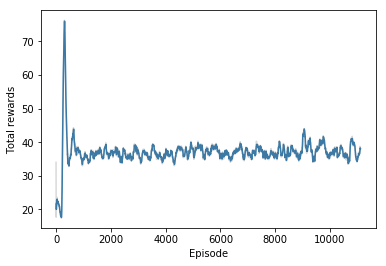

In [56]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

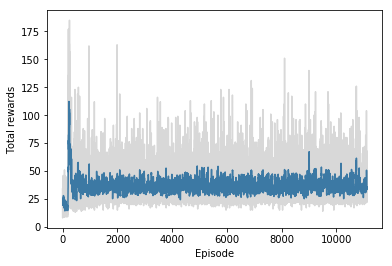

In [57]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

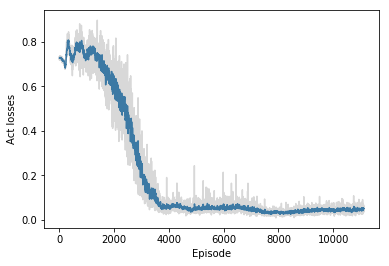

In [58]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

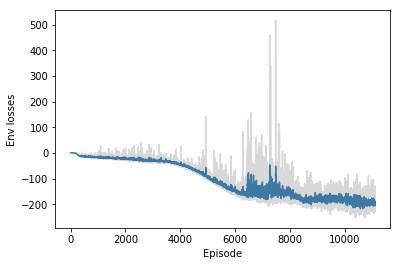

In [59]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

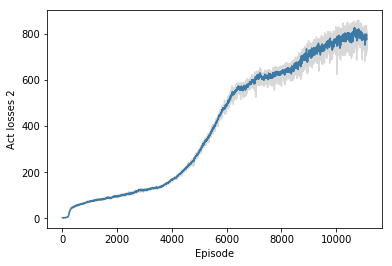

In [60]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
